In [1]:
def sum_weights_for_unique_masks(masks, masks_weights, logits): #, poolers):
    # Convert each boolean mask to a unique string of 0s and 1s
    mask_strs = [''.join(map(str, mask.bool().int().flatten().tolist())) for mask in masks]
    img_size = 66

    # Dictionary to store summed weights for each unique mask
    unique_masks_weights = {}
    unique_masks_logits = {}
    unique_masks_count = {}
    unique_masks_dict = {}

    for i, (mask_str, weight, pred) in enumerate(zip(mask_strs, masks_weights, logits)):
        if mask_str in unique_masks_weights:
            unique_masks_weights[mask_str] += weight
            unique_masks_logits[mask_str] += pred
            unique_masks_count[mask_str] += 1
        else:
            unique_masks_dict[mask_str] = masks[i]
            unique_masks_weights[mask_str] = weight
            unique_masks_logits[mask_str] = pred
            unique_masks_count[mask_str] = 1

    # Convert dictionary keys back to boolean masks
    unique_keys = sorted(unique_masks_weights.keys())
    unique_masks = [unique_masks_dict[key] for key in unique_keys]
    summed_weights = [unique_masks_weights[key] for key in unique_keys]
    mean_logits = [unique_masks_logits[key] for key in unique_keys]

    return unique_masks, summed_weights, mean_logits #, mean_poolers

In [2]:
class Stats:
    def __init__(self):
        self.image = None
        self.label = None
        self.unique_masks = None
        self.summed_weights = None
        self.mean_logits = None
        
        self.omega_subset = []
        self.sigma_subset = []
        self.bright_subset = []
        self.dark_subset = []
        self.highweight_subset = []
        self.darkhighweight_omega_subset = []
        self.darkhighweight_sigma_subset = []
        self.brighthighweight_omega_subset = []
        self.brighthighweight_sigma_subset = []
        self.darkgoodloss_omega_subset = []
        self.darkgoodloss_sigma_subset = []
        self.brightgoodloss_omega_subset = []
        self.brightgoodloss_sigma_subset = []
        self.stds = []
        self.mask_weight_total = {
            'dark': [0, 0],
            'bright': [0, 0]
        }
        self.mask_weight_list = {
            'dark': [[], []],
            'bright': [[], []]
        }
        
    def linearize(self):
        res_str = ''
        for k, v in self.__dict__.items():
            if k not in ['image', 'label', 'unique_masks', 'summed_weights', 'mean_logits', 'mask_intensities']:
                if isinstance(v, list) and len(v) > 0:
                    res_str += ' ' + k + ' ' + str(v)
        return res_str

In [9]:
output_dir = '../../exps/cosmogrid_4h_nmm100_bf_even_ep20_pis32_gg1.0_gs1.0_ggta1.0_ggtb0.1_bblNone_ihs32_segseg/best/val_results_simp_stats'

In [3]:
import os
import torch
from tqdm.auto import tqdm

# input_dir = '../../exps/cosmogrid_4h_nmm100_bf_even_ep20_pis16_gg1.0_gs1.0/best/val_results_simp'
# input_dir = '../../exps/cosmogrid_1h_nmm100_bf_even_ep1_pis16_gg1.0_gs1.0_ggta1.0_ggtb0.1_bblNone_ihs32_segseg/best/val_results_simp'
input_dir = '../../exps/cosmogrid_4h_nmm100_bf_even_ep20_pis32_gg1.0_gs1.0_ggta1.0_ggtb0.1_bblNone_ihs32_segseg/best/val_results_simp'

X = []
images = []
mask_paths = []
mask_idxs = []
preds_all = []
labels_all = []
mask_id_feat_dict = {}


count = 0
filenames = sorted(os.listdir(input_dir))
stats_all = []
total = 0

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

for fi, filename in tqdm(enumerate(filenames), total=len(filenames)):
    if fi % 100 != 0:
        continue
    try:
        data = torch.load(os.path.join(input_dir, filename), map_location=device)
    except:
        print(filename)
        continue
    image = data['image']
    label = data['label']
    logits = data['logits']
    unique_masks = [(unique_mask > 0.5).float() for unique_mask in data['unique_masks']]
    summed_weights = data['summed_weights']
    mean_logits = data['mean_logits']
    
    stats_single = Stats()
    stats_single.image = image
    stats_single.label = label
    stats_single.unique_masks = unique_masks
    stats_single.summed_weights = summed_weights
    stats_single.mean_logits = mean_logits
    
    for i in range(len(unique_masks)):
        k = tuple([filename, i])
        img, label, mask, mask_weight, pred = image, label, unique_masks[i], summed_weights[i], mean_logits[i]
        img_pth = img
        mask_pth = mask #torch.from_numpy(mask)
        masked_img = img_pth*(mask_pth > 1e-4)

        VERBOSE = False
        outputs = []


        DARK_THRESHOLD = 0
        BRIGHT_THRESHOLD = 2

        sigma = img_pth.std()
        bright_pixels = (img_pth > 2*sigma).sum()
        # total = img_pth.numel()
        #     if i == 0: 
        #         print(bright_pixels, bright_pixels/total)
        frac_bright_bhuv = (masked_img > 2*sigma).sum()/bright_pixels
        frac_bright_wong = (masked_img > 2*sigma).sum()/((mask_pth > 1e-4).sum())

        mask_intensity = (masked_img.squeeze()[(mask_pth > 1e-4)].mean())
        if VERBOSE: 
            print(f'mask #{i}')
            print(f'{frac_bright_bhuv} - fraction of bright pixels in mask / bright pixels in image')
            print(f'{frac_bright_wong} - fraction of bright pixels in mask / pixels in mask')
            print(f'Omega weight: {mask_weight[0]:.2f}, Sigma_8 weight: {mask_weight[1]:.2f}')
            print(f'[{mask_intensity:.4f} > {2*sigma:.4f}] Is supercluster? {mask_intensity > 2*sigma}')
        outputs.append([mask_intensity, 2*sigma])

        # subset for omega
        if mask_intensity > BRIGHT_THRESHOLD*sigma:
            stats_single.bright_subset.append(k)
            stats_single.mask_weight_total['bright'][0] += mask_weight[0] 
            stats_single.mask_weight_total['bright'][1] += mask_weight[1] 
            stats_single.mask_weight_list['bright'][0].append(mask_weight[0].item())
            stats_single.mask_weight_list['bright'][1].append(mask_weight[1].item())

        if mask_intensity < DARK_THRESHOLD*sigma:
            stats_single.dark_subset.append(k)
            stats_single.mask_weight_total['dark'][0] += mask_weight[0] 
            stats_single.mask_weight_total['dark'][1] += mask_weight[1] 
            stats_single.mask_weight_list['dark'][0].append(mask_weight[0].item())
            stats_single.mask_weight_list['dark'][1].append(mask_weight[1].item())


        if mask_intensity < DARK_THRESHOLD*sigma and mask_weight[0] == 1:
            stats_single.darkhighweight_omega_subset.append(k)
        if mask_intensity < DARK_THRESHOLD*sigma and mask_weight[1] == 1:
            stats_single.darkhighweight_sigma_subset.append(k)
        if mask_intensity > BRIGHT_THRESHOLD*sigma and mask_weight[0] >= 0.3:
            stats_single.brighthighweight_omega_subset.append(k)
        if mask_intensity > BRIGHT_THRESHOLD*sigma and mask_weight[1] >= 0.4:
            stats_single.brighthighweight_sigma_subset.append(k)

        if mask_intensity < DARK_THRESHOLD*sigma and (pred[0] - label[0]).abs().sum() < 1e-2:
            stats_single.darkgoodloss_omega_subset.append(k)
        if mask_intensity < DARK_THRESHOLD*sigma and (pred[1] - label[1]).abs().sum() < 1e-2:
            stats_single.darkgoodloss_sigma_subset.append(k)
        if mask_intensity > BRIGHT_THRESHOLD*sigma and (pred[0] - label[0]).abs().sum() < 1e-2:
            stats_single.brightgoodloss_omega_subset.append(k)
        if mask_intensity > BRIGHT_THRESHOLD*sigma and (pred[1] - label[1]).abs().sum() < 1e-2:
            stats_single.brightgoodloss_sigma_subset.append(k)
        if mask_weight[0] == 1 and (pred - label).abs().sum() < 1e-2:
            stats_single.highweight_subset.append(k)
        # subset for omega
        # print(mask_weight[0].cpu(), pred, torch.Tensor(label))
        if mask_weight[0] > 0.9 and (pred - label).abs().sum() < 1e-1: 
        #     if mask_weight[0] > 0.1 and mask_intensity > 1*sigma: 
            stats_single.omega_subset.append(k)
        if mask_weight[1] > 0.9 and (pred - label).abs().sum() < 1e-1: 
            stats_single.sigma_subset.append(k)
        stats_single.stds.append(mask_intensity / sigma)
        total += 1
        stats_str = stats_single.linearize()
        if len(stats_str) > 0 and 'dark' in stats_str and 'bright' in stats_str:
            print(stats_str)
    stats_all.append(stats_single)

  0%|          | 0/10000 [00:00<?, ?it/s]

 bright_subset [('4689.pt', 0)] dark_subset [('4689.pt', 1)] brighthighweight_sigma_subset [('4689.pt', 0)] stds [tensor(2.0426, device='cuda:0'), tensor(-0.0667, device='cuda:0')]
 bright_subset [('6669.pt', 0)] dark_subset [('6669.pt', 1)] darkhighweight_sigma_subset [('6669.pt', 1)] brighthighweight_omega_subset [('6669.pt', 0)] darkgoodloss_sigma_subset [('6669.pt', 1)] stds [tensor(2.9758, device='cuda:0'), tensor(-0.0195, device='cuda:0')]


In [4]:
stats_all[0].__dict__

{'image': tensor([[[-0.0038, -0.0044, -0.0079,  ...,  0.0032, -0.0029, -0.0011],
          [-0.0005, -0.0063, -0.0056,  ...,  0.0062,  0.0031,  0.0016],
          [ 0.0036, -0.0004,  0.0004,  ..., -0.0022,  0.0012, -0.0012],
          ...,
          [ 0.0084,  0.0095,  0.0037,  ..., -0.0075, -0.0046, -0.0057],
          [ 0.0031,  0.0061, -0.0007,  ..., -0.0068, -0.0039, -0.0073],
          [ 0.0038,  0.0138, -0.0004,  ..., -0.0027, -0.0030, -0.0082]]],
        device='cuda:0'),
 'label': tensor([0.2934, 0.4518], device='cuda:0'),
 'unique_masks': [tensor([[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0'),
  tensor([[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0

In [5]:
len(stats_all[0].unique_masks), len(stats_all[0].summed_weights),  len(stats_all[0].mean_logits)

(2, 2, 2)

In [7]:
import math
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

def show_img_seg_plot(image, label, unique_masks, summed_weights, mean_logits, save_dir=None):
    rows = math.ceil(len(unique_masks)/5)
    cols = 5
    fig, axs = plt.subplots(rows, cols, 
                            figsize=(cols * 3, rows * 3))
    axs = axs.ravel()
    
    for j in range(len(unique_masks)):
        img, label, mask, mask_weight, pred = image, label, unique_masks[j], summed_weights[j], mean_logits[j]
        img_pth = img
        mask_pth = mask #torch.from_numpy(mask)
        masked_img = img_pth*(mask_pth > 1e-4)
        DARK_THRESHOLD = 0
        BRIGHT_THRESHOLD = 2
        sigma = img_pth.std()
        bright_pixels = (img_pth > 2*sigma).sum()
        frac_bright_bhuv = (masked_img > 2*sigma).sum()/bright_pixels
        frac_bright_wong = (masked_img > 2*sigma).sum()/((mask_pth > 1e-4).sum())
        mask_intensity = (masked_img.squeeze()[(mask_pth > 1e-4)].mean())
        
        map_plotter(image[0].cpu().numpy(), unique_masks[j].cpu().numpy(), ax=axs[j])
        # axs[j].imshow(image[0].cpu().numpy())
        # axs[j].contour(unique_masks[j].cpu().numpy() > 0, 2, colors='red')
        # # import pdb; pdb.set_trace()
        # axs[j].contourf(unique_masks[j].cpu().numpy() > 0, 2, hatches=['//', None, None],
        #                 cmap='gray', extend='neither', linestyles='--', alpha=0.01)
        axs[j].set_title(str(round(float(mask_intensity.item() / sigma), 4)) + ' std')
        print((unique_masks[j].cpu().numpy() > 0).sum())
        print(unique_masks[j].cpu().numpy().max(), unique_masks[j].cpu().numpy().min())
    for j in range(len(axs)):
        axs[j].axis('off')
    plt.show()
    
    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)
        plt.figure()
        plt.imshow(image[0].cpu().numpy())
        plt.axis('off')
        plt.savefig(os.path.join(save_dir, 'original'), dpi=300, bbox_inches='tight', pad_inches=0)
        plt.close()


        for j in range(len(unique_masks)):
            img, label, mask, mask_weight, pred = image, label, unique_masks[j], summed_weights[j], mean_logits[j]
            img_pth = img
            mask_pth = mask #torch.from_numpy(mask)
            masked_img = img_pth*(mask_pth > 1e-4)
            DARK_THRESHOLD = 0
            BRIGHT_THRESHOLD = 2
            sigma = img_pth.std()
            bright_pixels = (img_pth > 2*sigma).sum()
            frac_bright_bhuv = (masked_img > 2*sigma).sum()/bright_pixels
            frac_bright_wong = (masked_img > 2*sigma).sum()/((mask_pth > 1e-4).sum())
            mask_intensity = (masked_img.squeeze()[(mask_pth > 1e-4)].mean())
            plt.figure()
            map_plotter(image[0].cpu().numpy(), unique_masks[j].cpu().numpy(), ax=plt)
            plt.axis('off')
            plt.savefig(os.path.join(save_dir, f'{j}_std{round(float(mask_intensity.item() / sigma), 4)}.png'), dpi=300, bbox_inches='tight', pad_inches=0)
            plt.close()
    
    rows = math.ceil(len(unique_masks)/5)
    cols = 5
    fig, axs = plt.subplots(rows, cols, 
                            figsize=(cols * 3, rows * 3))
    axs = axs.ravel()
    
    for j in range(len(unique_masks)):
        img, label, mask, mask_weight, pred = image, label, unique_masks[j], summed_weights[j], mean_logits[j]
        img_pth = img
        mask_pth = mask #torch.from_numpy(mask)
        masked_img = img_pth*(mask_pth > 1e-4)
        DARK_THRESHOLD = 0
        BRIGHT_THRESHOLD = 2
        sigma = img_pth.std()
        bright_pixels = (img_pth > 2*sigma).sum()
        frac_bright_bhuv = (masked_img > 2*sigma).sum()/bright_pixels
        frac_bright_wong = (masked_img > 2*sigma).sum()/((mask_pth > 1e-4).sum())
        mask_intensity = (masked_img.squeeze()[(mask_pth > 1e-4)].mean())
        
        axs[j].imshow(unique_masks[j].cpu().numpy() > 0)
        # axs[j].imshow(image[0].cpu().numpy())
        # axs[j].contour(unique_masks[j].cpu().numpy() > 0, 1, colors='red')
        # import pdb; pdb.set_trace()
        # axs[j].contourf(unique_masks[j].cpu().numpy() > 0, 1, hatches=['//', None, None],
        #                 cmap='gray', extend='neither', linestyles='--', alpha=0.01)
        # axs[j].set_title(str(round(float(mask_intensity.item() / sigma), 4)) + ' std')
    for j in range(len(axs)):
        axs[j].axis('off')
    plt.show()
    
def map_plotter(image, mask, ax=plt, type='dim'): 
    default_cmap = matplotlib.rcParams['image.cmap']
    cmap = plt.get_cmap(default_cmap)
    gray_cmap = plt.get_cmap('gray')
    
    norm = plt.Normalize()
    normed_image = norm(image)
    # normed_image = np.clip((image - img_min) / (img_max - img_min) * 3, 0, 1)
    rgb_image = cmap(normed_image)
    if type == 'dim':
        gray_image = (gray_cmap(normed_image) / 2)
        mask_bool = np.repeat((mask > 0)[:,:,None], 4, axis=-1)
        gray_image[mask_bool] = rgb_image[mask_bool]
        ax.imshow(gray_image)
    elif type == 'contour':
        # 1. Find the contours of the mask
        mask_bool = (mask > 0).astype(np.float32)
        dilated_mask_bool = binary_dilation(mask_bool)
        contours_original = measure.find_contours(mask_bool, 0.5)
        contours_dilated = measure.find_contours(dilated_mask_bool, 0.51)

        # 2. Overlay the contours on top of the original image
        # fig, ax = plt.subplots()
        ax.imshow(rgb_image)

        for contour in contours_dilated:
            ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='white')  # color can be changed as needed

        for contour in contours_original:
            ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')  # color can be changed as needed

In [6]:
stats_all_comb = Stats()
total_num_masks = 0
for stat in tqdm(stats_all):
    for k, v in stat.__dict__.items():
        if k not in ['image', 'label', 'unique_masks', 'summed_weights', 'mean_logits']:
            if isinstance(v, list) and len(v) > 0:
                stats_all_comb.__dict__[k].append(v)
        elif k == 'unique_masks':
            total_num_masks += len(v)
total_num_masks

  0%|          | 0/100 [00:00<?, ?it/s]

205

In [7]:
len(stats_all_comb.bright_subset), len(stats_all_comb.dark_subset)

(6, 56)

In [10]:
os.makedirs(output_dir, exist_ok=True)
torch.save(stats_all_comb, os.path.join(output_dir, 'stats_all_comb2.pt'))
import json
json.dump({
    'num_bright': len(stats_all_comb.bright_subset),
    'num_dark': len(stats_all_comb.dark_subset)
}, open(os.path.join(output_dir, 'stats.json'), 'w'), indent=4)

In [53]:
bright_weights_omega = []

bright_filenames = [tup_list[0][0] for tup_list in stats_all_comb.bright_subset]
bright_filenames;

  0%|          | 0/409 [00:00<?, ?it/s]

47
1.0 0.0
63
1.0 0.0


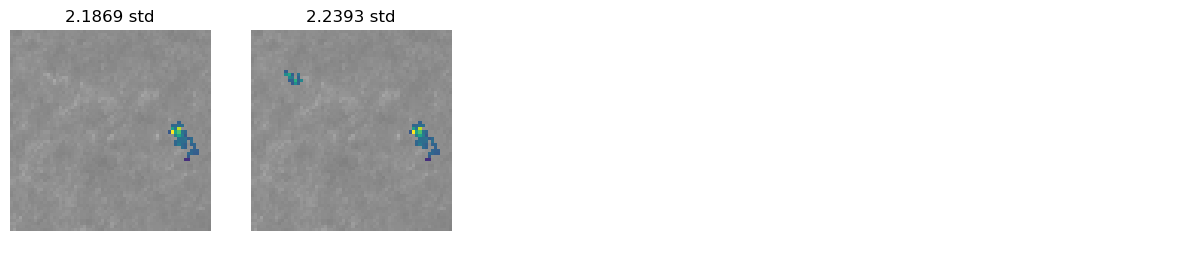

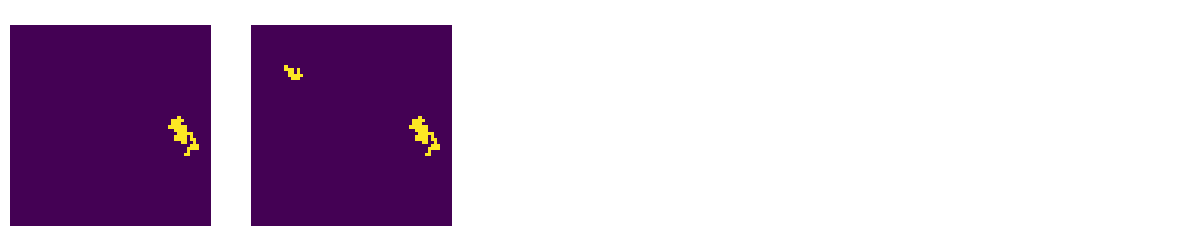

28
1.0 0.0
3347
1.0 0.0


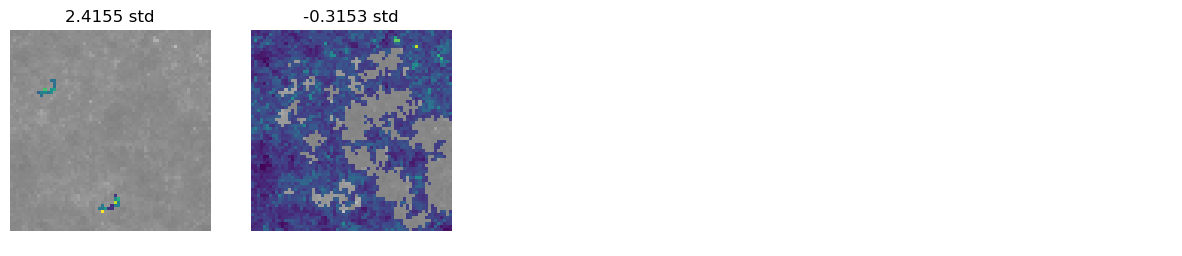

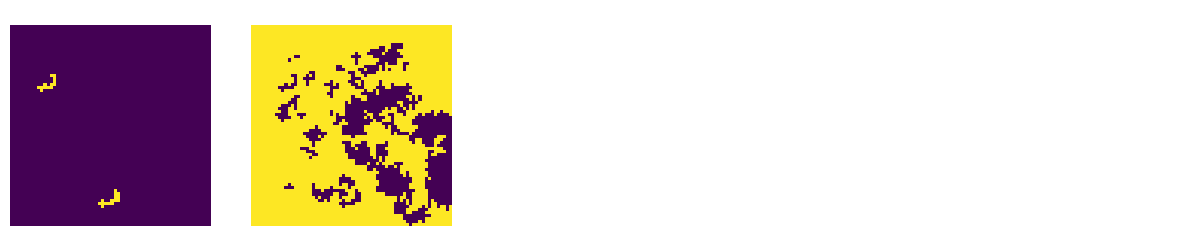

13
1.0 0.0
2691
1.0 0.0
2695
1.0 0.0


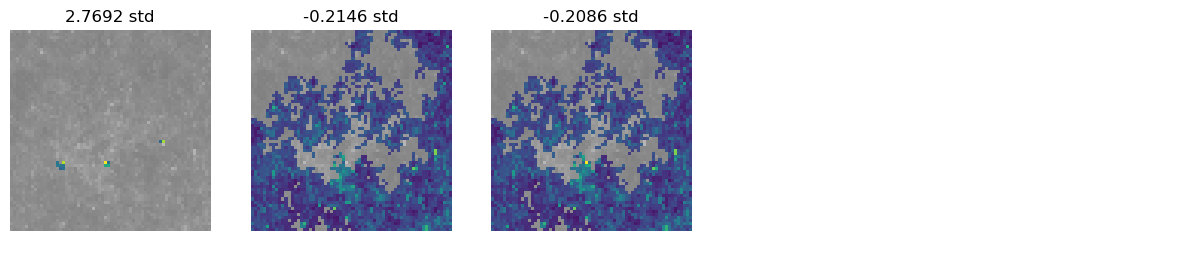

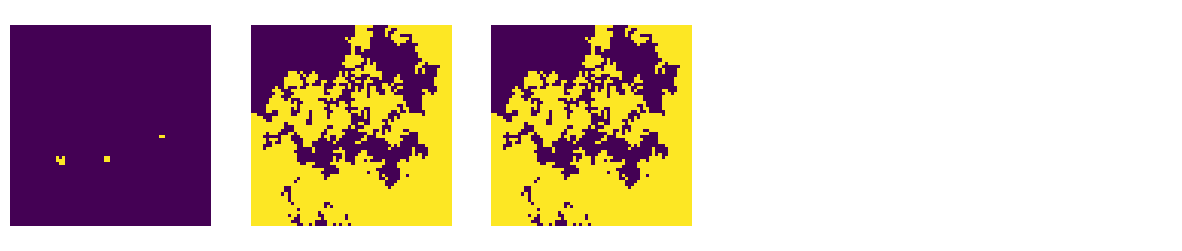

103
1.0 0.0
115
1.0 0.0
105
1.0 0.0
85
1.0 0.0
8
1.0 0.0
25
1.0 0.0
1923
1.0 0.0
2014
1.0 0.0
2014
1.0 0.0


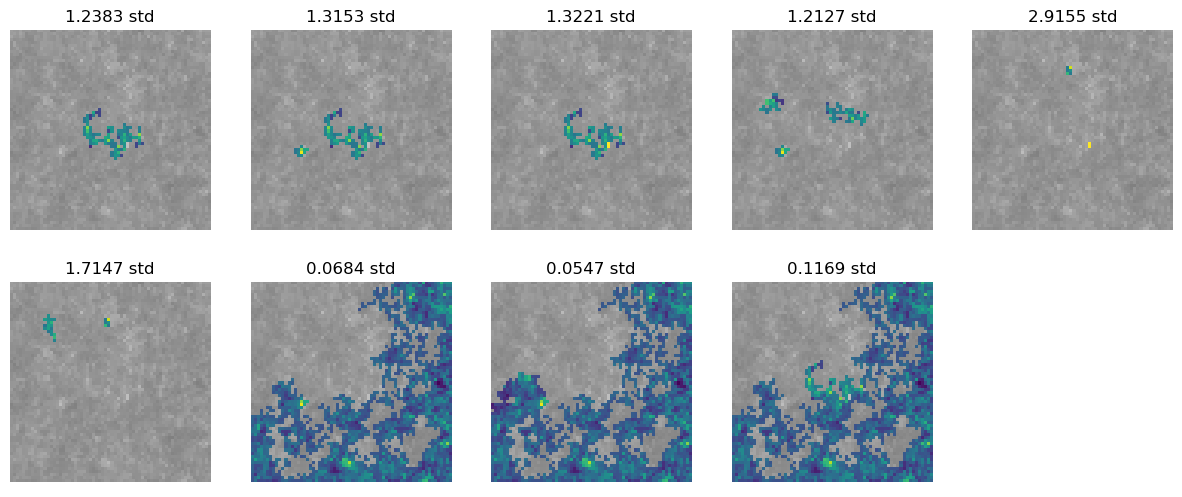

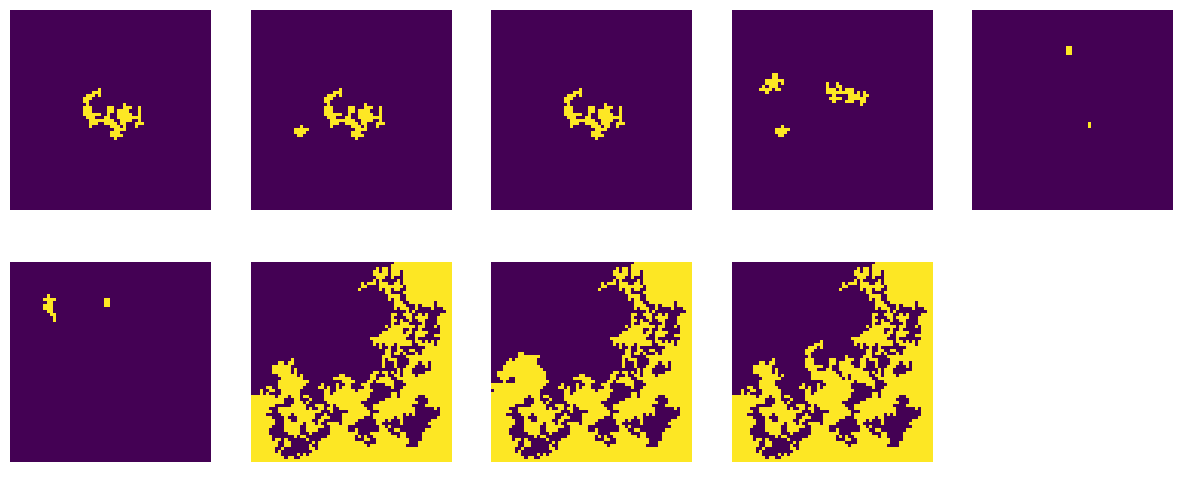

121
1.0 0.0
123
1.0 0.0
127
1.0 0.0


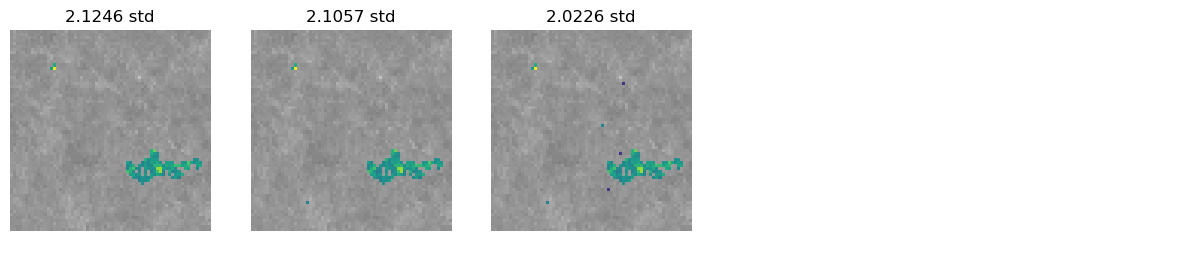

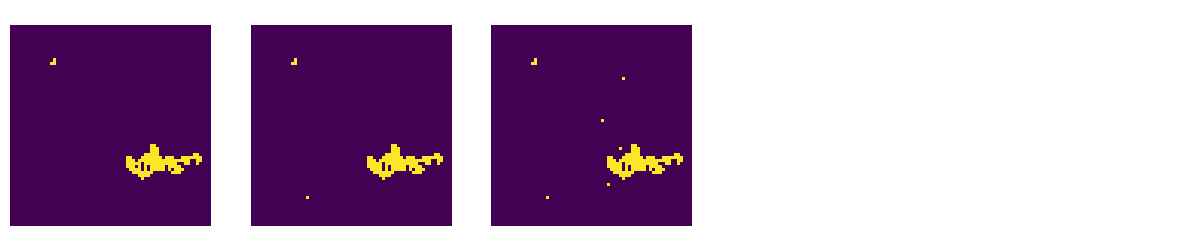

44
1.0 0.0
845
1.0 0.0
64
1.0 0.0
37
1.0 0.0
2130
1.0 0.0
2146
1.0 0.0
2930
1.0 0.0


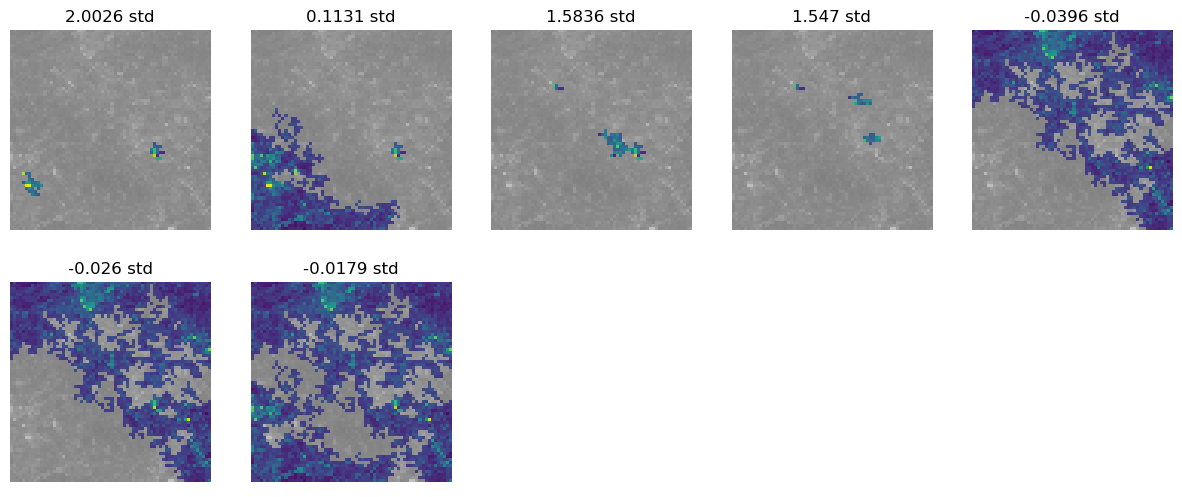

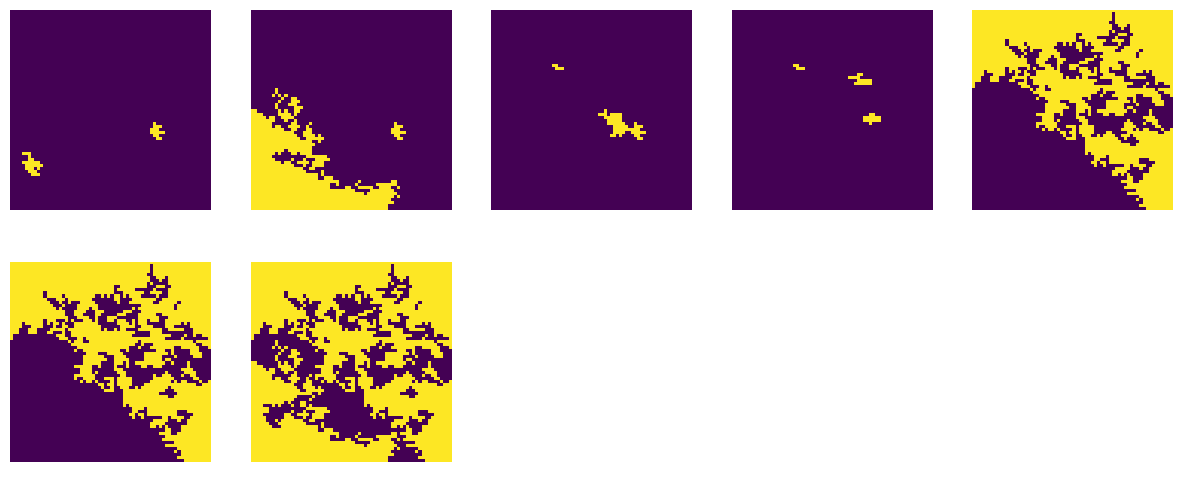

17
1.0 0.0
3358
1.0 0.0
3360
1.0 0.0
3366
1.0 0.0


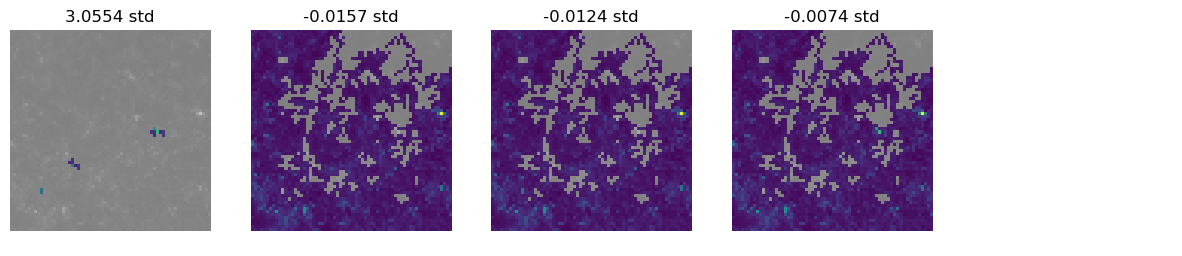

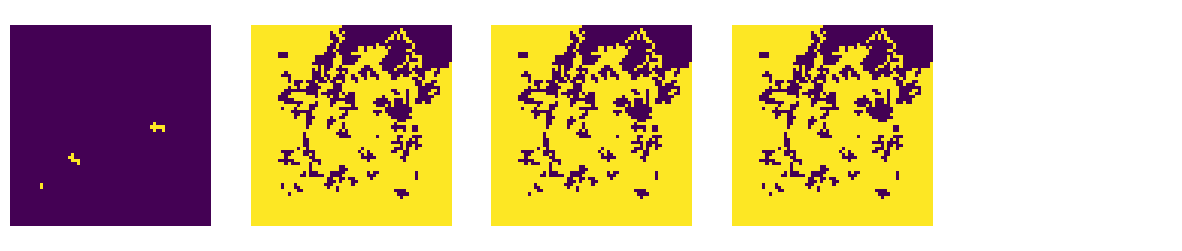

72
1.0 0.0
3771
1.0 0.0
3817
1.0 0.0


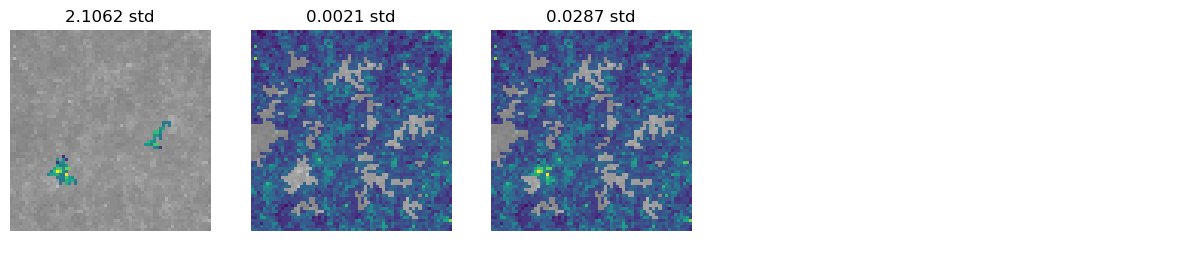

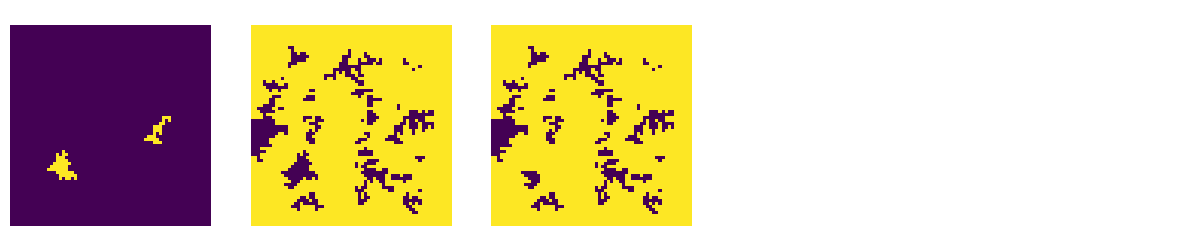

15
1.0 0.0
4089
1.0 0.0
4095
1.0 0.0


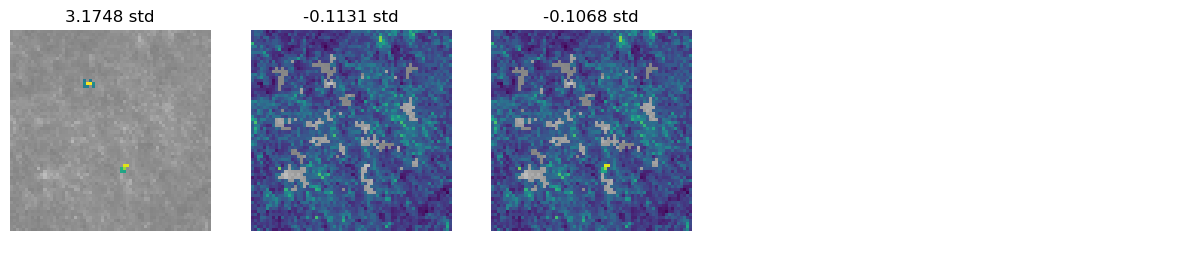

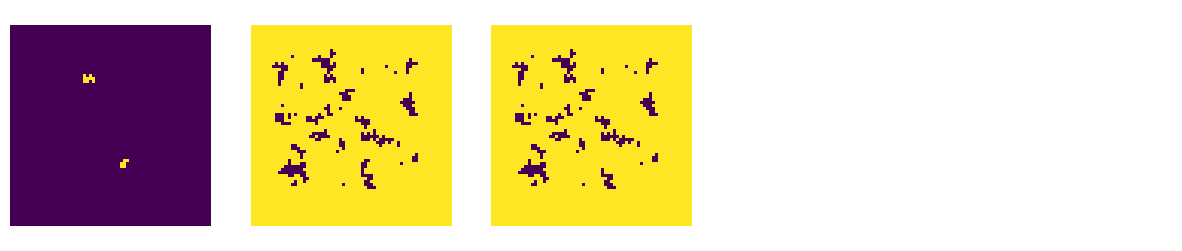

38
1.0 0.0
3800
1.0 0.0
3825
1.0 0.0


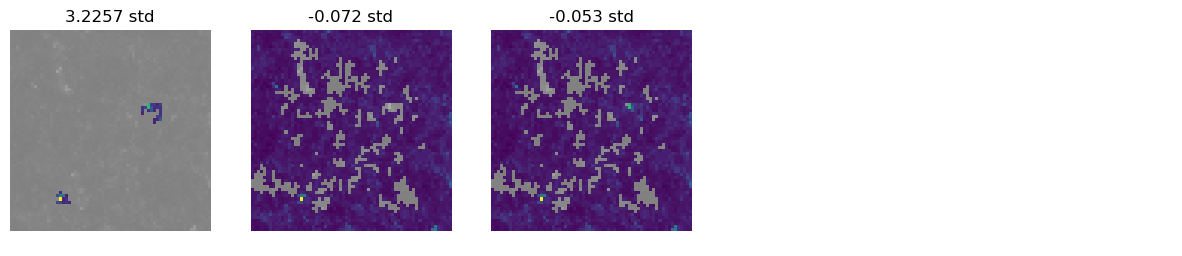

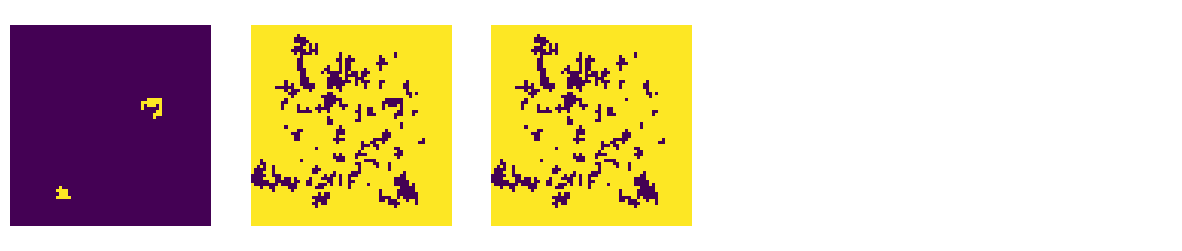

In [54]:
bright_weights_omega = []
bright_weights_sigma = []

bright_filenames = [tup_list[0][0] for tup_list in stats_all_comb.bright_subset]

count = 0
# for filename in tqdm(filenames):
for filename in tqdm(bright_filenames):
    try:
        data = torch.load(os.path.join(input_dir, filename), map_location=device)
    except:
        print(filename)
        continue
    image = data['image']
    label = data['label']
    logits = data['logits']
    unique_masks = [(unique_mask > 0.5).float() for unique_mask in data['unique_masks']]
    summed_weights = data['summed_weights']
    mean_logits = data['mean_logits']
    
    # stats_single = Stats()
    # stats_single.image = image
    # stats_single.label = label
    # stats_single.unique_masks = unique_masks
    # stats_single.summed_weights = summed_weights
    # stats_single.mean_logits = mean_logits
    if count < 10:
        show_img_seg_plot(image, label, unique_masks, summed_weights, mean_logits)
        count += 1
    
    for i in range(len(unique_masks)):
        k = tuple([filename, i])
        img, label, mask, mask_weight, pred = image, label, unique_masks[i], summed_weights[i], mean_logits[i]
        img_pth = img
        mask_pth = mask #torch.from_numpy(mask)
        masked_img = img_pth*(mask_pth > 1e-4)

        VERBOSE = False
        outputs = []


        DARK_THRESHOLD = 0
        BRIGHT_THRESHOLD = 2

        sigma = img_pth.std()
        bright_pixels = (img_pth > 2*sigma).sum()
        # total = img_pth.numel()
        #     if i == 0: 
        #         print(bright_pixels, bright_pixels/total)
        frac_bright_bhuv = (masked_img > 2*sigma).sum()/bright_pixels
        frac_bright_wong = (masked_img > 2*sigma).sum()/((mask_pth > 1e-4).sum())

        mask_intensity = (masked_img.squeeze()[(mask_pth > 1e-4)].mean())
        
        if mask_intensity > BRIGHT_THRESHOLD*sigma:
            bright_weights_omega.append(mask_weight[0].item())
            bright_weights_sigma.append(mask_weight[1].item())

In [55]:
min(bright_weights_omega), max(bright_weights_omega)

(0.0, 1.0)

  0%|          | 0/409 [00:00<?, ?it/s]

17
1.0 0.0
3358
1.0 0.0
3360
1.0 0.0
3366
1.0 0.0


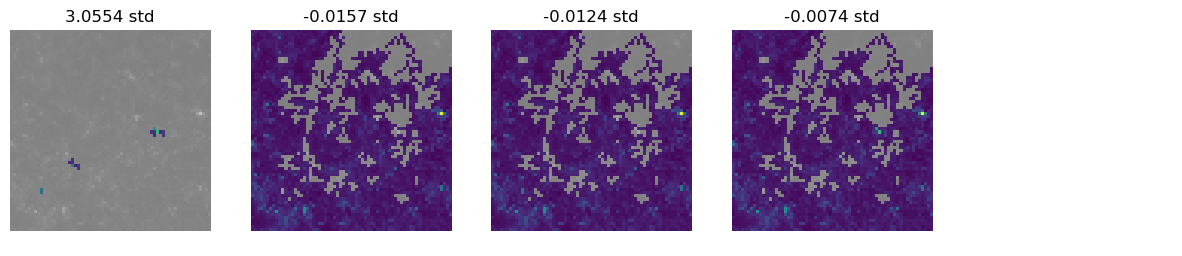

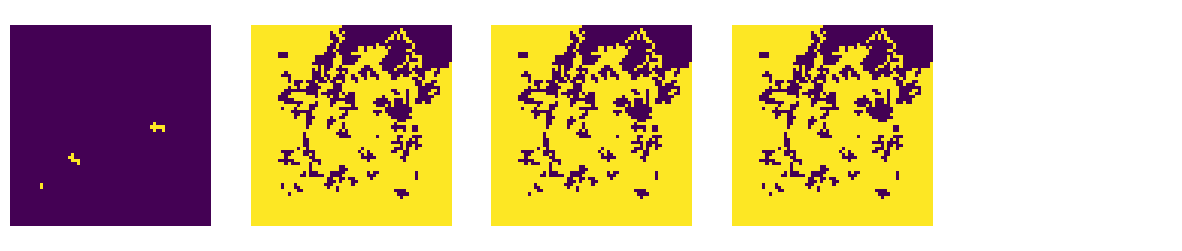

15
1.0 0.0
4089
1.0 0.0
4095
1.0 0.0


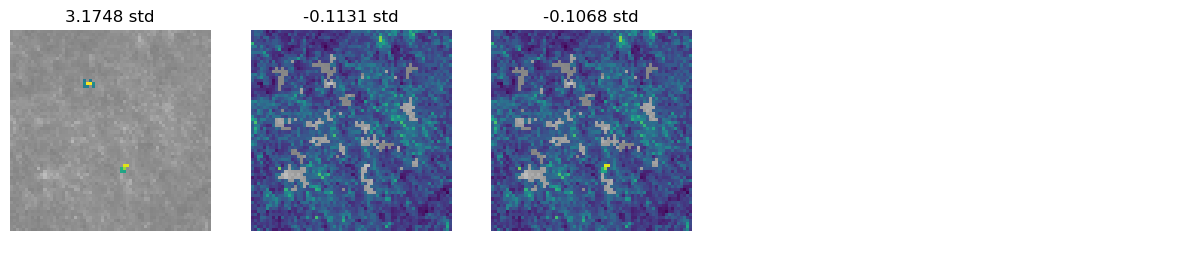

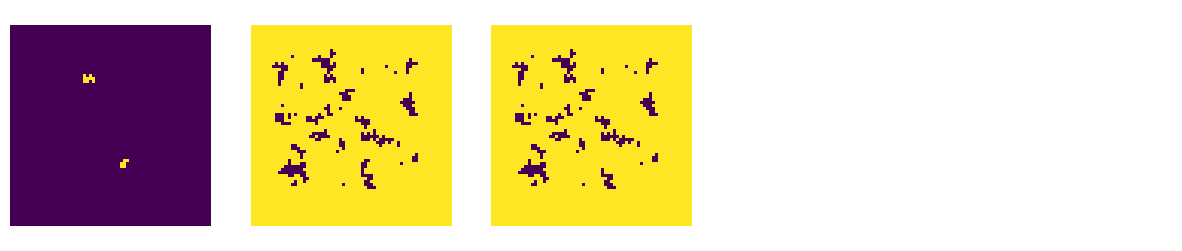

38
1.0 0.0
3800
1.0 0.0
3825
1.0 0.0


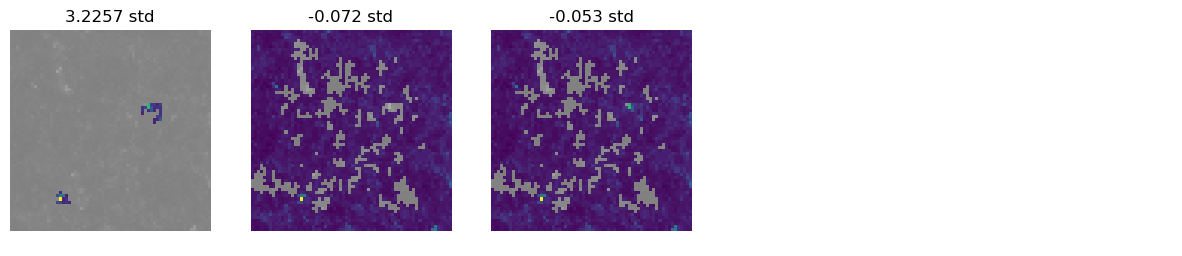

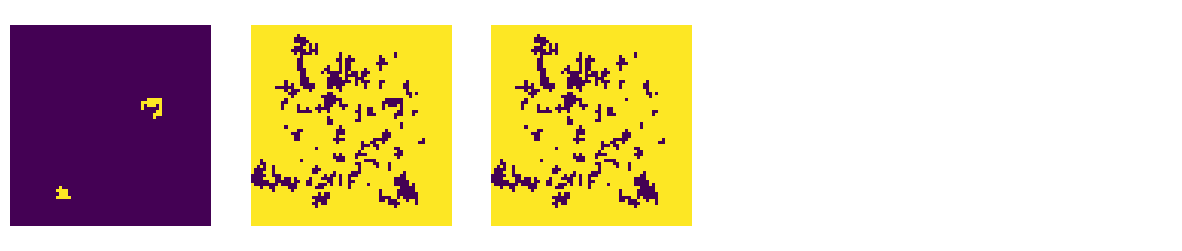

1
1.0 0.0
4021
1.0 0.0


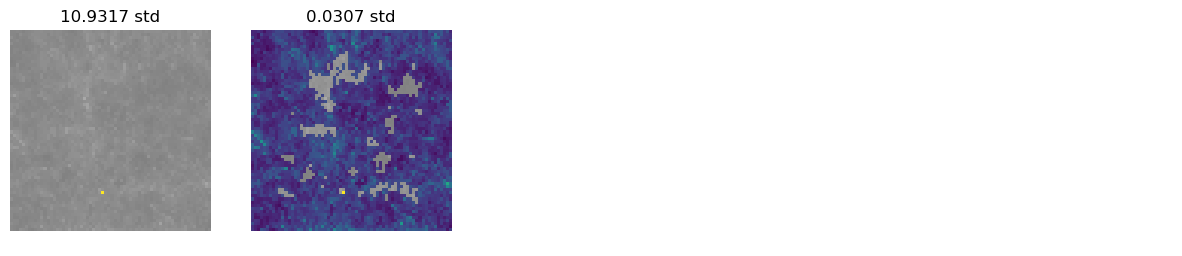

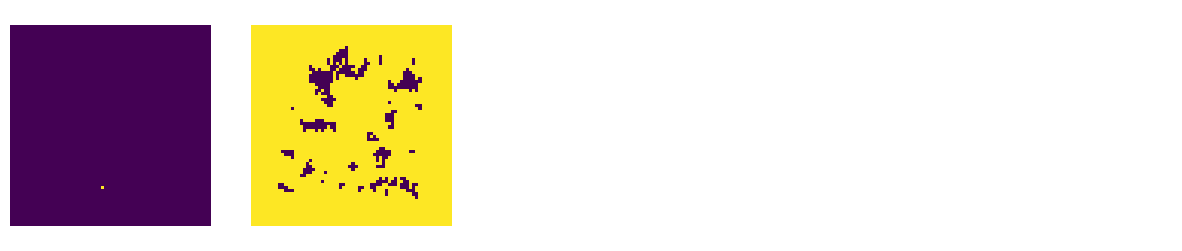

19
1.0 0.0
3817
1.0 0.0
3879
1.0 0.0
3823
1.0 0.0


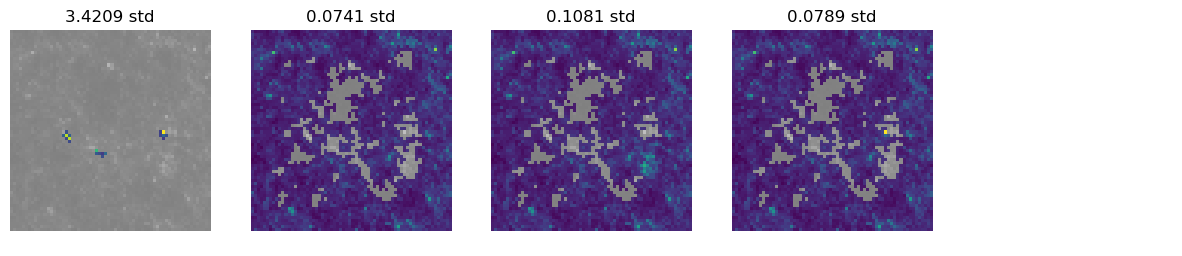

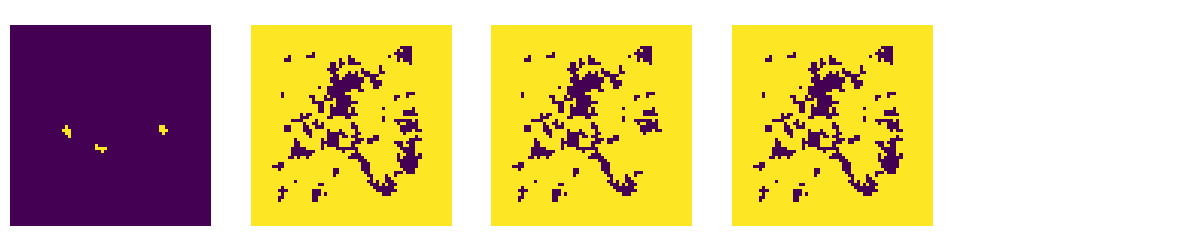

19
1.0 0.0
3820
1.0 0.0
3828
1.0 0.0
3832
1.0 0.0


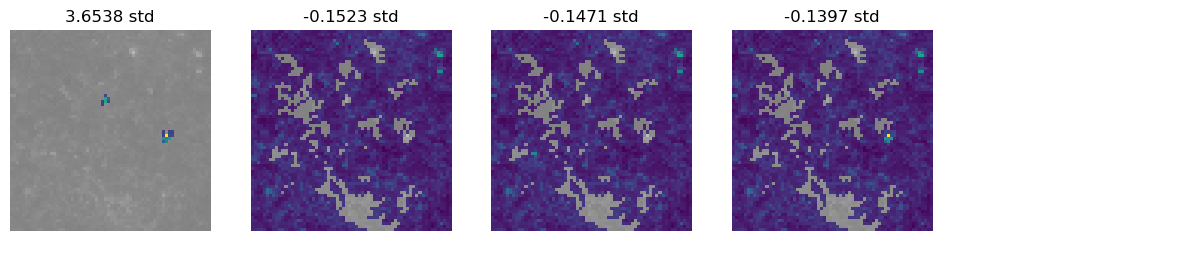

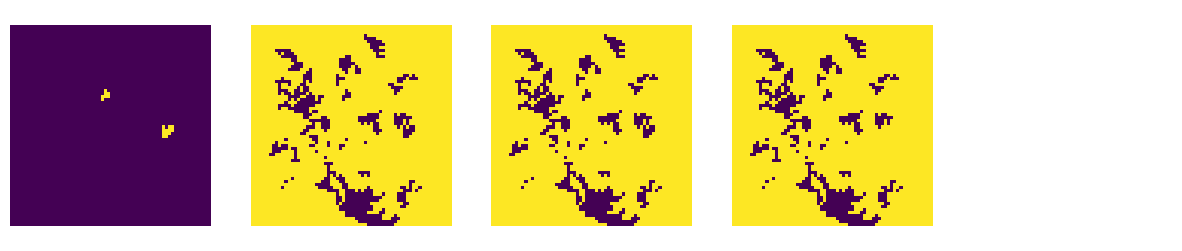

26
1.0 0.0
3692
1.0 0.0
3702
1.0 0.0
3714
1.0 0.0


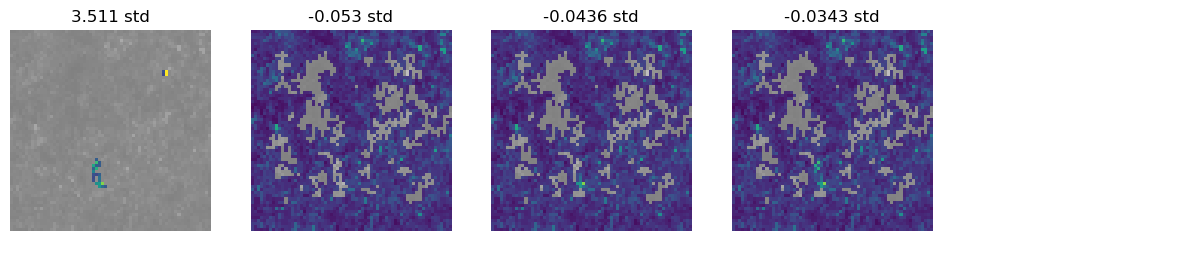

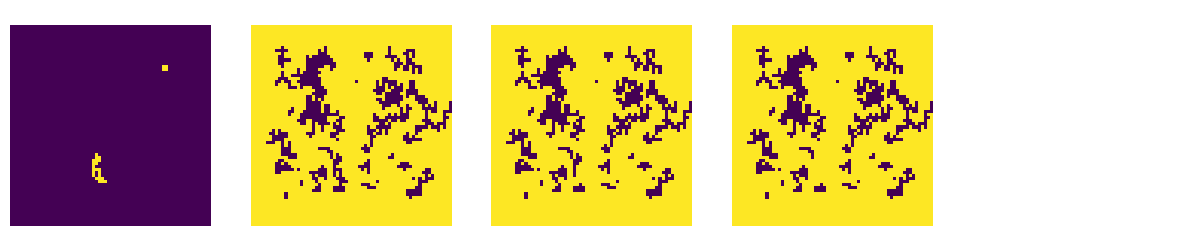

6
1.0 0.0
3953
1.0 0.0


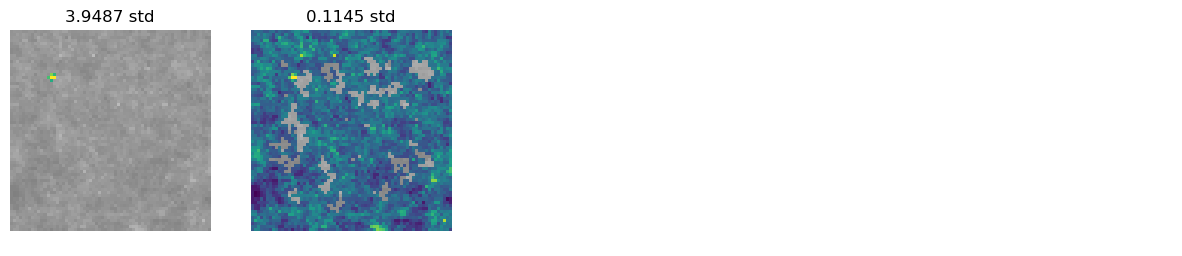

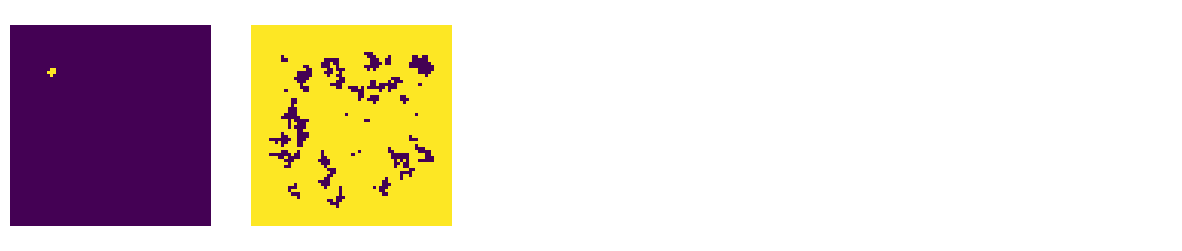

6
1.0 0.0
3453
1.0 0.0


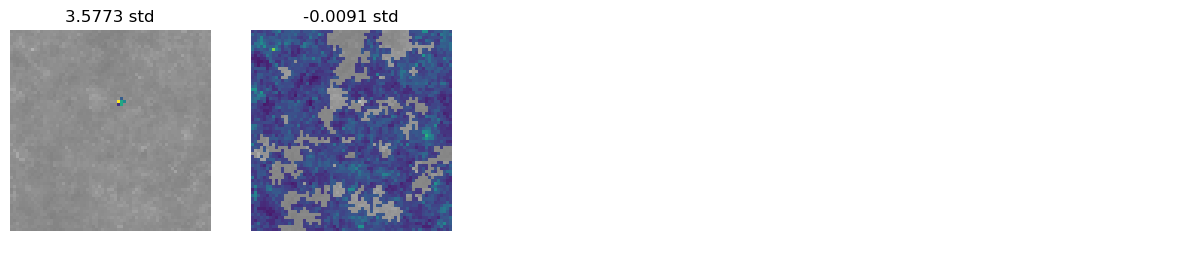

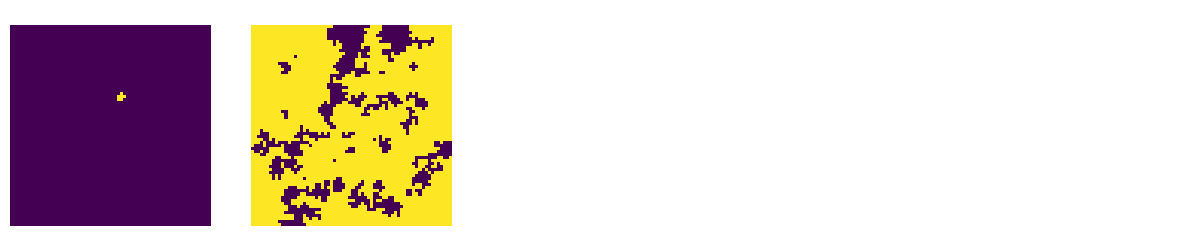

5
1.0 0.0
37
1.0 0.0
3627
1.0 0.0


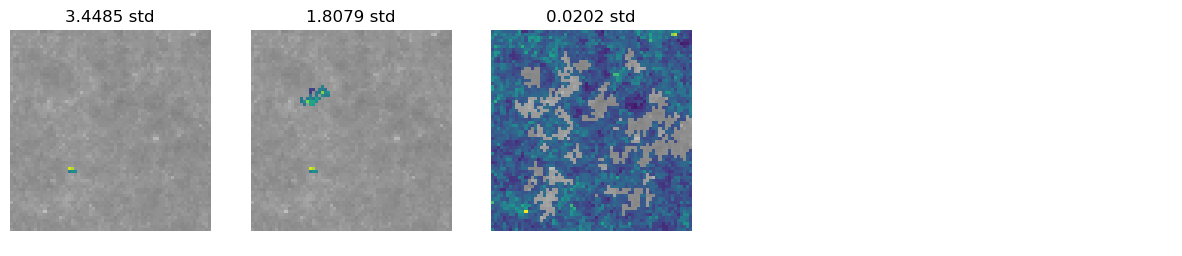

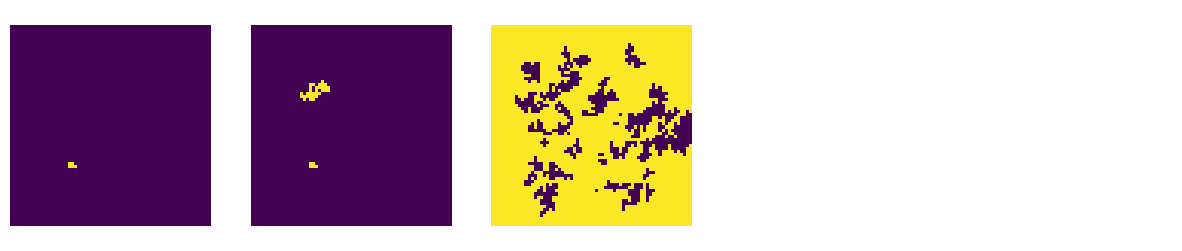

In [56]:
bright_weights_omega_std3 = []
bright_weights_sigma_std3 = []
bright_subset_std3_total = 0

bright_filenames = [tup_list[0][0] for tup_list in stats_all_comb.bright_subset]

# for filename in tqdm(filenames):
count = 0
for filename in tqdm(bright_filenames):
    try:
        data = torch.load(os.path.join(input_dir, filename), map_location=device)
    except:
        print(filename)
        continue
    image = data['image']
    label = data['label']
    logits = data['logits']
    unique_masks = [(unique_mask > 0.5).float() for unique_mask in data['unique_masks']]
    summed_weights = data['summed_weights']
    mean_logits = data['mean_logits']
    
    # stats_single = Stats()
    # stats_single.image = image
    # stats_single.label = label
    # stats_single.unique_masks = unique_masks
    # stats_single.summed_weights = summed_weights
    # stats_single.mean_logits = mean_logits
    
    
    for i in range(len(unique_masks)):
        k = tuple([filename, i])
        img, label, mask, mask_weight, pred = image, label, unique_masks[i], summed_weights[i], mean_logits[i]
        img_pth = img
        mask_pth = mask #torch.from_numpy(mask)
        masked_img = img_pth*(mask_pth > 1e-4)

        VERBOSE = False
        outputs = []


        DARK_THRESHOLD = 0
        BRIGHT_THRESHOLD = 3

        sigma = img_pth.std()
        bright_pixels = (img_pth > 2*sigma).sum()
        # total = img_pth.numel()
        #     if i == 0: 
        #         print(bright_pixels, bright_pixels/total)
        frac_bright_bhuv = (masked_img > 2*sigma).sum()/bright_pixels
        frac_bright_wong = (masked_img > 2*sigma).sum()/((mask_pth > 1e-4).sum())

        mask_intensity = (masked_img.squeeze()[(mask_pth > 1e-4)].mean())
        
        if mask_intensity > BRIGHT_THRESHOLD*sigma:
            bright_weights_omega_std3.append(mask_weight[0].item())
            bright_weights_sigma_std3.append(mask_weight[1].item())
            bright_subset_std3_total += 1
            if count < 10:
                show_img_seg_plot(image, label, unique_masks, summed_weights, mean_logits)
                count += 1

In [57]:
bright_subset_std3_total, min(bright_weights_omega_std3), max(bright_weights_omega_std3)

(89, 0.00020747631788253784, 1.0)

  0%|          | 0/5257 [00:00<?, ?it/s]

3821
1.0 0.0
3828
1.0 0.0


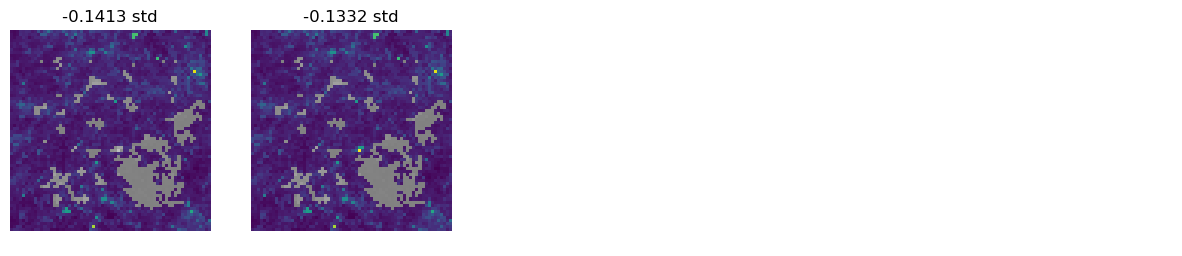

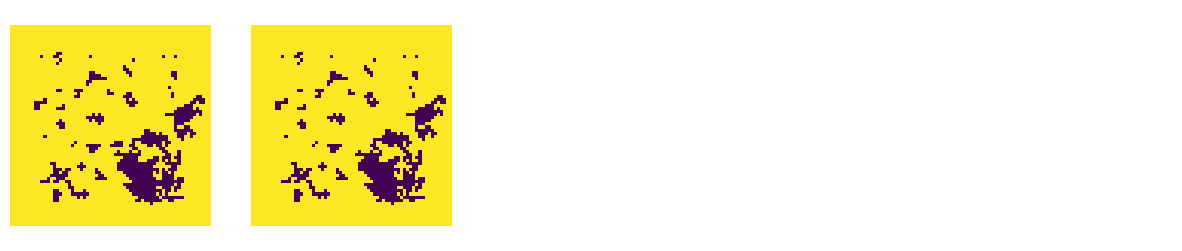

3821
1.0 0.0
3828
1.0 0.0


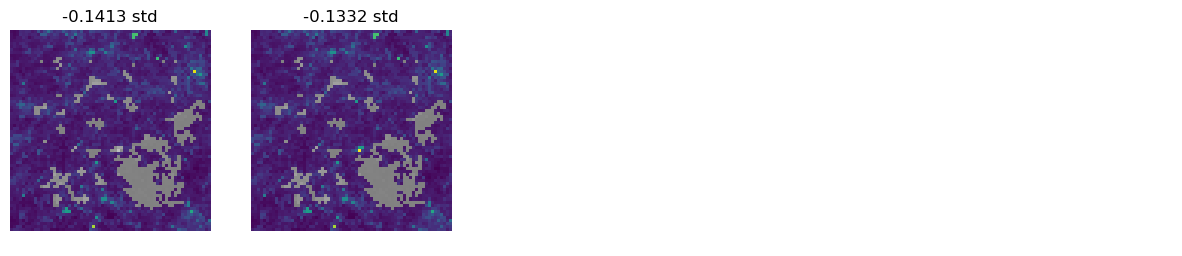

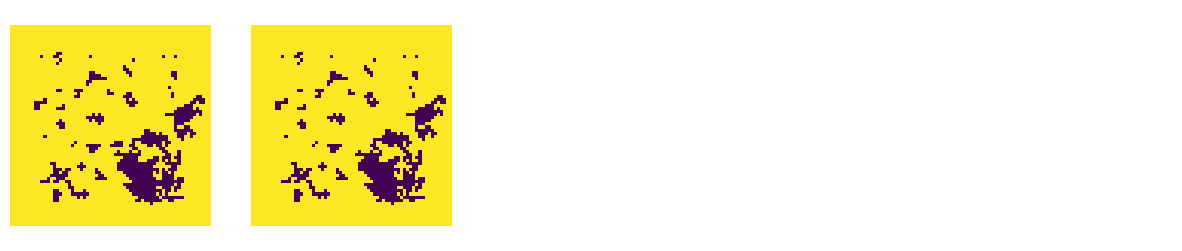

2954
1.0 0.0


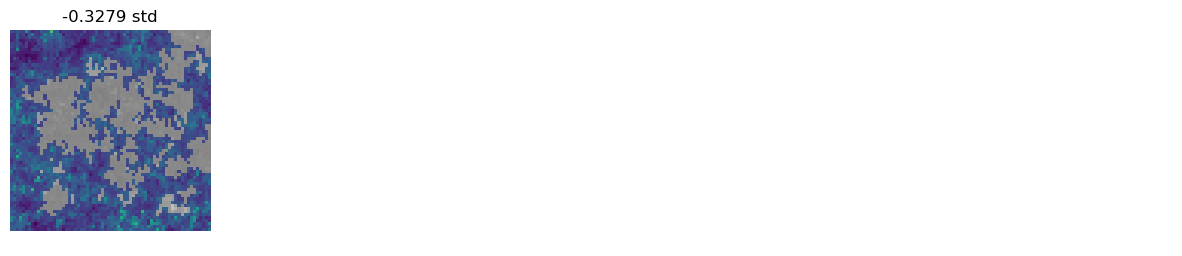

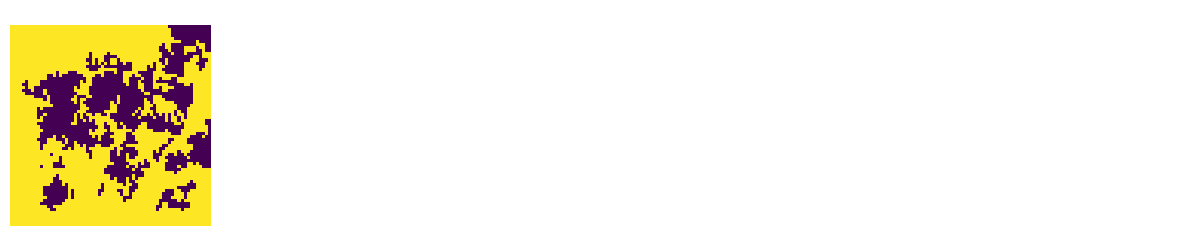

2917
1.0 0.0


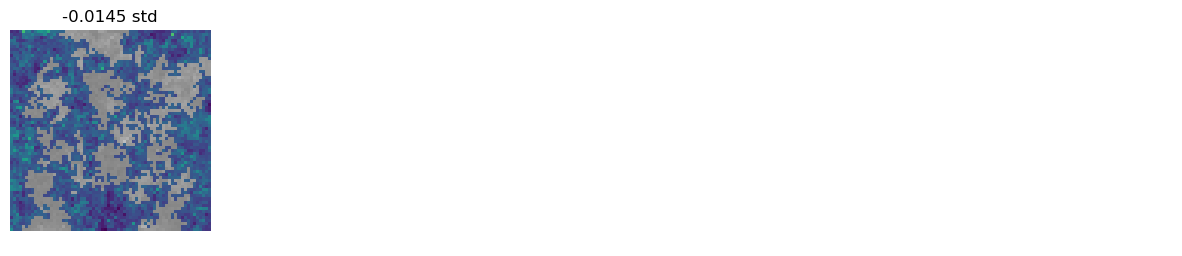

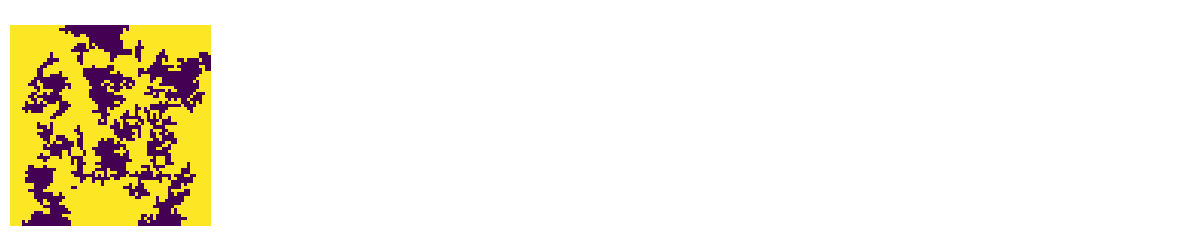

4021
1.0 0.0


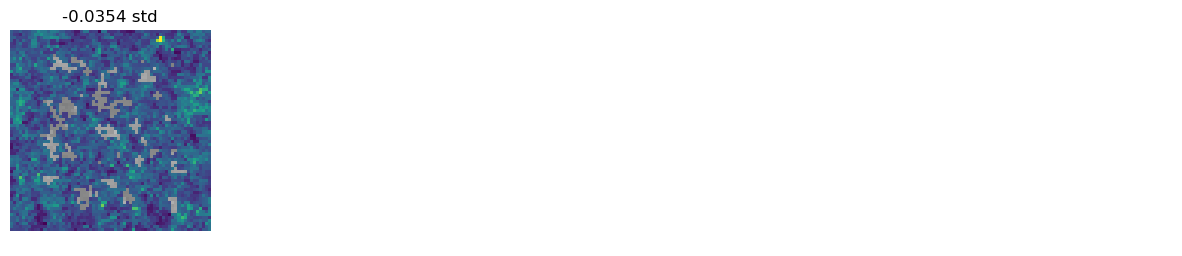

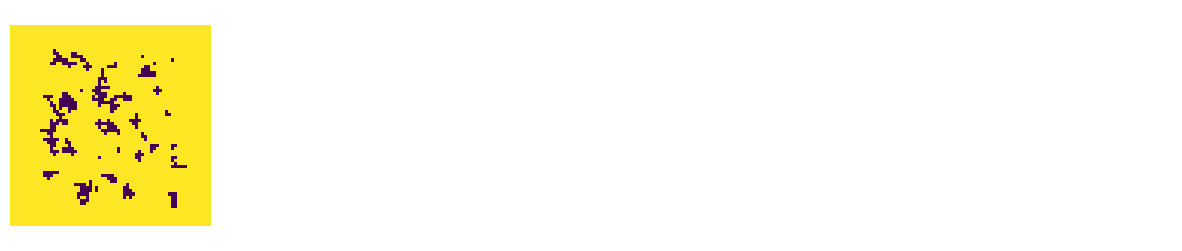

3557
1.0 0.0
3668
1.0 0.0


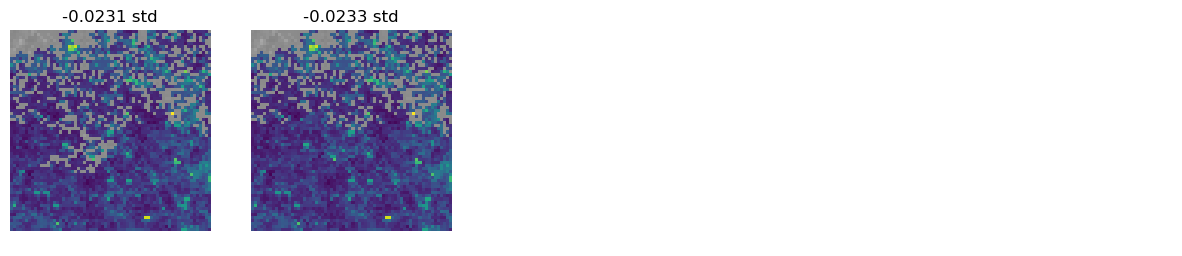

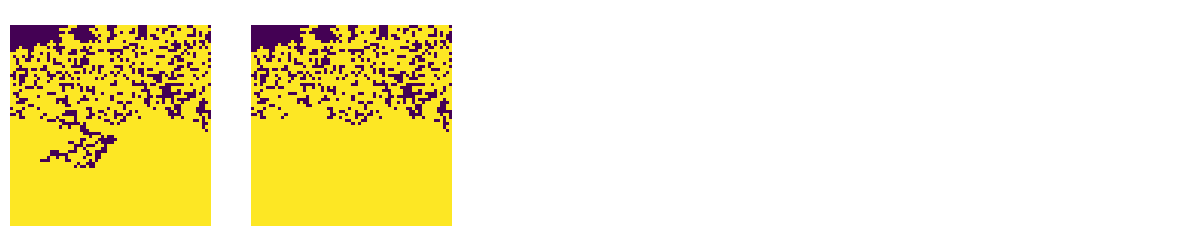

3557
1.0 0.0
3668
1.0 0.0


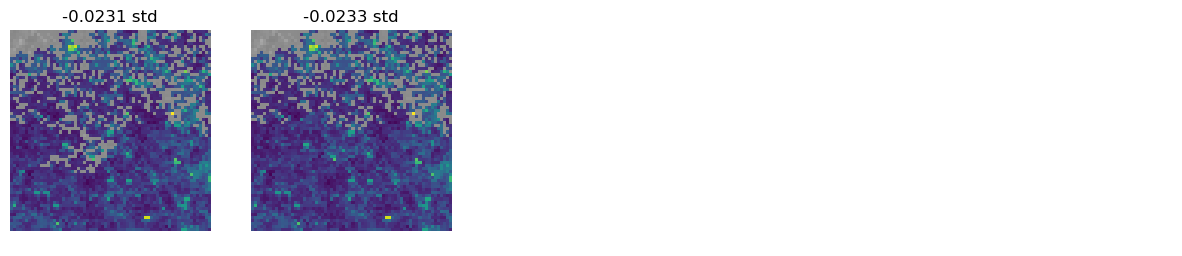

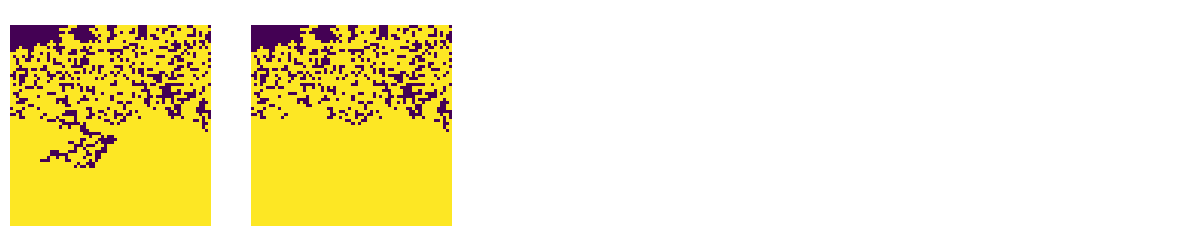

3713
1.0 0.0


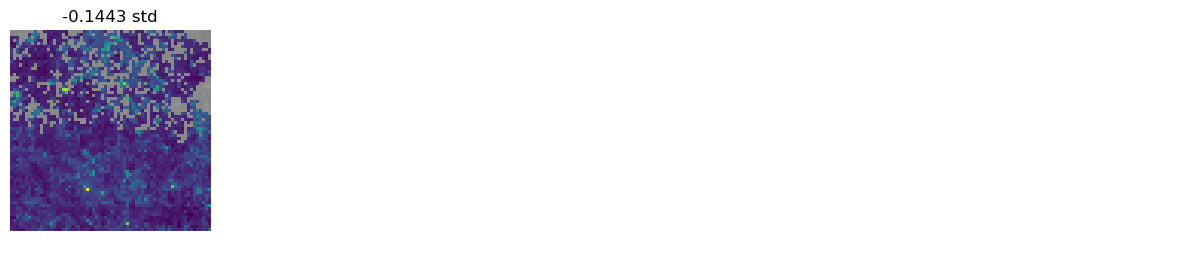

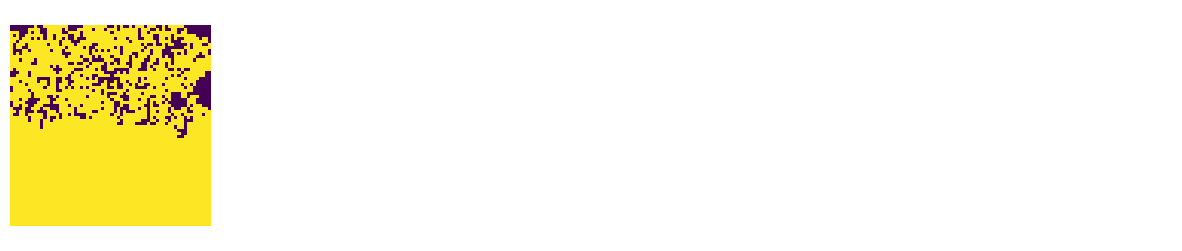

888
1.0 0.0
1390
1.0 0.0


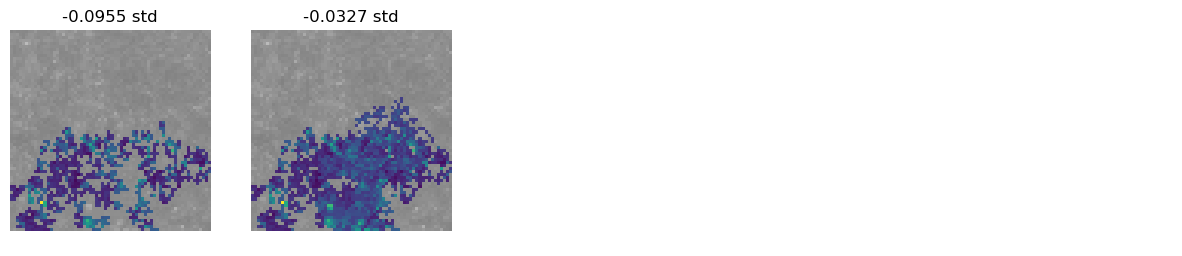

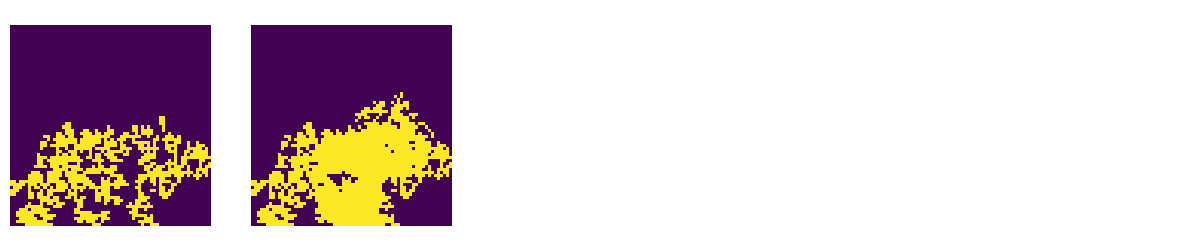

888
1.0 0.0
1390
1.0 0.0


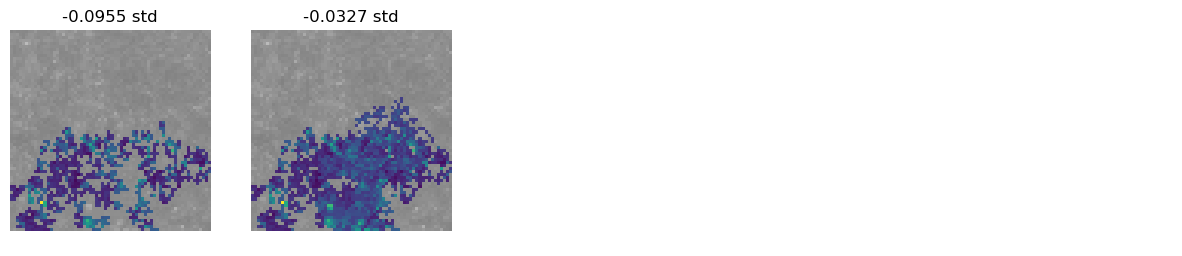

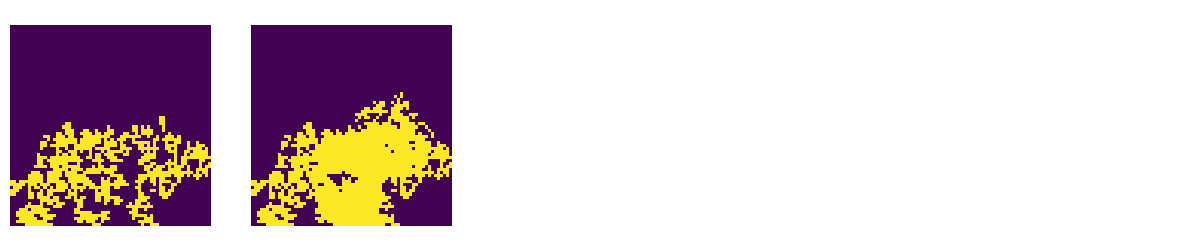

In [58]:
dark_weights_omega = []
dark_weights_sigma = []

dark_filenames = [tup_list[0][0] for tup_list in stats_all_comb.dark_subset]

count = 0
# for filename in tqdm(filenames):
for filename in tqdm(dark_filenames):
    try:
        data = torch.load(os.path.join(input_dir, filename), map_location=device)
    except:
        print(filename)
        continue
    image = data['image']
    label = data['label']
    logits = data['logits']
    unique_masks = [(unique_mask > 0.5).float() for unique_mask in data['unique_masks']]
    summed_weights = data['summed_weights']
    mean_logits = data['mean_logits']
    
    # stats_single = Stats()
    # stats_single.image = image
    # stats_single.label = label
    # stats_single.unique_masks = unique_masks
    # stats_single.summed_weights = summed_weights
    # stats_single.mean_logits = mean_logits
    
    for i in range(len(unique_masks)):
        k = tuple([filename, i])
        img, label, mask, mask_weight, pred = image, label, unique_masks[i], summed_weights[i], mean_logits[i]
        img_pth = img
        mask_pth = mask #torch.from_numpy(mask)
        masked_img = img_pth*(mask_pth > 1e-4)

        VERBOSE = False
        outputs = []


        DARK_THRESHOLD = 0
        BRIGHT_THRESHOLD = 2

        sigma = img_pth.std()
        bright_pixels = (img_pth > 2*sigma).sum()
        # total = img_pth.numel()
        #     if i == 0: 
        #         print(bright_pixels, bright_pixels/total)
        frac_bright_bhuv = (masked_img > 2*sigma).sum()/bright_pixels
        frac_bright_wong = (masked_img > 2*sigma).sum()/((mask_pth > 1e-4).sum())

        mask_intensity = (masked_img.squeeze()[(mask_pth > 1e-4)].mean())
        
        if mask_intensity < DARK_THRESHOLD*sigma:
            dark_weights_omega.append(mask_weight[0].item())
            dark_weights_sigma.append(mask_weight[1].item())
            if count < 10:
                show_img_seg_plot(image, label, unique_masks, summed_weights, mean_logits)
                count += 1

In [59]:
min(dark_weights_omega), max(dark_weights_omega), min(dark_weights_sigma), max(dark_weights_sigma)

(0.0, 1.0, 0.0, 1.0)

In [60]:
len(stats_all)

10000

In [61]:
## result!!

len(dark_weights_omega), len(dark_weights_sigma), len(bright_weights_omega), len(bright_weights_sigma)

(8180, 8180, 591, 591)

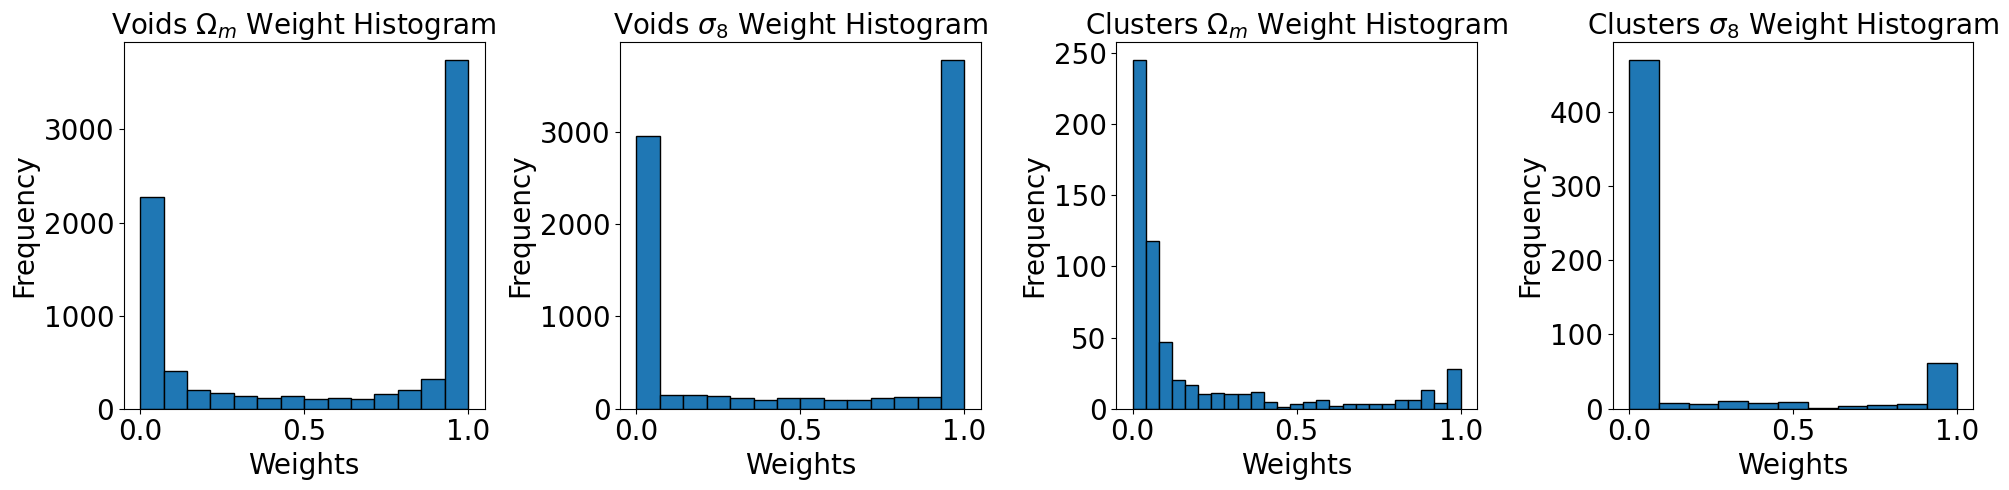

In [62]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

os.makedirs('cosmogrid_vis', exist_ok=True)

# Plot histogram
axs[0].hist(dark_weights_omega, bins='auto', edgecolor='black')  # bins='auto' will choose an optimal number of bins
# x_min, x_max = min(preds_all_omega), max(preds_all_omega)
# ticks_interval = 0.03  # Define your desired interval
# x_ticks = np.arange(x_min, x_max + ticks_interval, ticks_interval)
# axs[0][0].xticks(x_ticks, rotation=45)  # rotation is optional, for better readability if ticks are close
axs[0].set_title(r'Voids $\Omega_m$ Weight Histogram', fontsize=20)
axs[0].set_xlabel("Weights", fontsize=20)
axs[0].set_ylabel("Frequency", fontsize=20)
axs[0].tick_params(axis='x', labelsize=20)
axs[0].tick_params(axis='y', labelsize=20)

# Plot histogram
axs[1].hist(dark_weights_sigma, bins='auto', edgecolor='black')  # bins='auto' will choose an optimal number of bins
# x_min, x_max = min(preds_all_sigma8), max(preds_all_sigma8)
# ticks_interval = 0.03  # Define your desired interval
# x_ticks = np.arange(x_min, x_max + ticks_interval, ticks_interval)
# axs[0][1].xticks(x_ticks, rotation=45)  # rotation is optional, for better readability if ticks are close
axs[1].set_title(r"Voids $\sigma_8$ Weight Histogram", fontsize=20)
axs[1].set_xlabel("Weights", fontsize=20)
axs[1].set_ylabel("Frequency", fontsize=20)
axs[1].tick_params(axis='x', labelsize=20)
axs[1].tick_params(axis='y', labelsize=20)

 # Plot histogram
axs[2].hist(bright_weights_omega, bins='auto', edgecolor='black')  # bins='auto' will choose an optimal number of bins
# x_min, x_max = min(labels_all_omega), max(labels_all_omega)
# ticks_interval = 0.03  # Define your desired interval
# x_ticks = np.arange(x_min, x_max + ticks_interval, ticks_interval)
# axs[0][0].xticks(x_ticks, rotation=45)  # rotation is optional, for better readability if ticks are close
axs[2].set_title(r'Clusters $\Omega_m$ Weight Histogram', fontsize=20)
axs[2].set_xlabel("Weights", fontsize=20)
axs[2].set_ylabel("Frequency", fontsize=20)
axs[2].tick_params(axis='x', labelsize=20)
axs[2].tick_params(axis='y', labelsize=20)

# Plot histogram
axs[3].hist(bright_weights_sigma, bins='auto', edgecolor='black')  # bins='auto' will choose an optimal number of bins
# x_min, x_max = min(labels_all_sigma8), max(labels_all_sigma8)
# ticks_interval = 0.03  # Define your desired interval
# x_ticks = np.arange(x_min, x_max + ticks_interval, ticks_interval)
# axs[0][1].xticks(x_ticks, rotation=45)  # rotation is optional, for better readability if ticks are close
axs[3].set_title(r"Clusters $\sigma_8$ Weight Histogram", fontsize=20)
axs[3].set_xlabel("Weights", fontsize=20)
axs[3].set_ylabel("Frequency", fontsize=20)
axs[3].tick_params(axis='x', labelsize=20)
axs[3].tick_params(axis='y', labelsize=20)

plt.tight_layout()
plt.savefig(os.path.join('cosmogrid_vis', f'dark_bright_weight_hist.png'))
plt.show()
os.makedirs('cosmogrid_vis', exist_ok=True)

plt.close()

# plt.tight_layout()

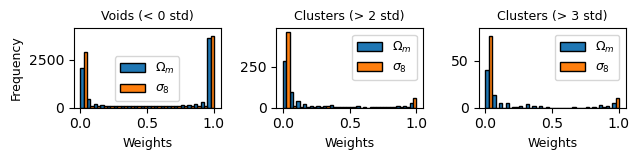

In [78]:
# Adjusting the plots to scale the y-axis separately for voids and clusters

# Create histograms without plotting to get the bin counts and edges
count_dark_omega, bins_dark_omega = np.histogram(dark_weights_omega, bins=20) #'auto')
count_dark_sigma, bins_dark_sigma = np.histogram(dark_weights_sigma, bins=20) #'auto')
count_bright_omega, bins_bright_omega = np.histogram(bright_weights_omega, bins=20) #'auto')
count_bright_sigma, bins_bright_sigma = np.histogram(bright_weights_sigma, bins=20) #'auto')
count_bright_omega_std3, bins_bright_omega_std3 = np.histogram(bright_weights_omega_std3, bins=20) #'auto')
count_bright_sigma_std3, bins_bright_sigma_std3 = np.histogram(bright_weights_sigma_std3, bins=20) #'auto')

# Calculate bin centers
bins_centers_dark_omega = (bins_dark_omega[:-1] + bins_dark_omega[1:]) / 2
bins_centers_dark_sigma = (bins_dark_sigma[:-1] + bins_dark_sigma[1:]) / 2
bins_centers_bright_omega = (bins_bright_omega[:-1] + bins_bright_omega[1:]) / 2
bins_centers_bright_sigma = (bins_bright_sigma[:-1] + bins_bright_sigma[1:]) / 2
bins_centers_bright_omega_std3 = (bins_bright_omega_std3[:-1] + bins_bright_omega_std3[1:]) / 2
bins_centers_bright_sigma_std3 = (bins_bright_sigma_std3[:-1] + bins_bright_sigma_std3[1:]) / 2


fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(6.5, 1.7))

# Re-calculate width for bars
width = np.min(np.diff(bins_centers_dark_omega))/2

# Plot for Voids with separate y-axis scaling
axs[0].bar(bins_centers_dark_omega - width/2, count_dark_omega, width=width, label=r'$\Omega_m$', edgecolor='black')
axs[0].bar(bins_centers_dark_sigma + width/2, count_dark_sigma, width=width, label=r'$\sigma_8$', edgecolor='black')
axs[0].set_title('Voids (< 0 std)', fontsize=9)
axs[0].set_xlabel("Weights", fontsize=9)
axs[0].set_ylabel("Frequency", fontsize=9)
axs[0].legend(fontsize=9)

# Adjust y-axis limit for Voids based on their counts
axs[0].set_ylim(0, max(count_dark_omega.max(), count_dark_sigma.max()) * 1.1)

# Plot for Clusters with separate y-axis scaling
axs[1].bar(bins_centers_bright_omega - width/2, count_bright_omega, width=width, label=r'$\Omega_m$', edgecolor='black')
axs[1].bar(bins_centers_bright_sigma + width/2, count_bright_sigma, width=width, label=r'$\sigma_8$', edgecolor='black')
axs[1].set_title('Clusters (> 2 std)', fontsize=9)
axs[1].set_xlabel("Weights", fontsize=9)
# axs[1].set_ylabel("Frequency", fontsize=20)  # Y-axis label is the same for both, so not repeated
axs[1].legend(fontsize=9)

# Adjust y-axis limit for Clusters based on their counts
axs[2].set_ylim(0, max(count_bright_omega_std3.max(), count_bright_sigma.max()) * 1.1)

# Plot for Clusters with separate y-axis scaling
axs[2].bar(bins_centers_bright_omega_std3 - width/2, count_bright_omega_std3, width=width, label=r'$\Omega_m$', edgecolor='black')
axs[2].bar(bins_centers_bright_sigma_std3 + width/2, count_bright_sigma_std3, width=width, label=r'$\sigma_8$', edgecolor='black')
axs[2].set_title('Clusters (> 3 std)', fontsize=9)
axs[2].set_xlabel("Weights", fontsize=9)
# axs[1].set_ylabel("Frequency", fontsize=20)  # Y-axis label is the same for both, so not repeated
axs[2].legend(fontsize=9)

# Adjust y-axis limit for Clusters based on their counts
axs[2].set_ylim(0, max(count_bright_omega_std3.max(), count_bright_sigma_std3.max()) * 1.1)


plt.tight_layout()

# Save the plot
plt.savefig(os.path.join('cosmogrid_vis', 'void_cluster_weight_hist_grouped_separate_y.pdf'), dpi=300, bbox_inches='tight', pad_inches=0)

plt.show()


In [74]:
sum([n for n in dark_weights_omega if n == 1]), sum([n for n in dark_weights_sigma if n == 1]), sum([n for n in bright_weights_omega if n == 1]), sum([n for n in bright_weights_sigma if n == 1])

(2528.0, 3444.0, 26.0, 59.0)

In [75]:
sum([n for n in bright_weights_omega_std3 if n == 1]), sum([n for n in bright_weights_sigma_std3 if n == 1])

(4.0, 10.0)

In [64]:
round(np.mean(dark_weights_omega), 3), round(np.mean(dark_weights_sigma), 3), round(np.mean(bright_weights_omega), 3), round(np.mean(bright_weights_sigma), 3)

(0.588, 0.548, 0.187, 0.151)

In [65]:
round(np.mean(bright_weights_omega_std3), 3), round(np.mean(bright_weights_sigma_std3), 3)

(0.215, 0.126)

In [66]:
len(dark_weights_omega), total_num_masks

(8180, 23302)

In [69]:
dark_weights_omega_avg = np.sum(dark_weights_omega) / total_num_masks
dark_weights_sigma_avg = np.sum(dark_weights_sigma) / total_num_masks
bright_weights_omega_avg = np.sum(bright_weights_omega) / total_num_masks
bright_weights_sigma_avg = np.sum(bright_weights_sigma) / total_num_masks
bright_weights_omega_avg_std3 = np.sum(bright_weights_omega_std3) / total_num_masks
bright_weights_sigma_avg_std3 = np.sum(bright_weights_sigma_std3) / total_num_masks

In [70]:
print('dark_weights_omega_avg', round(dark_weights_omega_avg * 100, 2))
print('dark_weights_sigma_avg', round(dark_weights_sigma_avg * 100, 2))
print('bright_weights_omega_avg', round(bright_weights_omega_avg * 100, 2))
print('bright_weights_sigma_avg', round(bright_weights_sigma_avg * 100, 2))
print('bright_weights_omega_avg_std3', round(bright_weights_omega_avg_std3 * 100, 2))
print('bright_weights_sigma_avg_std3', round(bright_weights_sigma_avg_std3 * 100, 2))

dark_weights_omega_avg 20.63
dark_weights_sigma_avg 19.23
bright_weights_omega_avg 0.48
bright_weights_sigma_avg 0.38
bright_weights_omega_avg_std3 0.08
bright_weights_sigma_avg_std3 0.05


In [80]:
stats_all_comb.bright_subset;

In [81]:
[stat.__dict__ for stat in stats_all[0:3]];

In [82]:
ranges = []
for stat in stats_all:
    # print(min(stat.mask_intensities).item(), max(stat.mask_intensities).item())
    range_curr = max(stat.stds).item() - min(stat.stds).item()
    ranges.append(range_curr)

In [83]:
min_stds = []
for stat in stats_all:
    # print(min(stat.mask_intensities).item(), max(stat.mask_intensities).item())
    min_stds.append(min(stat.stds).item())

In [84]:
max(ranges)

10.900943998247385

In [85]:
min(min_stds)

-1.1107748746871948

In [86]:
ranges.index(max(ranges))

449

In [87]:
stats_all[ranges.index(max(ranges))].__dict__

{'image': tensor([[[-0.0029, -0.0028, -0.0011,  ..., -0.0002,  0.0040, -0.0029],
          [-0.0029, -0.0036, -0.0060,  ..., -0.0002,  0.0005, -0.0012],
          [ 0.0027, -0.0037, -0.0060,  ...,  0.0007, -0.0004, -0.0012],
          ...,
          [ 0.0029, -0.0012, -0.0021,  ..., -0.0042, -0.0030, -0.0048],
          [-0.0016, -0.0036, -0.0047,  ..., -0.0018, -0.0030, -0.0066],
          [-0.0008, -0.0036, -0.0059,  ...,  0.0005, -0.0056,  0.0007]]],
        device='cuda:0'),
 'label': tensor([0.2641, 0.4898], device='cuda:0'),
 'unique_masks': [tensor([[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0'),
  tensor([[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1

In [88]:
len(ranges), len(stats_all)

(10000, 10000)

In [89]:
from matplotlib.font_manager import fontManager

available_fonts = [f.name for f in fontManager.ttflist if os.path.exists(f.fname)]


In [90]:
available_fonts;

In [91]:
for i, k in enumerate(darkhighweight_omega_subset[:10]): 
    v = mask_id_feat_dict[k]
    img, label, mask, mask_weight, pred = v
    
    img_pth = torch.from_numpy(img)
    mask_pth = mask.cpu()  #torch.from_numpy(mask)
    # print('img', img.shape)
    # print('mask_pth', mask_pth.shape)
    masked_img = img_pth*(mask_pth > 1e-4)
    # print(mask_weight.tolist())
    # print(mask)
    map_plotter(img[0], mask_pth.numpy(), type='dim')
    mask_weight_show = [round(num, 2) for num in mask_weight.cpu().numpy().tolist()]
    pred_show = [round(num, 2) for num in pred.cpu().numpy().tolist()]
    label_show = [round(num, 2) for num in label]
    plt.title(f'darkhighweight_omega_subset\n{k[0]}\nWeight {mask_weight_show}\nPred {pred_show}\nLabel {label_show}')
    # plt.title('darkgoodloss_omega_subset')
    plt.savefig(os.path.join('cosmogrid_vis', f'darkhighweight_omega_subset_{i}.png'))
    plt.show()

NameError: name 'darkhighweight_omega_subset' is not defined

ran 6914
3
1.0 0.0
5
1.0 0.0
3480
1.0 0.0
3483
1.0 0.0


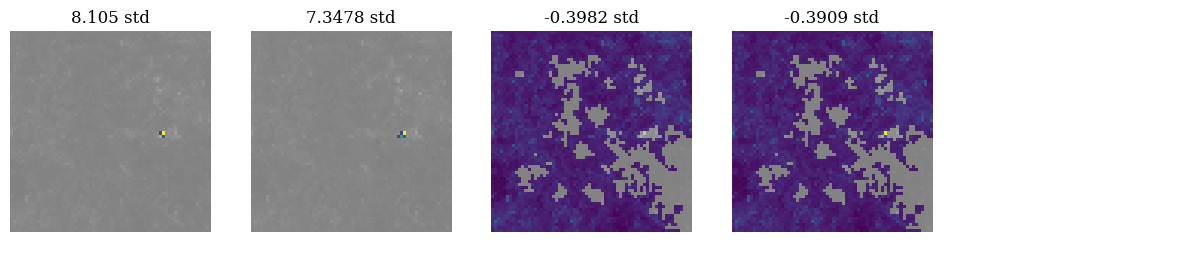

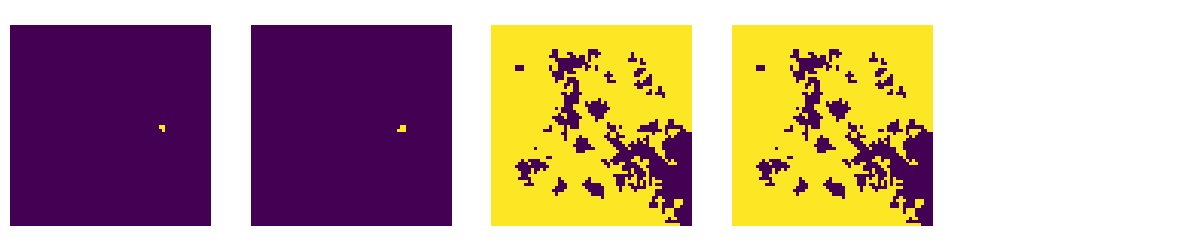

In [98]:
import matplotlib
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
matplotlib.rcParams['font.family'] = 'DejaVu Serif'

ran = np.argsort(ranges)[::-1][2]
print('ran', ran)
stat = stats_all[ran]
show_img_seg_plot(stat.image, stat.label, stat.unique_masks, stat.summed_weights, stat.mean_logits, save_dir=f'examples/{ran}')

1
1.0 0.0
4021
1.0 0.0


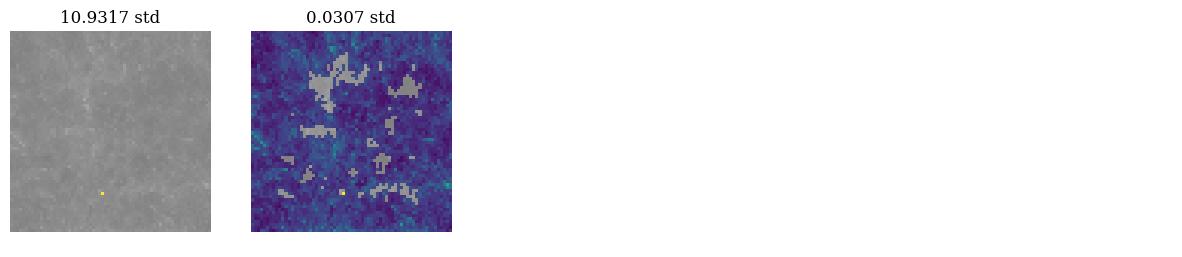

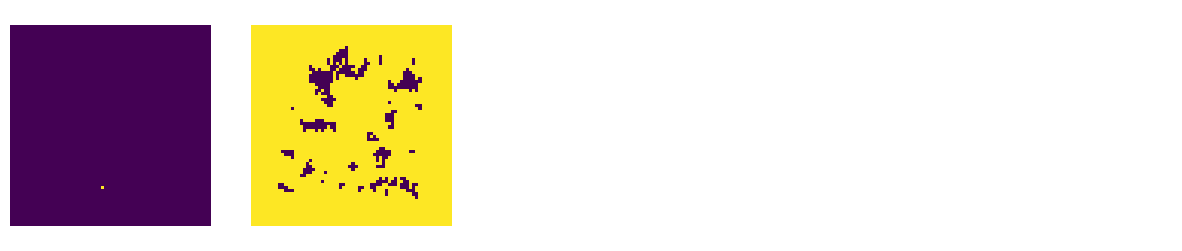

48
1.0 0.0
63
1.0 0.0
1
1.0 0.0


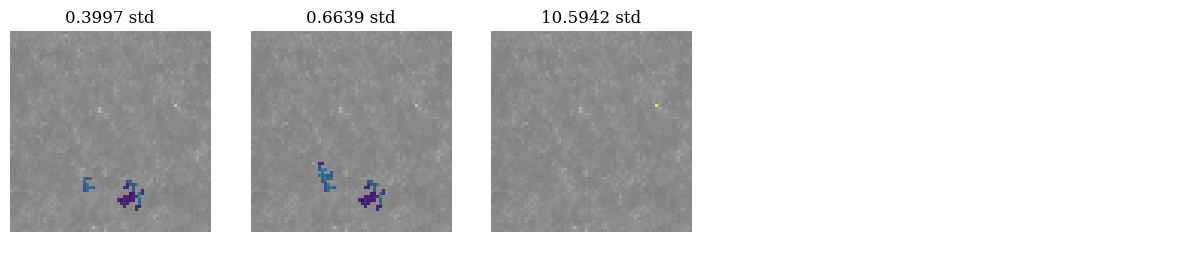

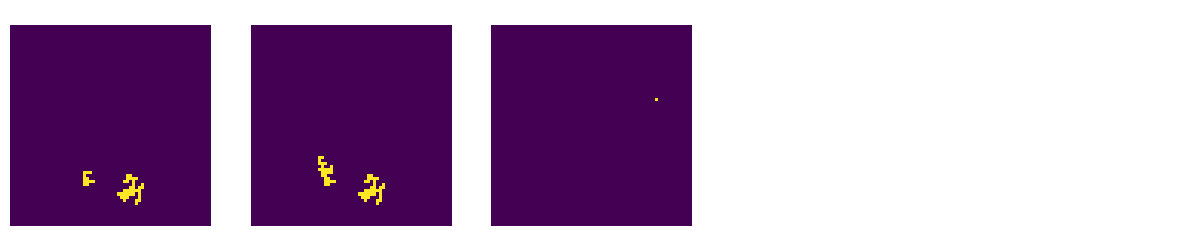

3
1.0 0.0
5
1.0 0.0
3480
1.0 0.0
3483
1.0 0.0


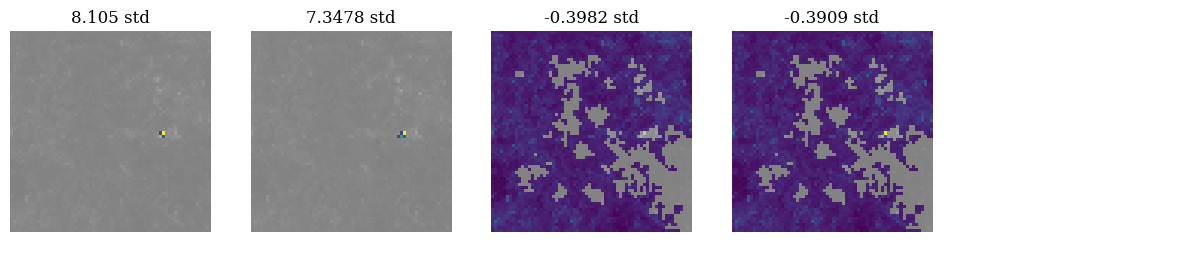

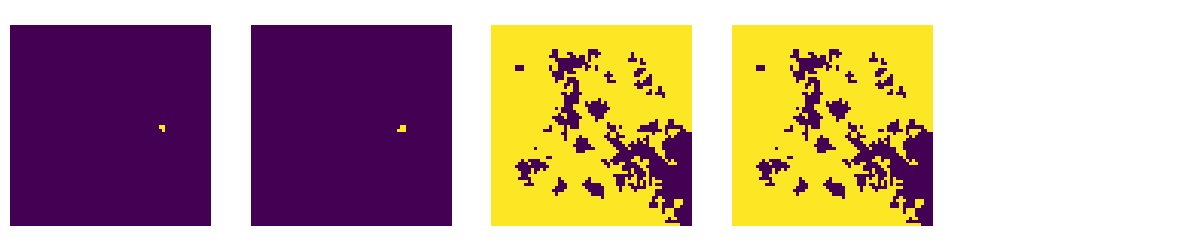

4
1.0 0.0
56
1.0 0.0
62
1.0 0.0
3377
1.0 0.0


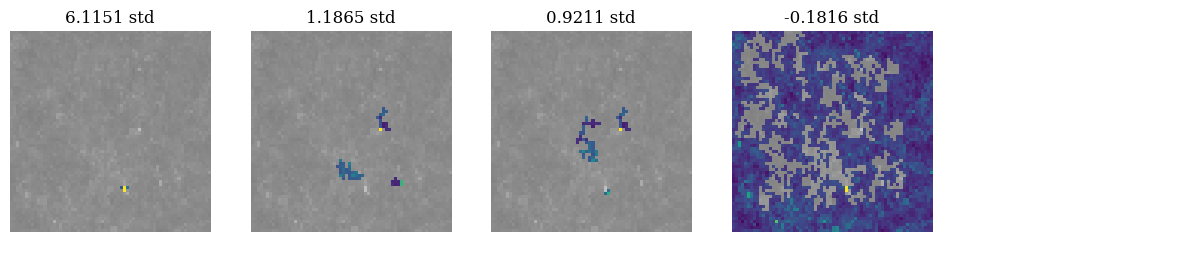

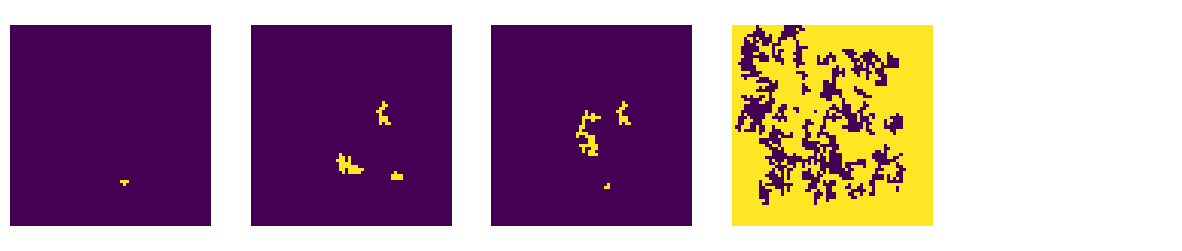

6
1.0 0.0
16
1.0 0.0
3646
1.0 0.0
3656
1.0 0.0


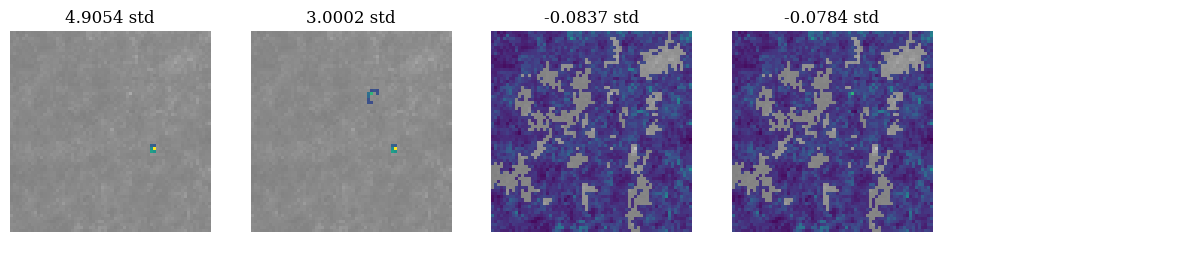

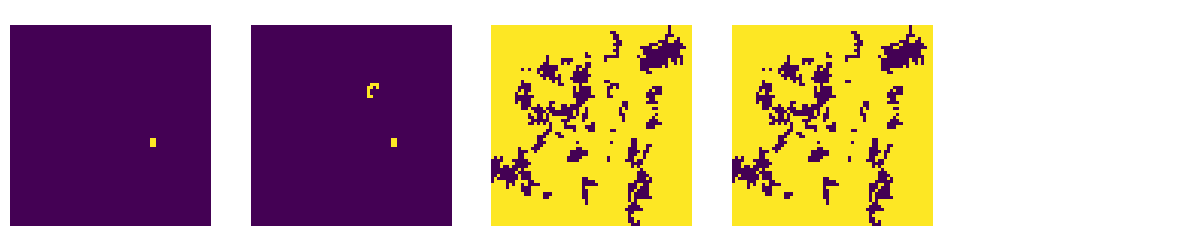

5
1.0 0.0
3358
1.0 0.0


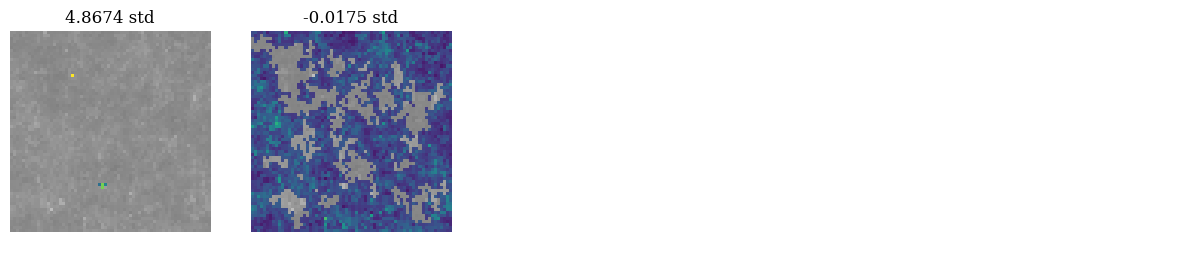

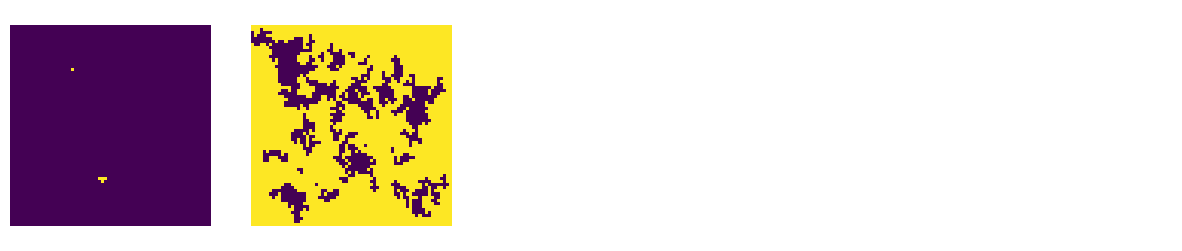

6
1.0 0.0
36
1.0 0.0
36
1.0 0.0
1744
1.0 0.0
2308
1.0 0.0
1711
1.0 0.0


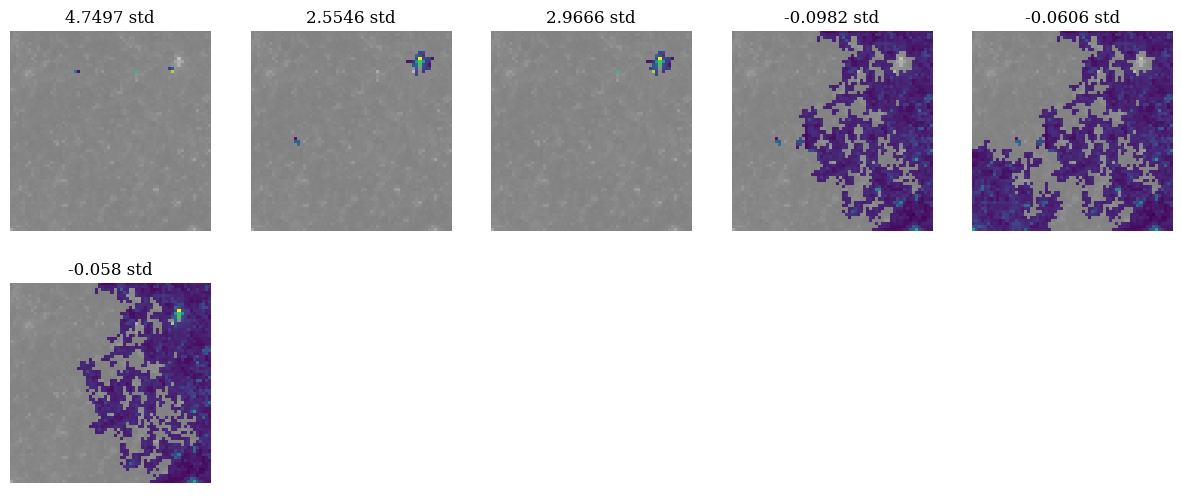

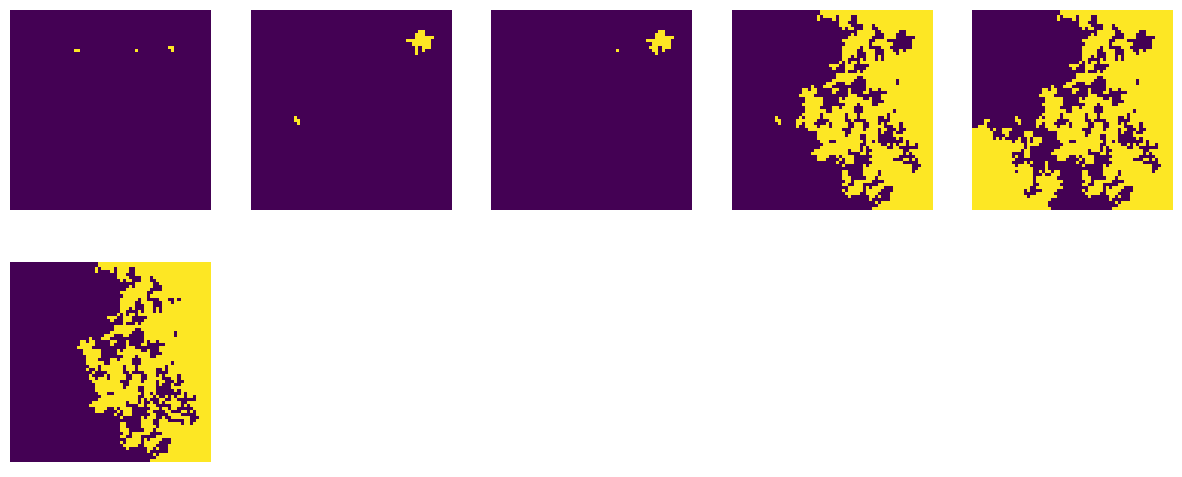

188
1.0 0.0
53
1.0 0.0
8
1.0 0.0
43
1.0 0.0
46
1.0 0.0
2764
1.0 0.0
2817
1.0 0.0
2802
1.0 0.0


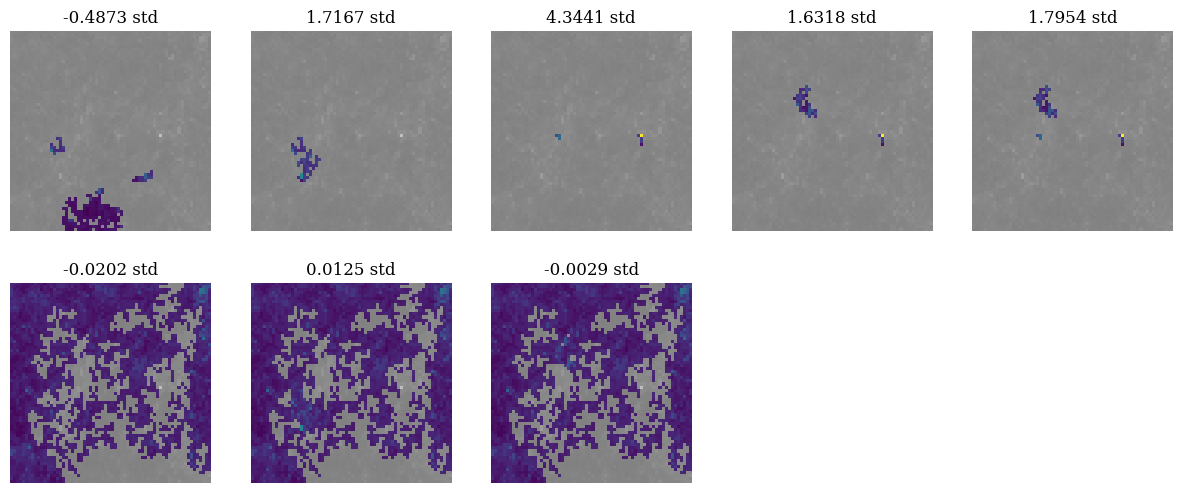

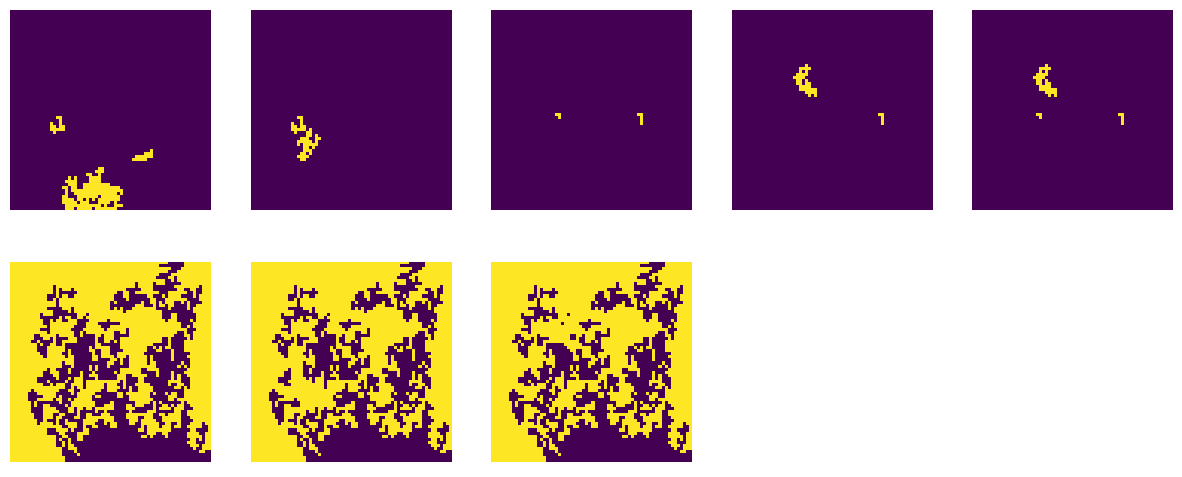

25
1.0 0.0
3555
1.0 0.0


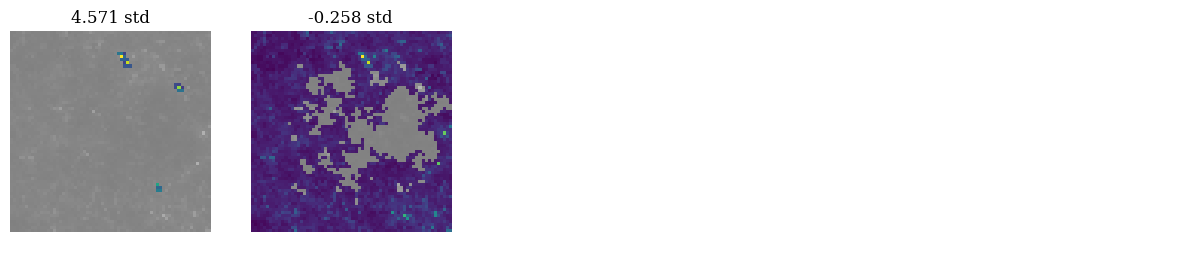

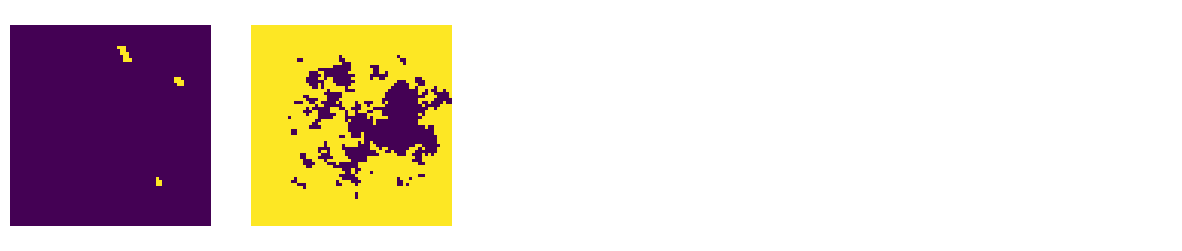

6
1.0 0.0
3125
1.0 0.0


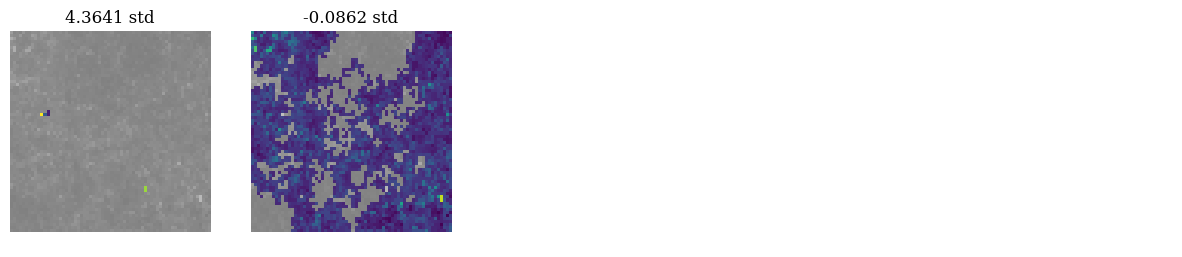

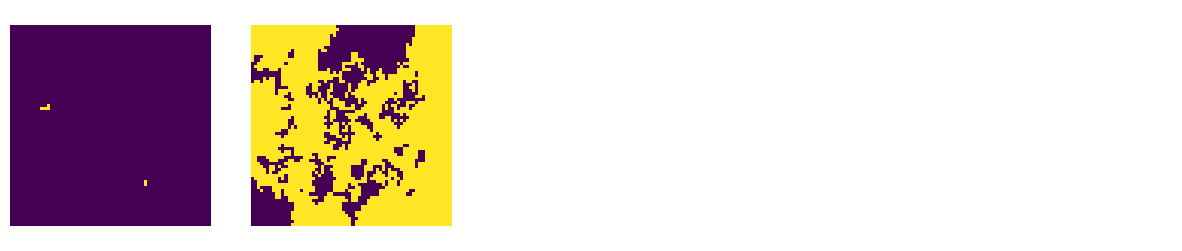

In [96]:
for ran in np.argsort(ranges)[::-1][:10]:
    stat = stats_all[ran]
    show_img_seg_plot(stat.image, stat.label, stat.unique_masks, stat.summed_weights, stat.mean_logits, save_dir=f'examples/{ran}')

178
1.0 0.0
145
1.0 0.0
181
1.0 0.0
3046
1.0 0.0
3112
1.0 0.0


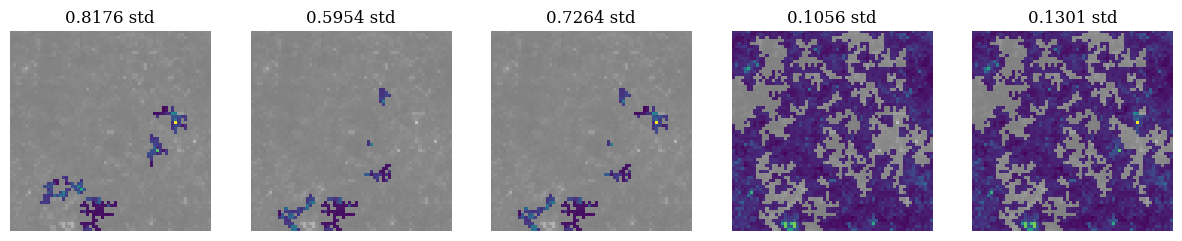

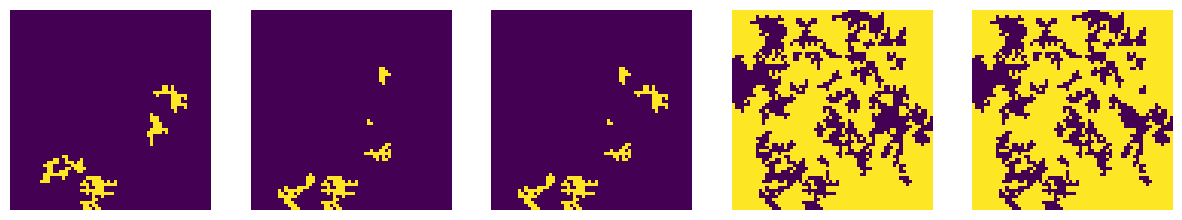

2541
1.0 0.0


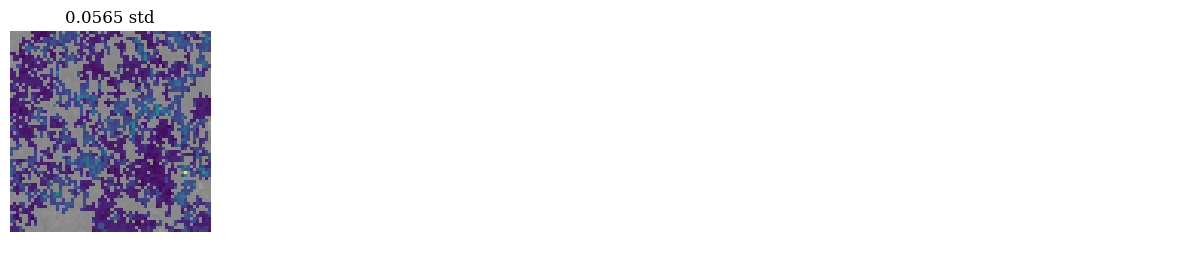

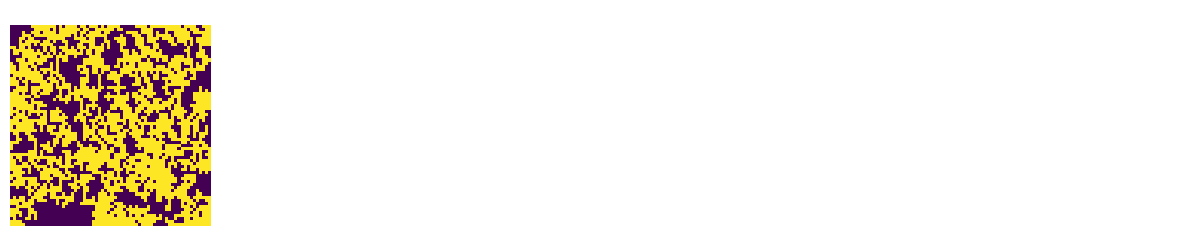

2756
1.0 0.0
3105
1.0 0.0


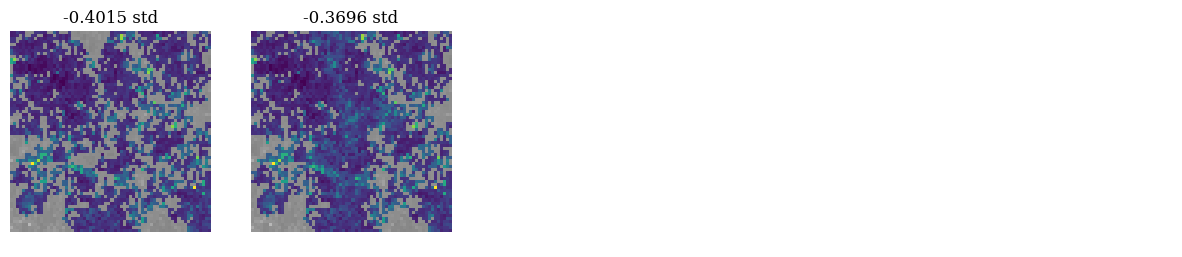

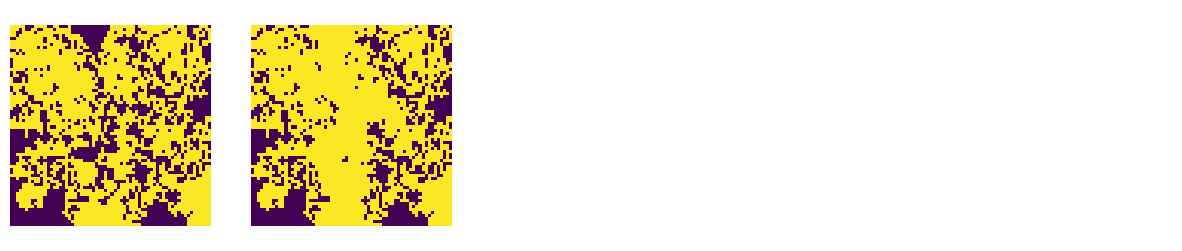

3541
1.0 0.0
3573
1.0 0.0


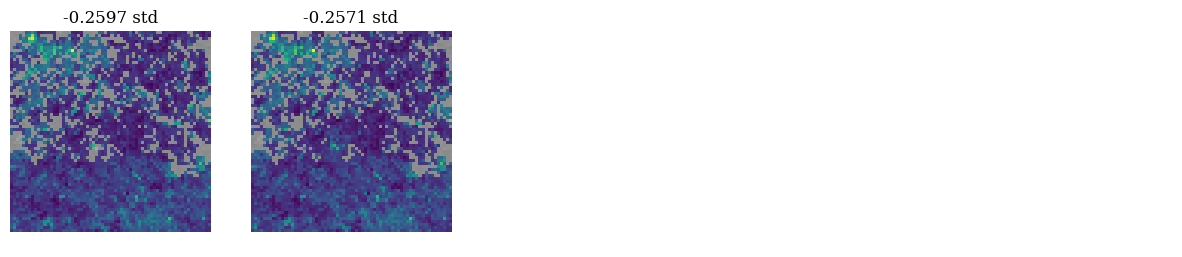

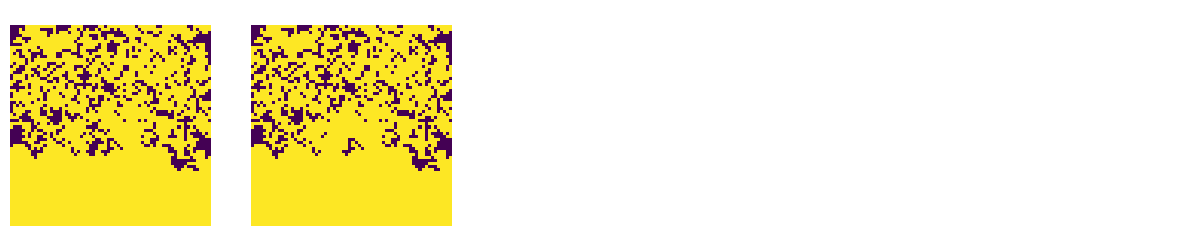

162
1.0 0.0
3639
1.0 0.0


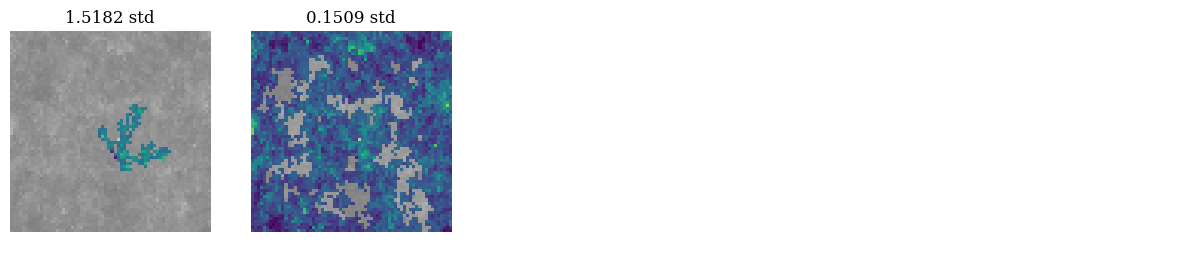

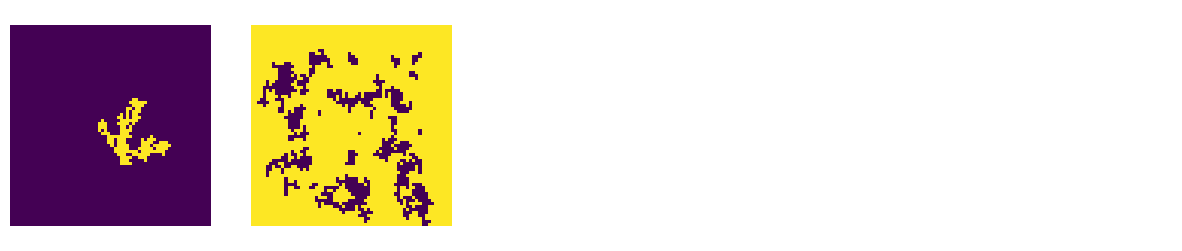

3465
1.0 0.0


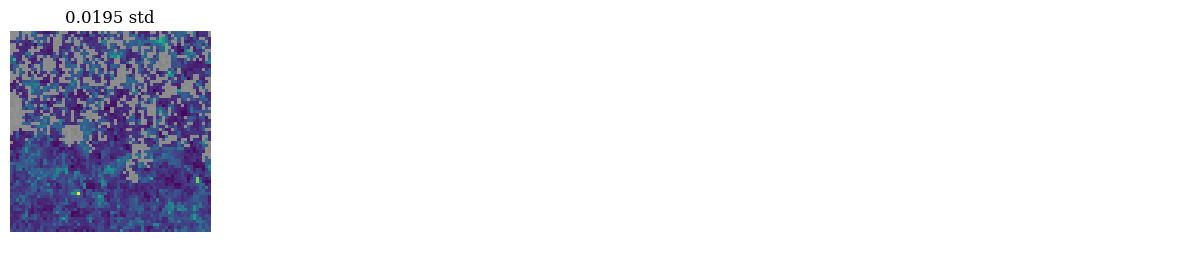

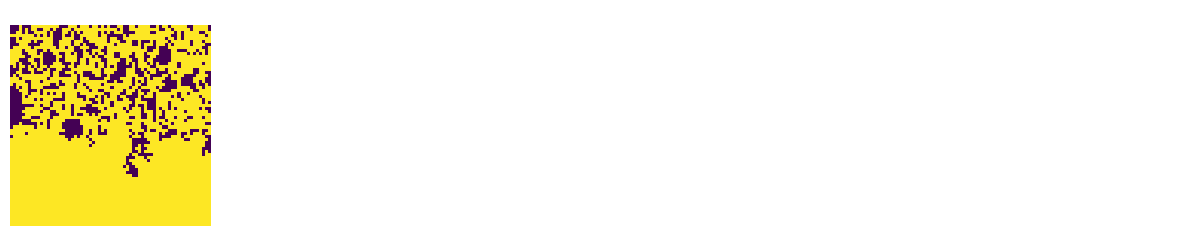

3213
1.0 0.0


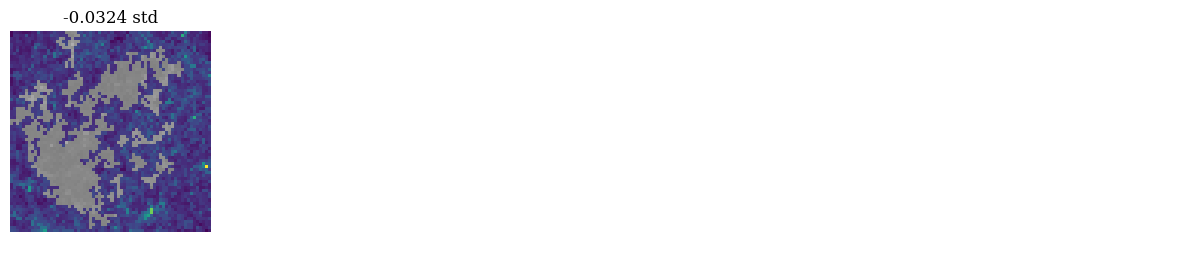

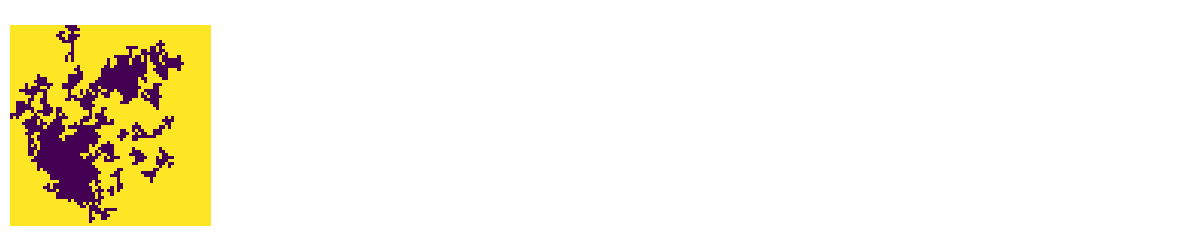

1343
1.0 0.0
1372
1.0 0.0
1378
1.0 0.0
2775
1.0 0.0


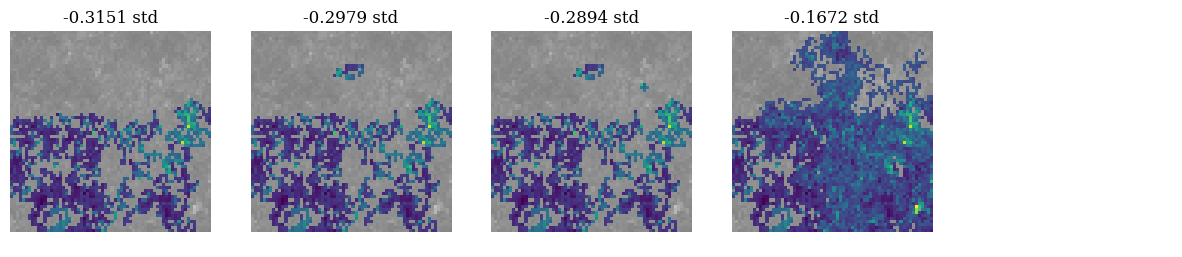

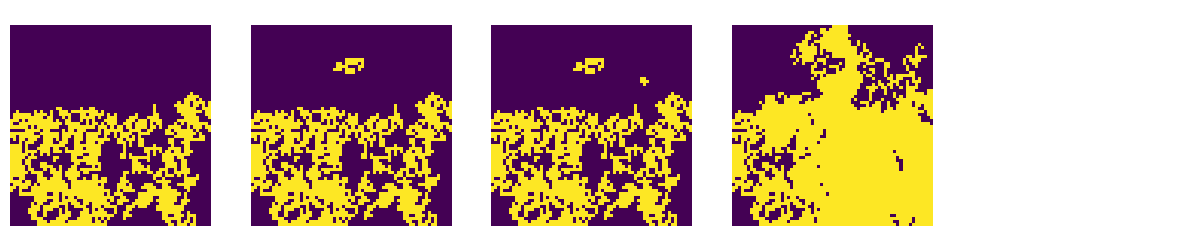

3510
1.0 0.0


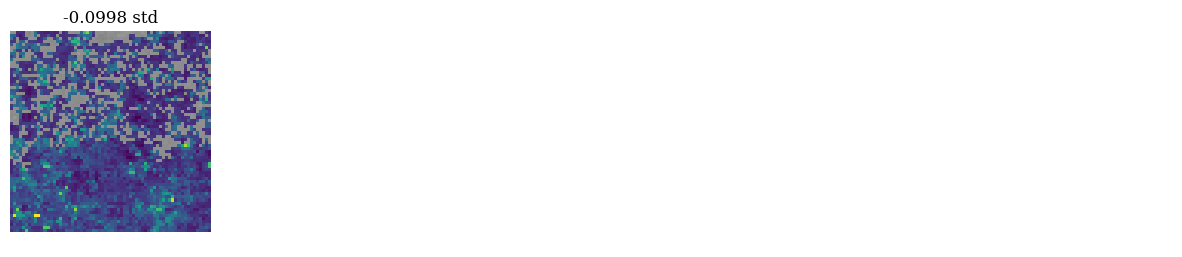

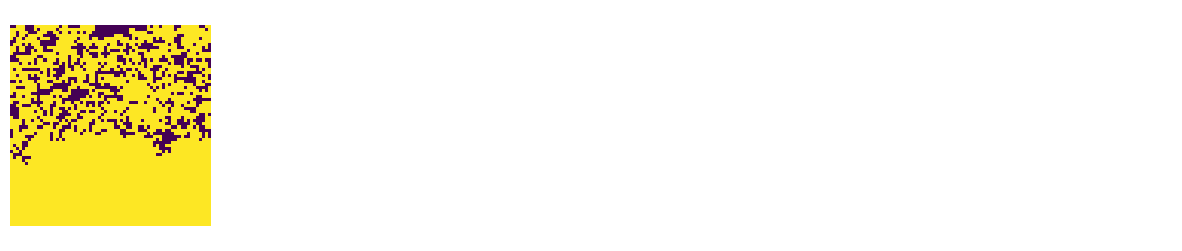

2750
1.0 0.0
3050
1.0 0.0


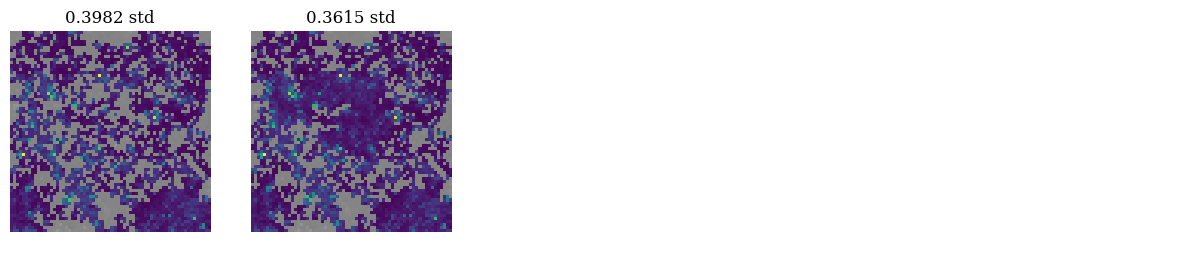

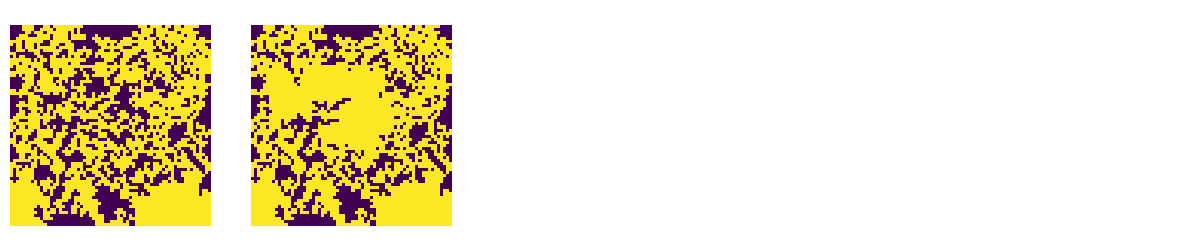

In [94]:
for filename in bright_filenames[-10:]:
    idx = int(filename.replace('.pt', ''))
    stat = stats_all[idx]
    show_img_seg_plot(stat.image, stat.label, stat.unique_masks, stat.summed_weights, stat.mean_logits)

9999
221
1.0 0.0


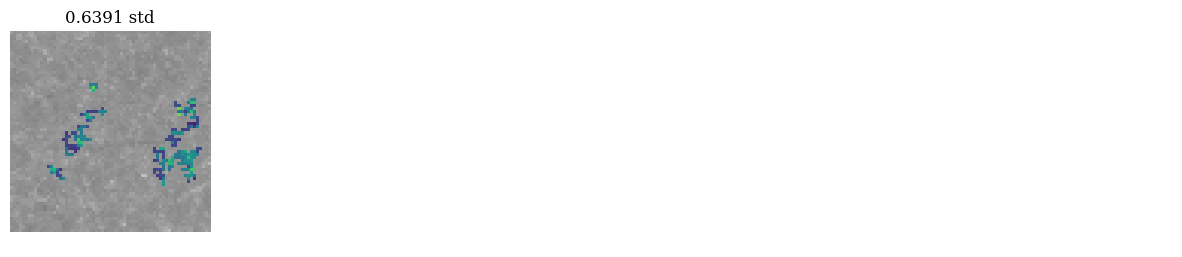

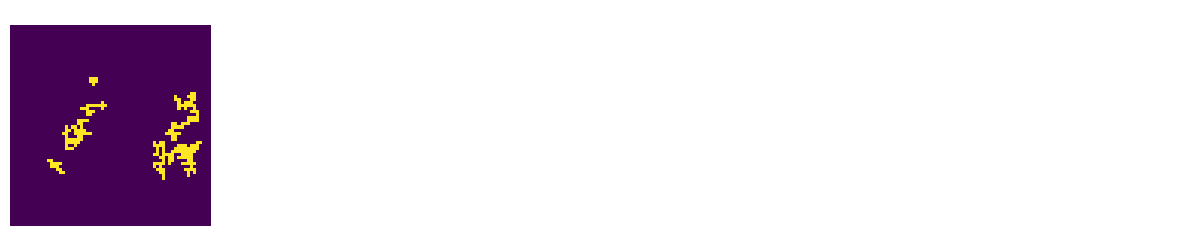

3329
21
1.0 0.0


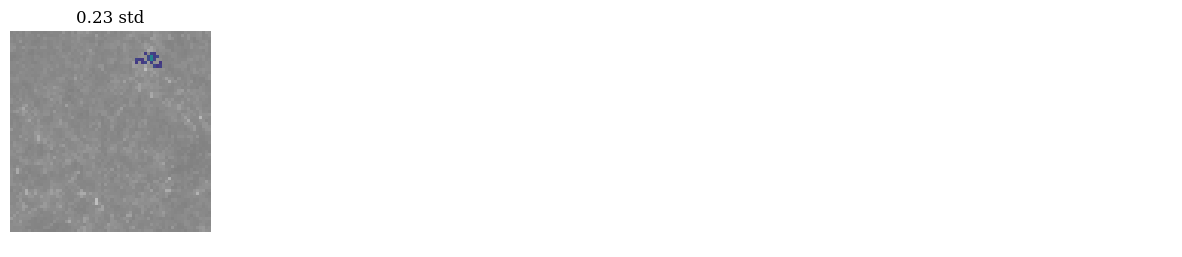

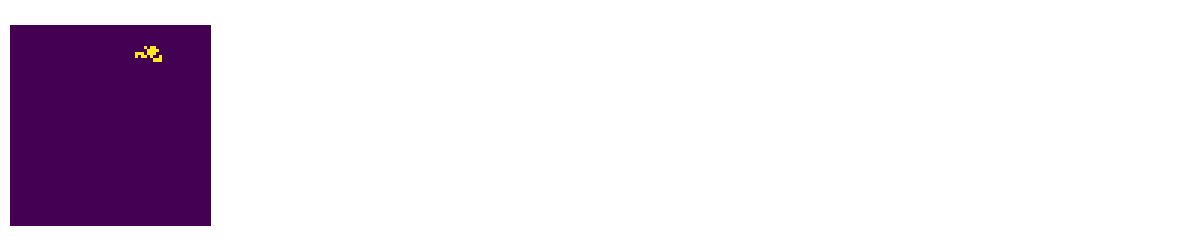

3336
3708
1.0 0.0


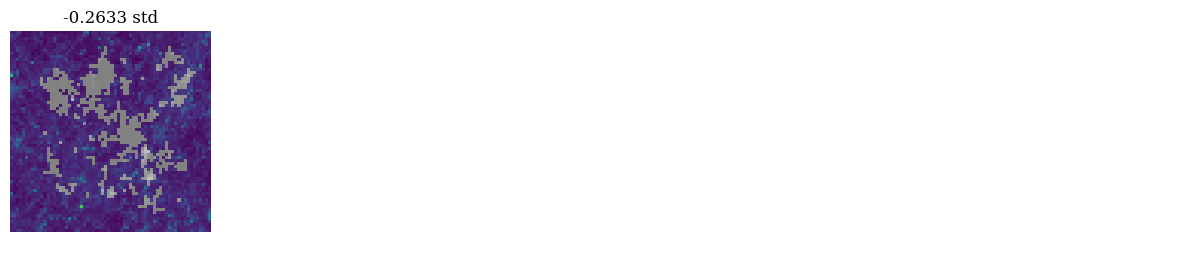

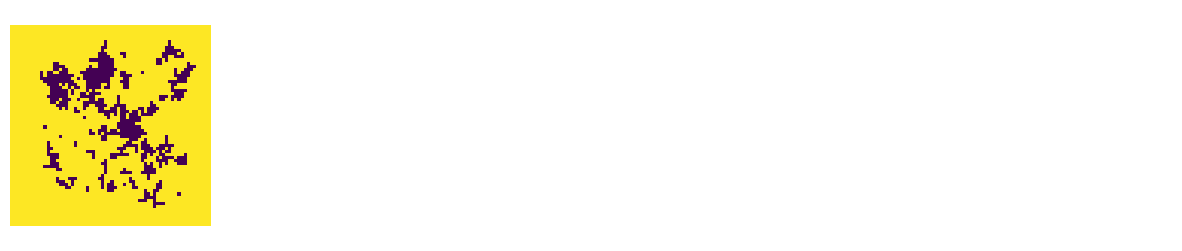

3335
683
1.0 0.0


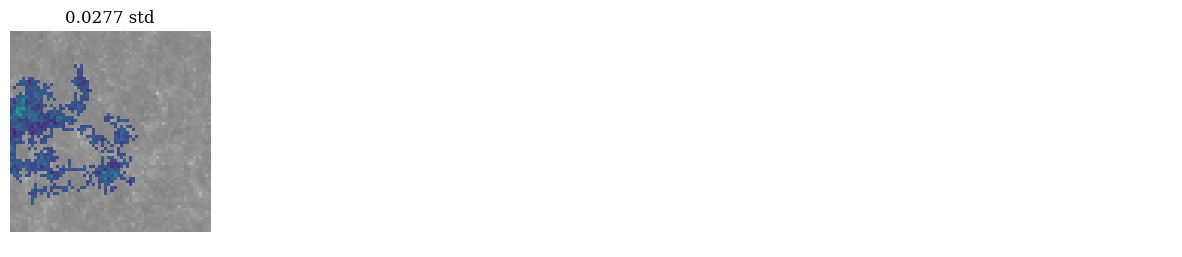

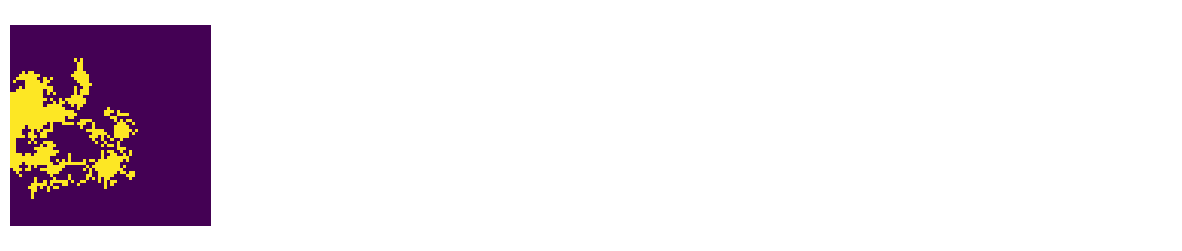

3334
3363
1.0 0.0


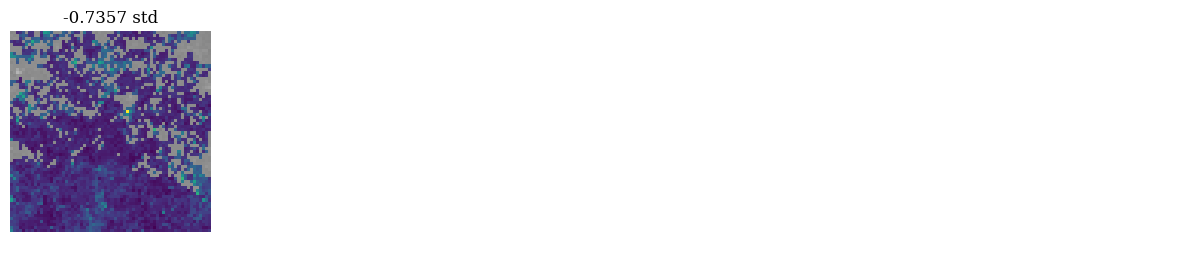

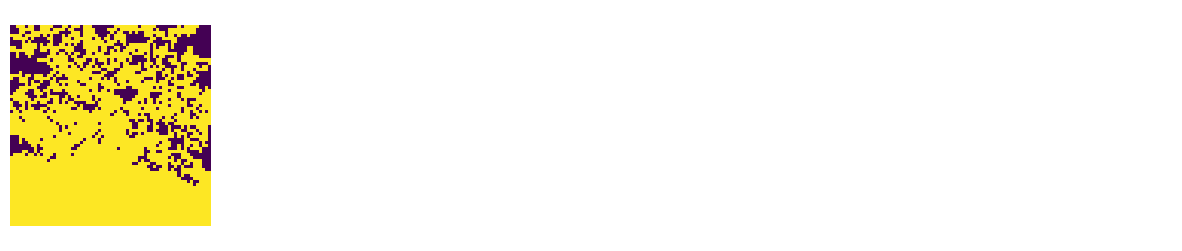

3333
244
1.0 0.0


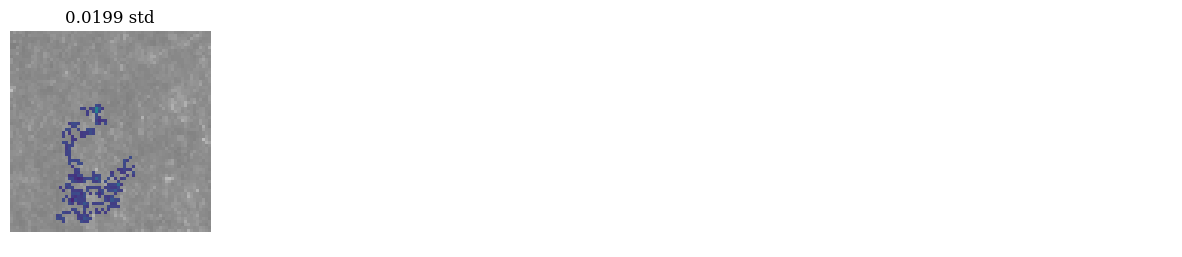

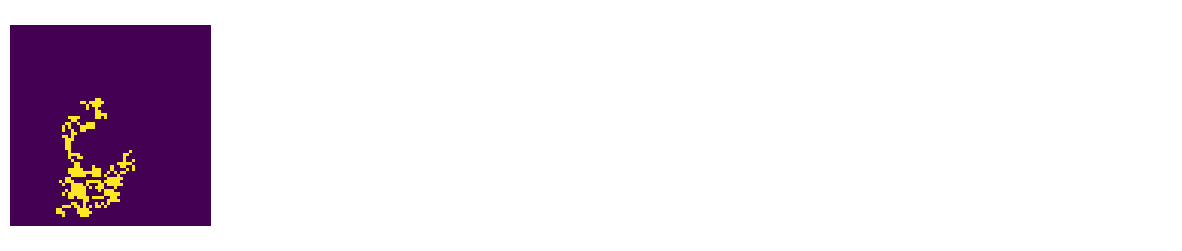

3332
94
1.0 0.0


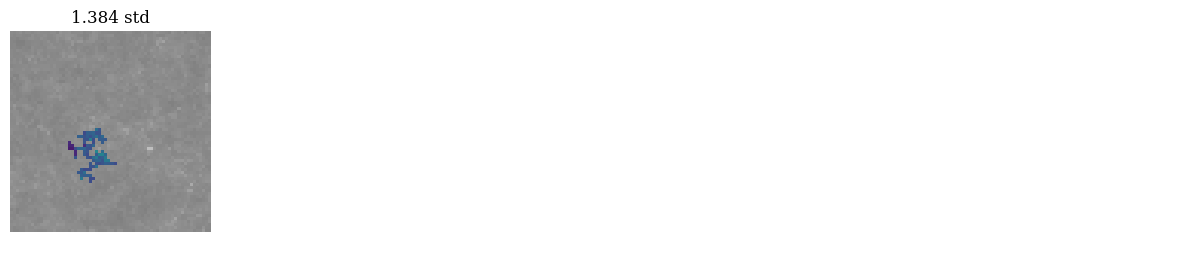

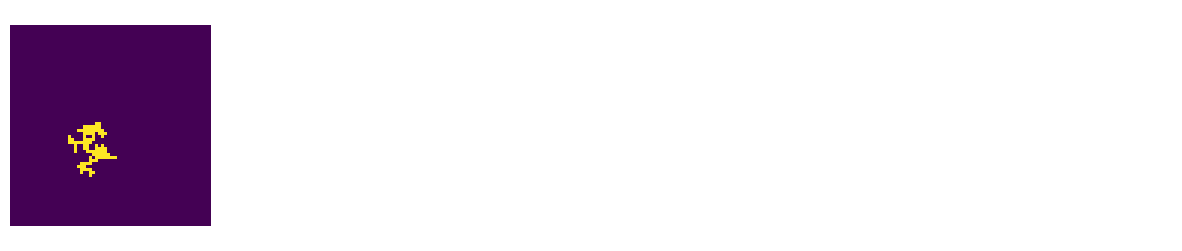

3331
3708
1.0 0.0


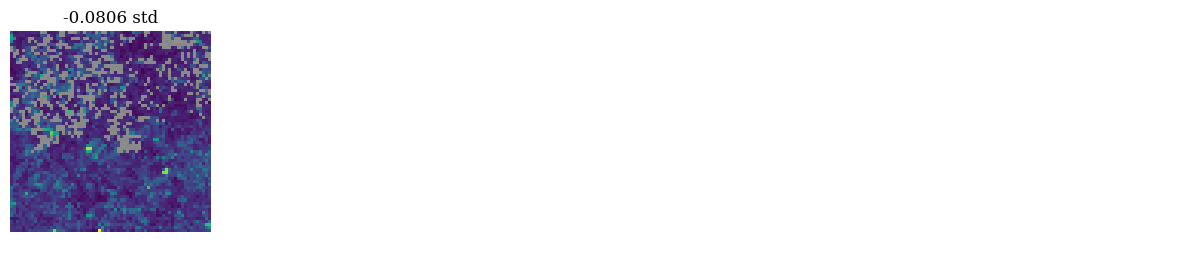

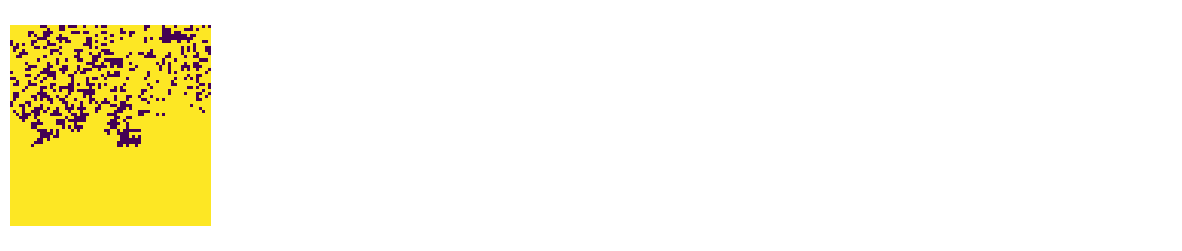

3330
3696
1.0 0.0


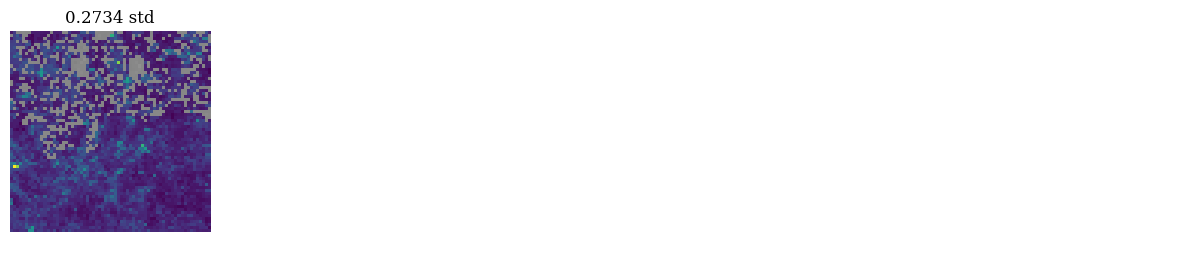

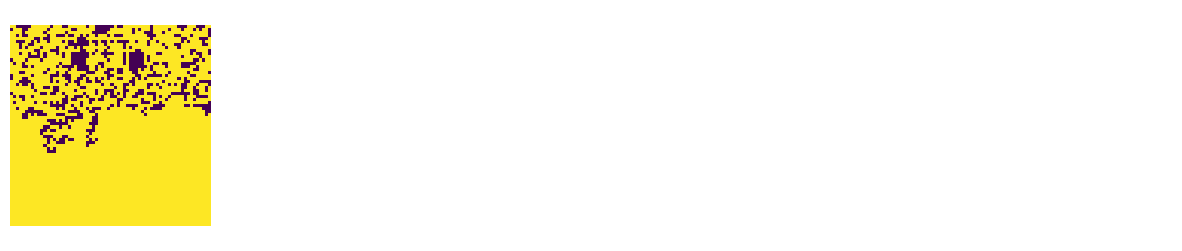

3328
2498
1.0 0.0


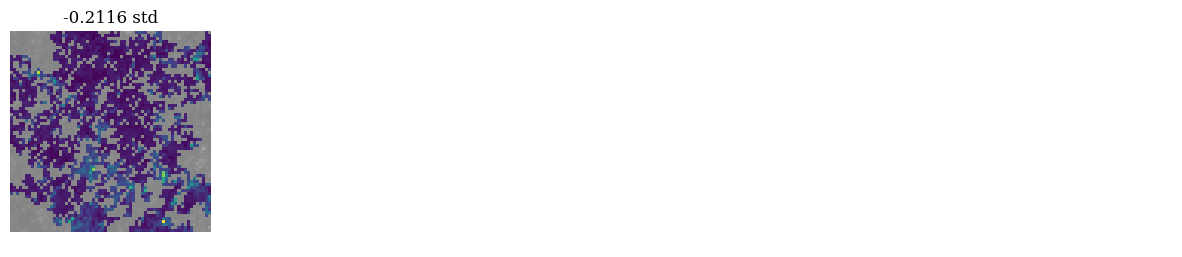

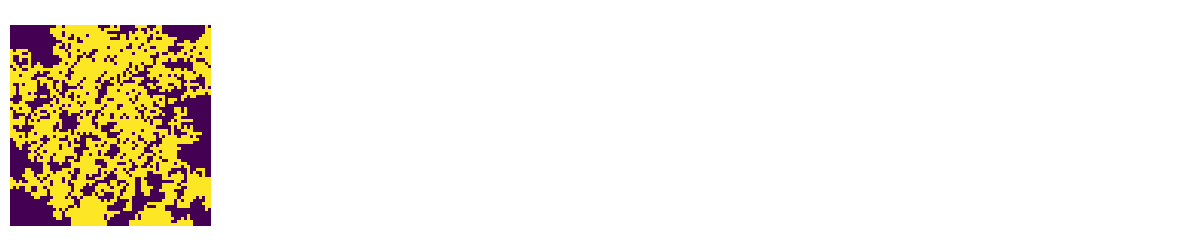

In [117]:
import numpy as np

for ran in np.argsort(ranges)[::-1][:10]:
    print(ran)
    stat = stats_all[ran]
    show_img_seg_plot(stat.image, stat.label, stat.unique_masks, stat.summed_weights, stat.mean_logits)

In [ ]:
import numpy as np

for ran in np.argsort(ranges)[::-1][:50]:
    stat = stats_all[ran]
    show_img_seg_plot(stat.image, stat.label, stat.unique_masks, stat.summed_weights, stat.mean_logits)

329
0.99999994 0.0
2800
1.0 0.0
3126
1.0 0.0


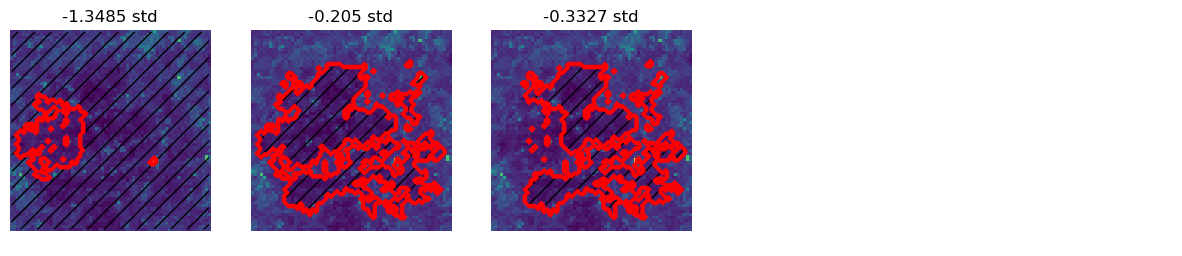

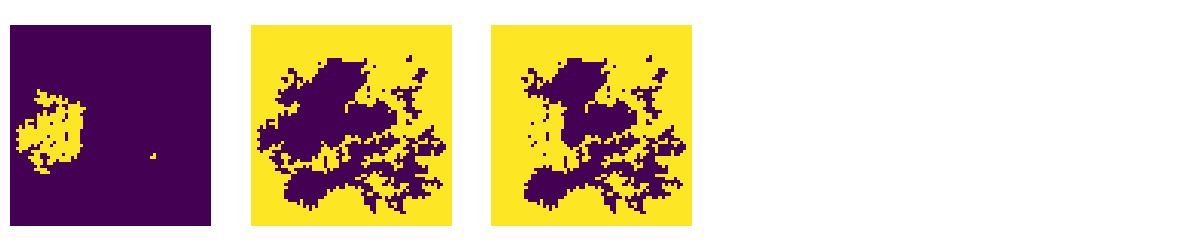

3107
1.0 0.0
3437
1.0 0.0


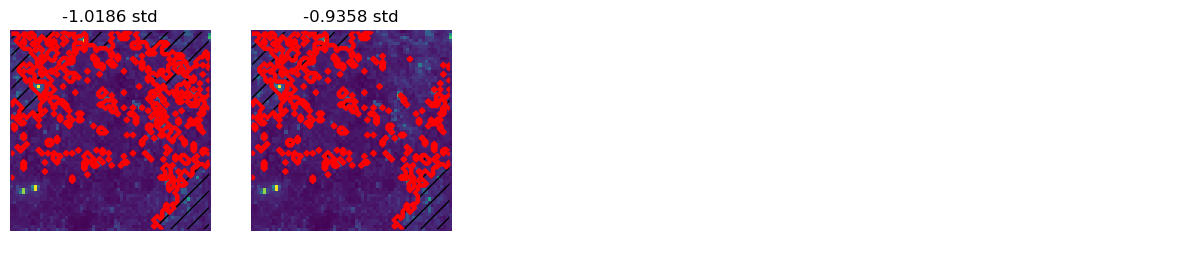

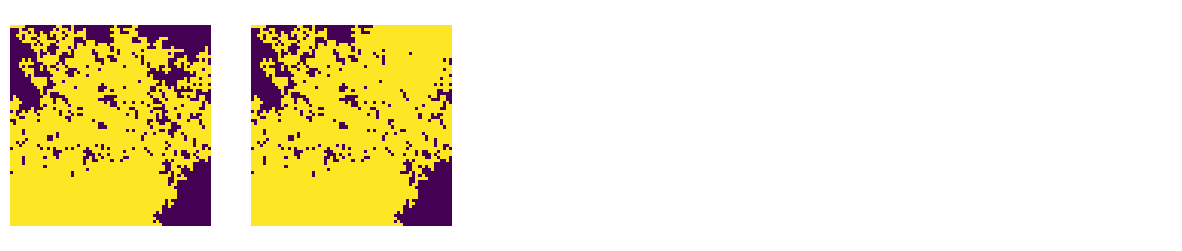

1647
1.0 0.0
2353
1.0 0.0


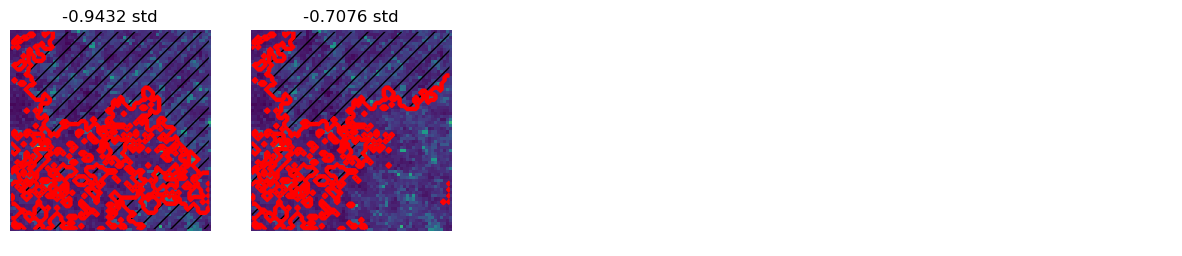

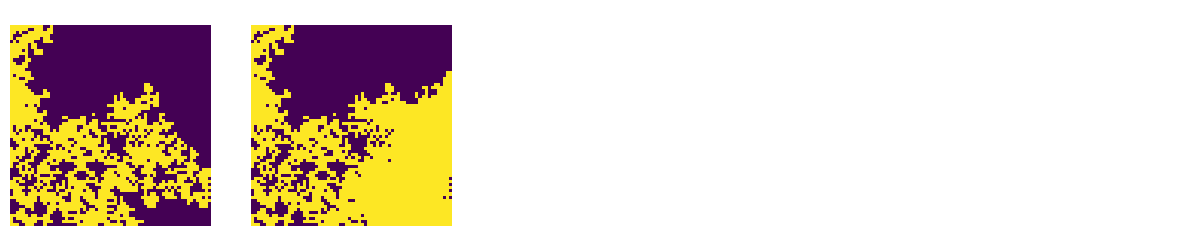

2537
1.0 0.0
3080
1.0 0.0
3306
1.0 0.0


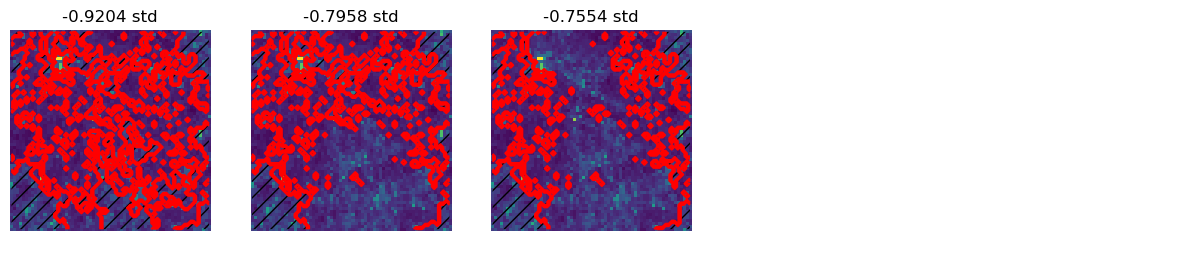

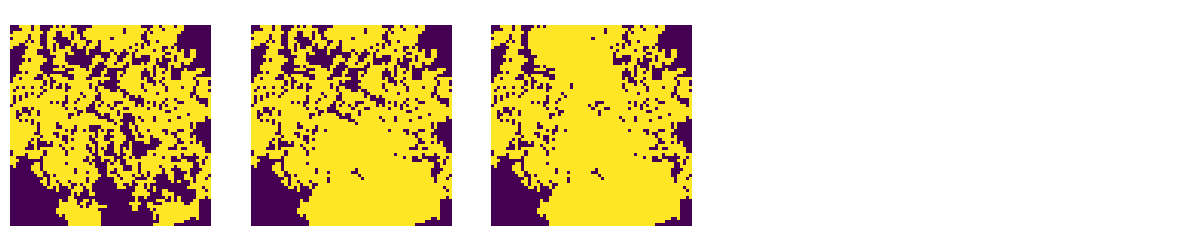

2054
1.0 0.0
2670
1.0 0.0


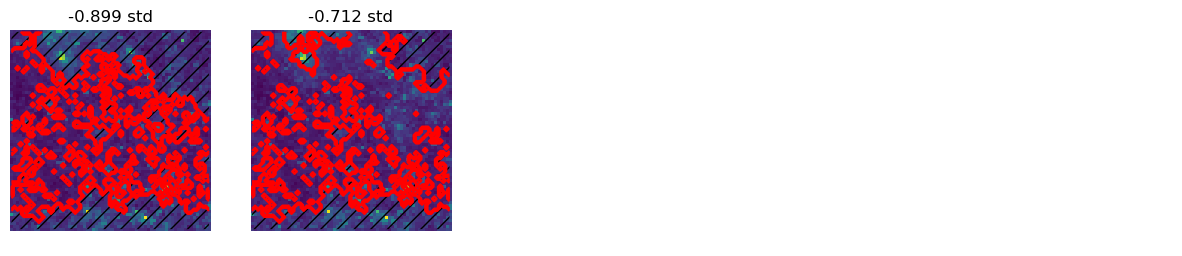

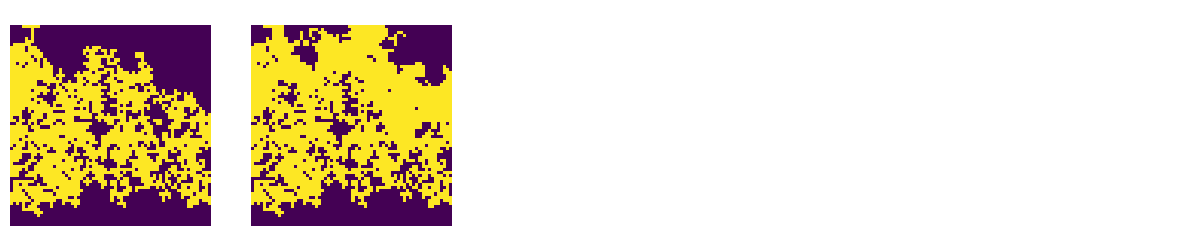

2250
1.0 0.0


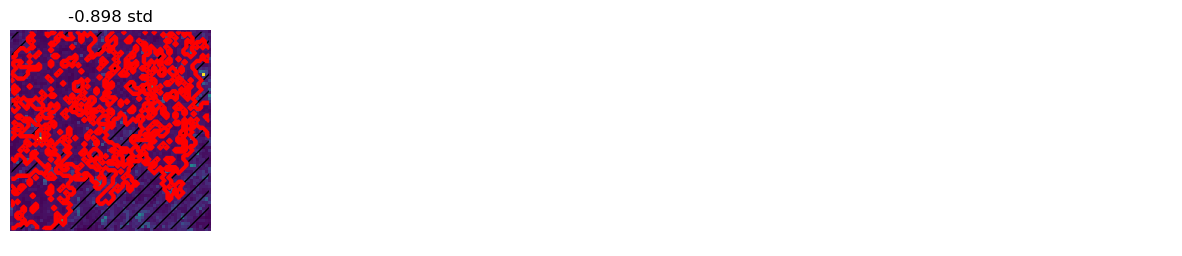

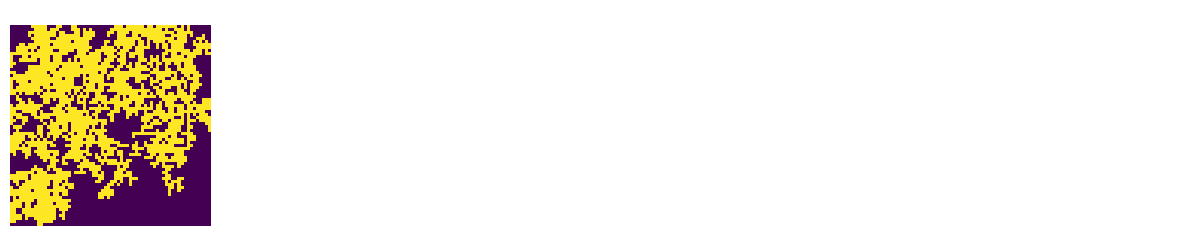

913
1.0 0.0
2028
0.99999994 0.0


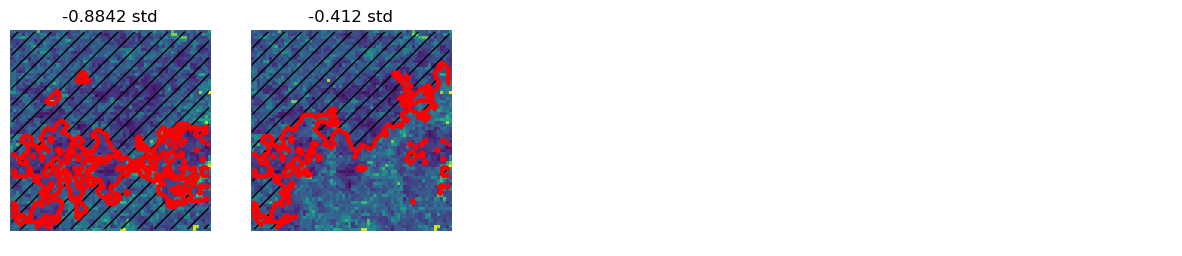

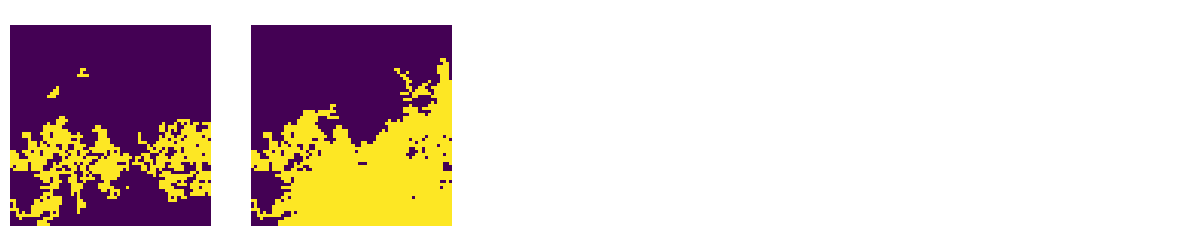

2534
1.0 0.0


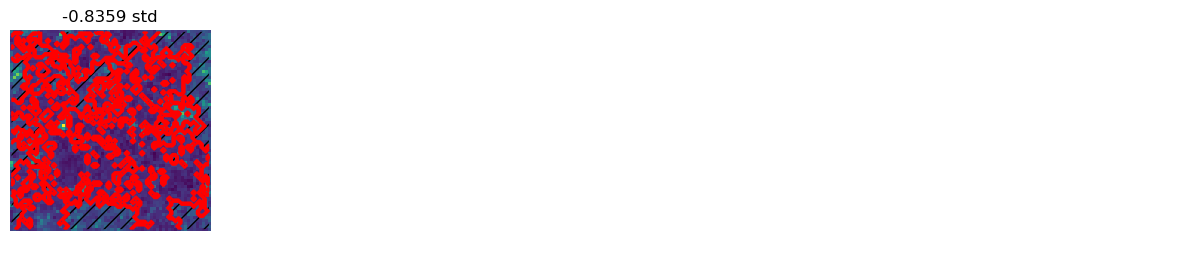

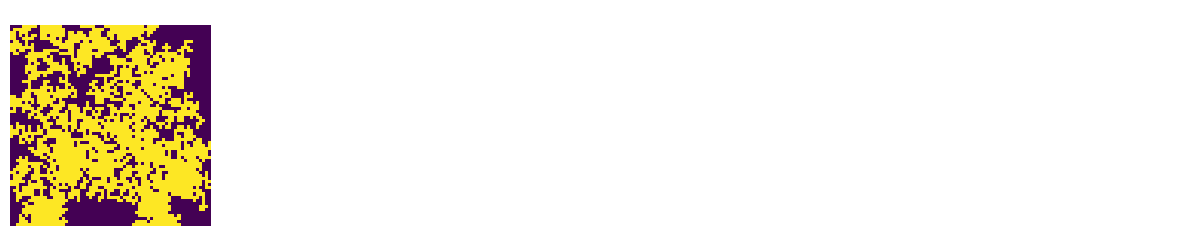

3098
1.0 0.0


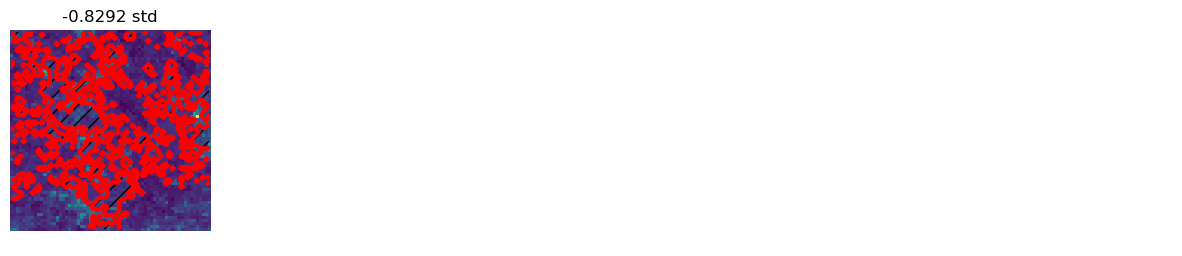

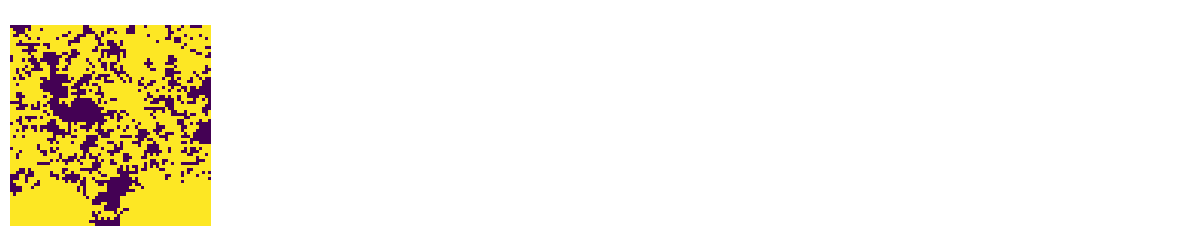

777
1.0 0.0
38
1.0 0.0
139
1.0 0.0


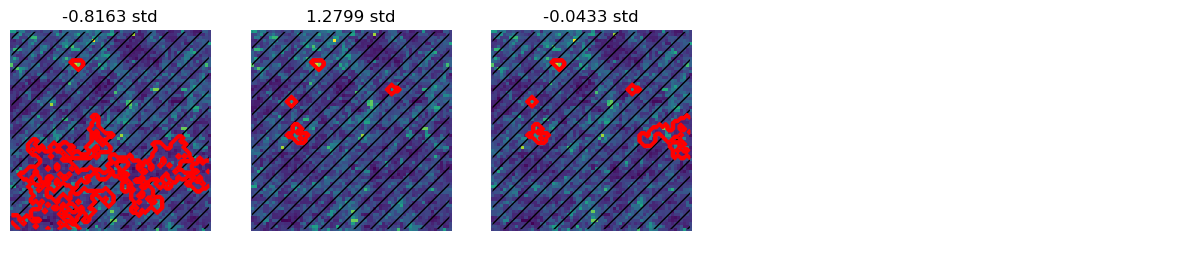

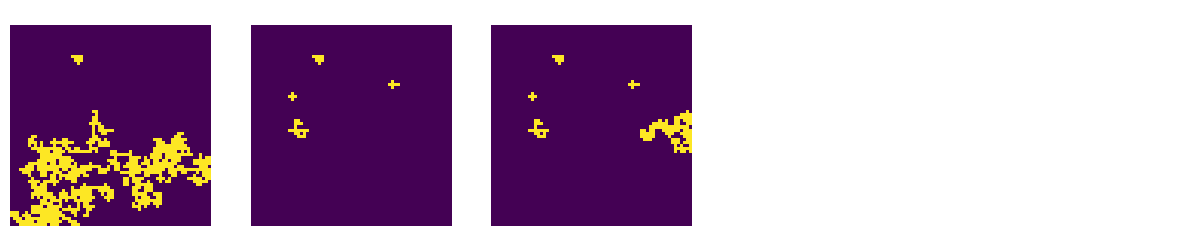

2921
1.0 0.0
3368
0.99999994 0.0


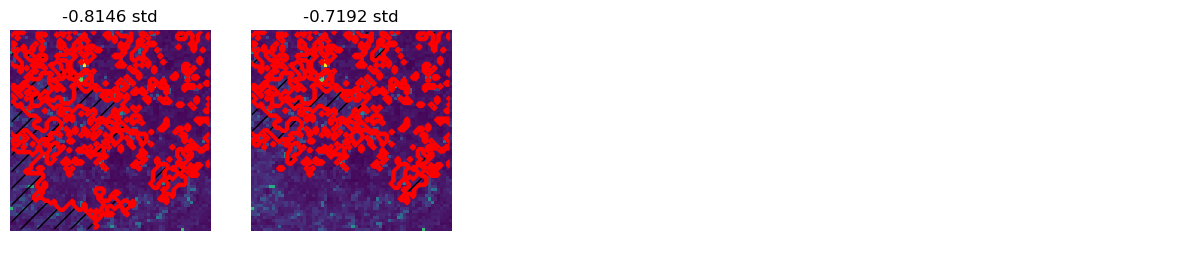

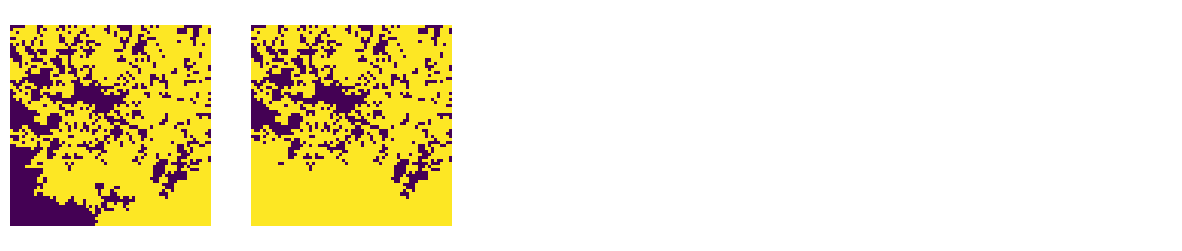

1592
1.0 0.0
1600
1.0 0.0
1699
1.0 0.0


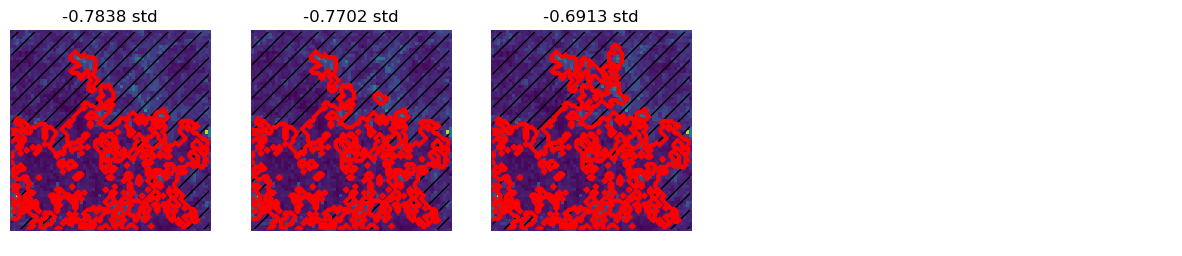

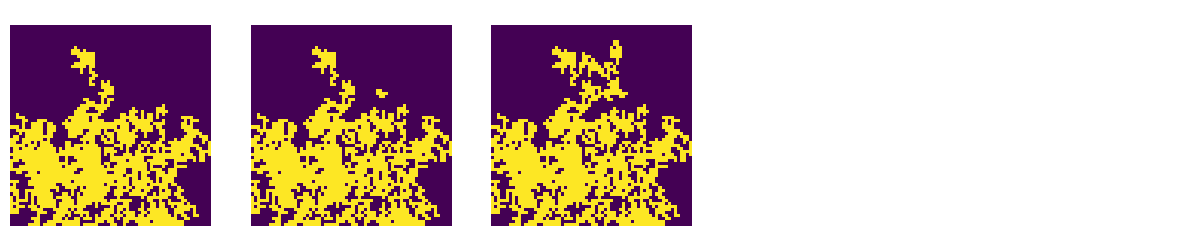

698
1.0 0.0
2052
1.0 0.0


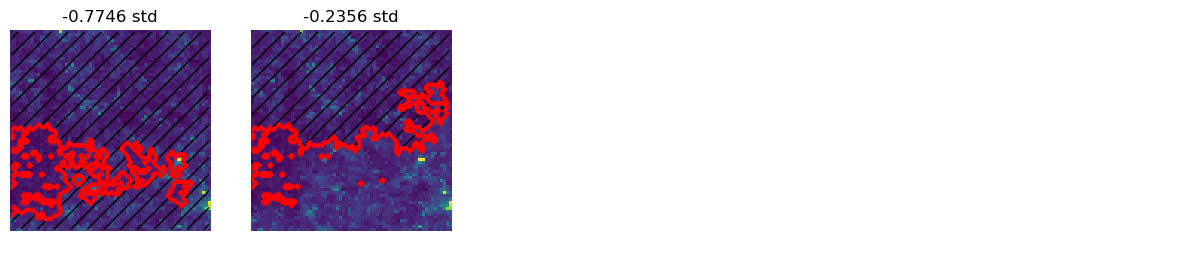

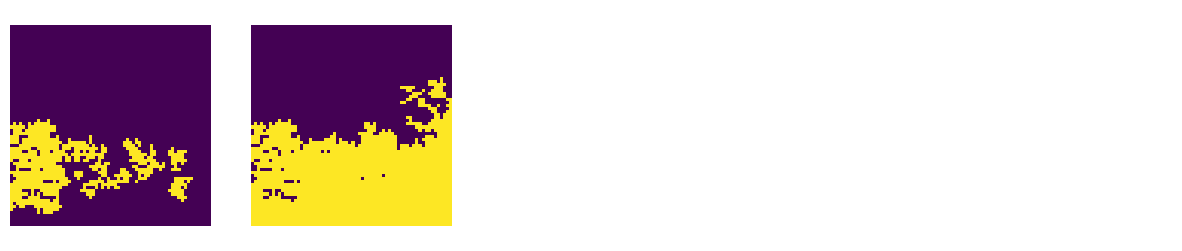

2284
1.0 0.0


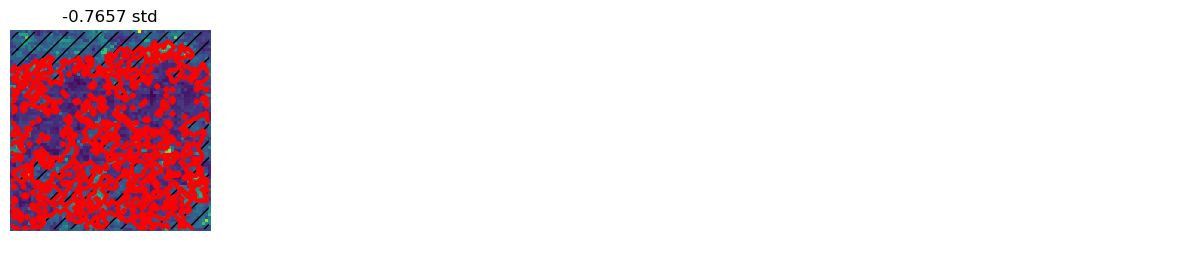

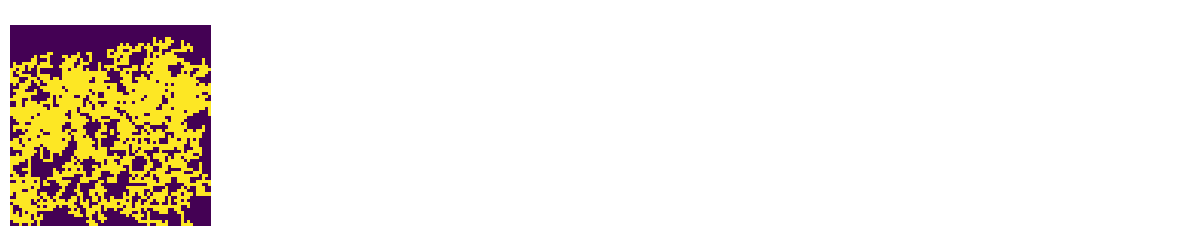

2761
1.0 0.0


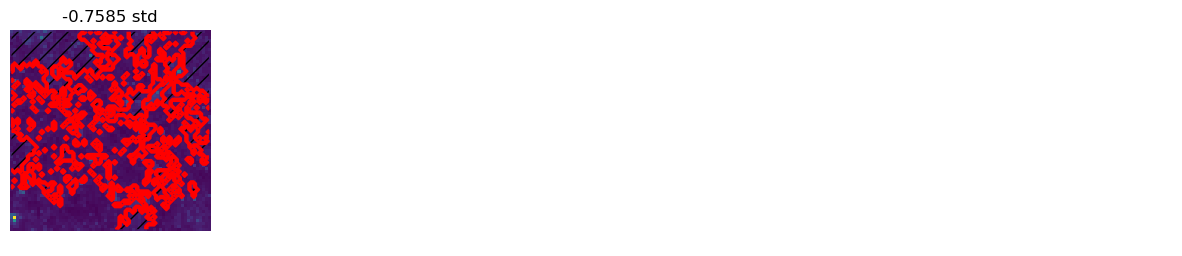

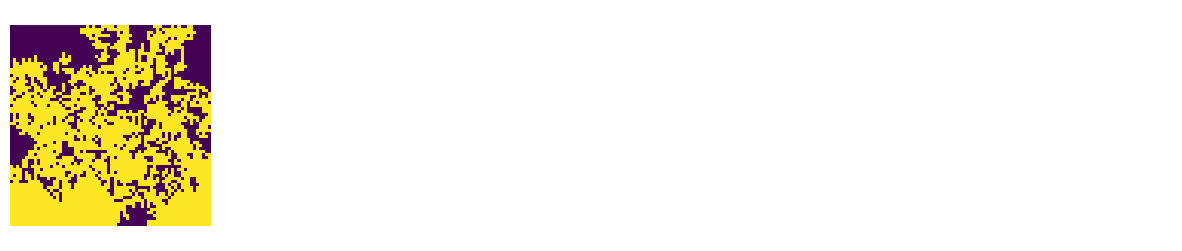

78
1.0 0.0
3642
1.0 0.0
3704
1.0 0.0


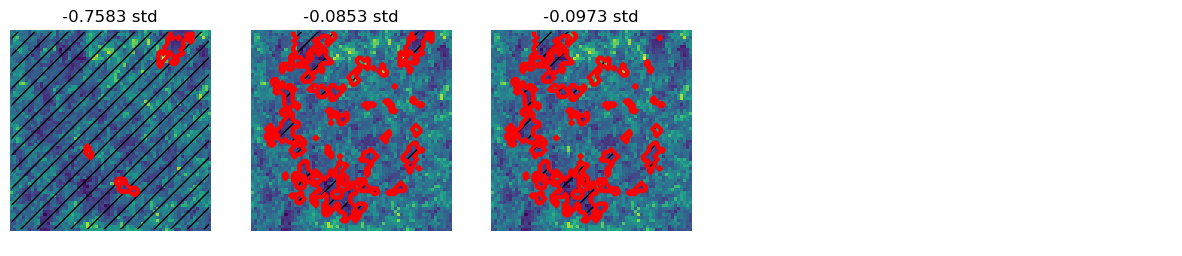

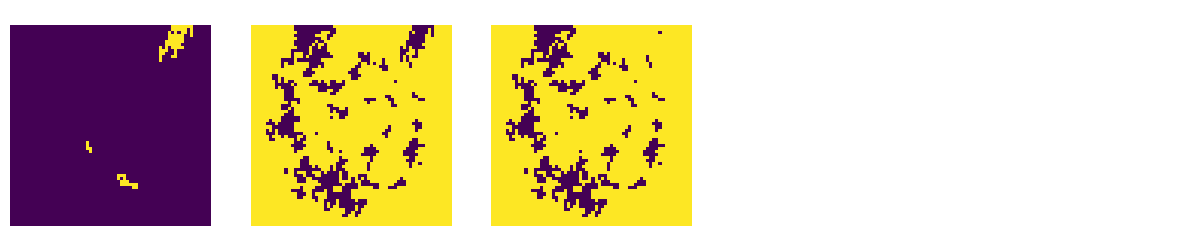

1461
1.0 0.0


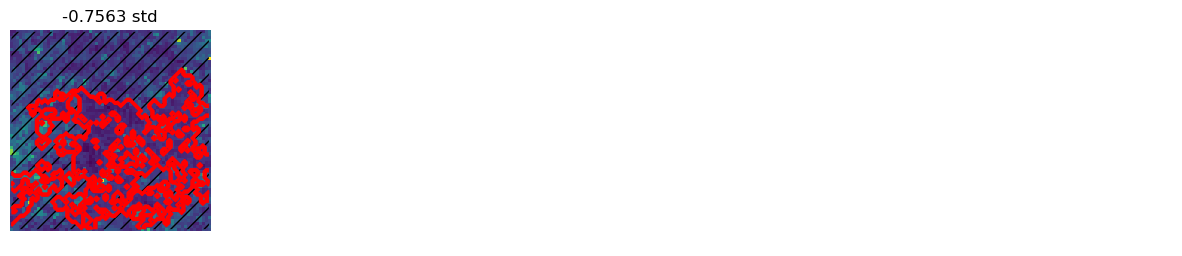

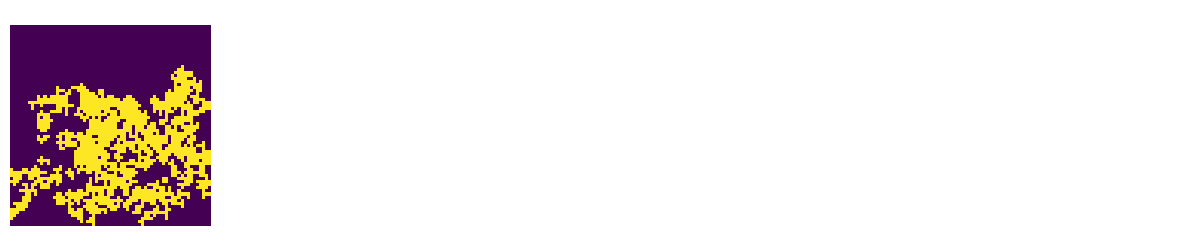

2703
1.0 0.0


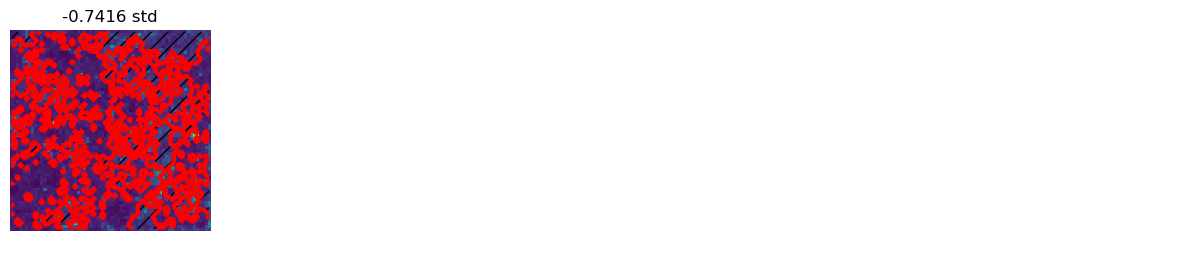

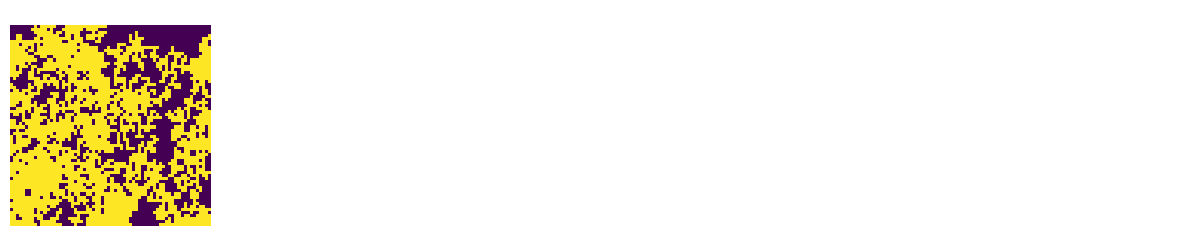

2245
1.0 0.0
3157
1.0 0.0


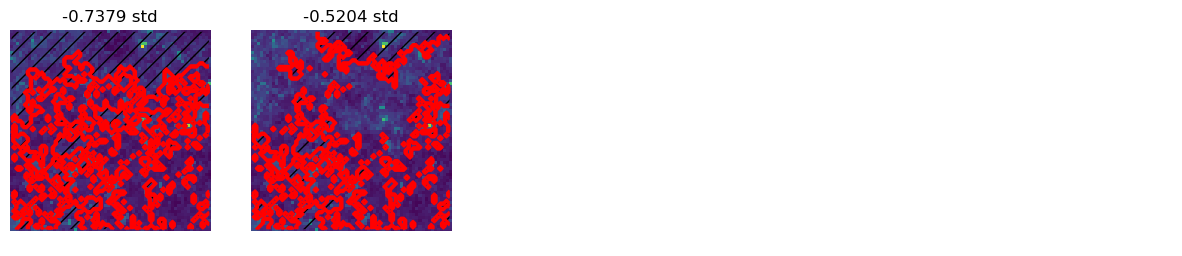

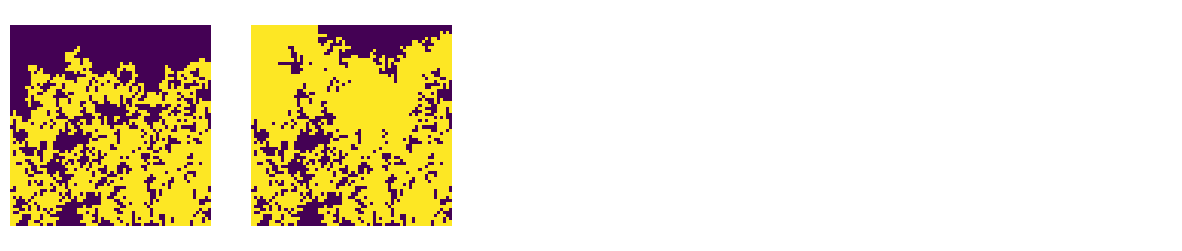

3363
1.0 0.0
3520
0.99999994 0.0


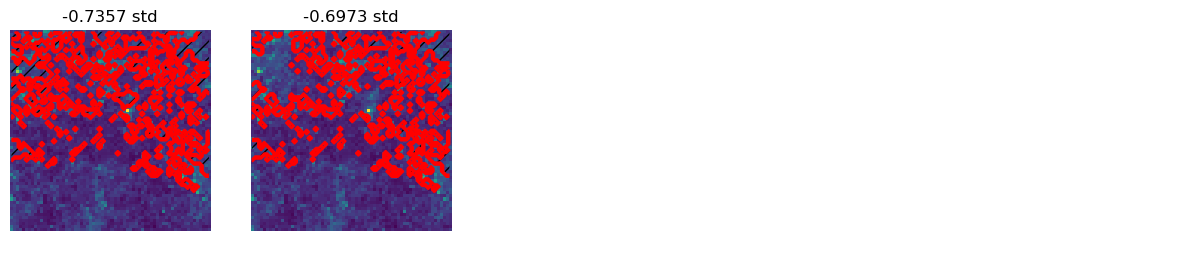

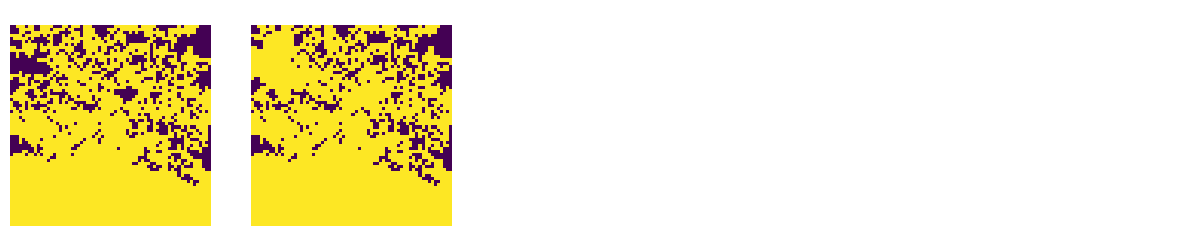

In [34]:
import numpy as np

for ran in np.argsort(min_stds)[:20]:
    stat = stats_all[ran]
    show_img_seg_plot(stat.image, stat.label, stat.unique_masks, stat.summed_weights, stat.mean_logits)

In [16]:
stats_all[0].linearize()

" stds [tensor(0.0909, device='cuda:0')]"

In [17]:
total

41982

In [79]:
len(stats_all_comb.bright_subset), len(stats_all_comb.dark_subset)

(409, 5257)

In [60]:
len(stats_all_comb.darkhighweight_omega_subset), len(stats_all_comb.darkhighweight_omega_subset)

1848

In [61]:
len(stats_all_comb.darkhighweight_omega_subset), len(stats_all_comb.darkhighweight_sigma_subset), len(stats_all_comb.brighthighweight_omega_subset), len(stats_all_comb.brighthighweight_sigma_subset)

(1848, 2146, 86, 67)

In [ ]:
dark_weights_omega = [mask_id_feat_dict[k][3][0].cpu().numpy() for k in dark_subset]
dark_weights_sigma = [mask_id_feat_dict[k][3][1].cpu().numpy() for k in dark_subset]
bright_weights_omega = [mask_id_feat_dict[k][3][0].cpu().numpy() for k in bright_subset]
bright_weights_sigma = [mask_id_feat_dict[k][3][1].cpu().numpy() for k in bright_subset]

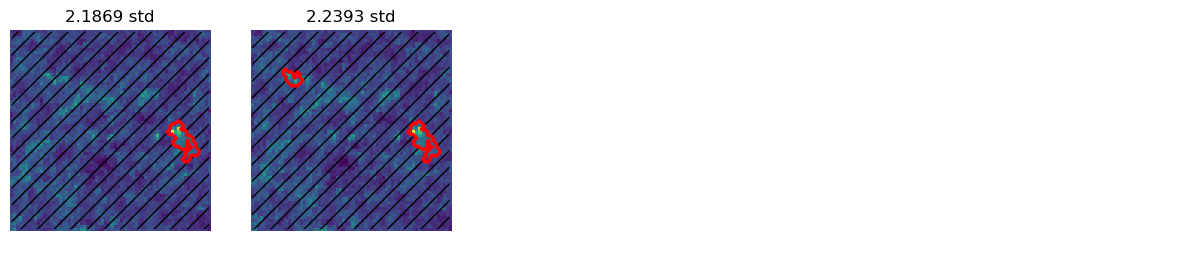

In [27]:
import matplotlib.pyplot as plt
import math

def show_img_seg(filename, i):
    data = torch.load(os.path.join(input_dir, filename))
    image = data['image']
    label = data['label']
    logits = data['logits']
    unique_masks = data['unique_masks']
    summed_weights = data['summed_weights']
    mean_logits = data['mean_logits']
    
    rows = math.ceil(len(unique_masks)/5)
    cols = 5
    fig, axs = plt.subplots(rows, cols, 
                            figsize=(cols * 3, rows * 3))
    axs = axs.ravel()
    
    for j in range(len(unique_masks)):
        img, label, mask, mask_weight, pred = image, label, unique_masks[j], summed_weights[j], mean_logits[j]
        img_pth = img
        mask_pth = mask #torch.from_numpy(mask)
        masked_img = img_pth*(mask_pth > 1e-4)
        DARK_THRESHOLD = 0
        BRIGHT_THRESHOLD = 2
        sigma = img_pth.std()
        bright_pixels = (img_pth > 2*sigma).sum()
        frac_bright_bhuv = (masked_img > 2*sigma).sum()/bright_pixels
        frac_bright_wong = (masked_img > 2*sigma).sum()/((mask_pth > 1e-4).sum())
        mask_intensity = (masked_img.squeeze()[(mask_pth > 1e-4)].mean())
        
        axs[j].imshow(image[0].cpu().numpy())
        axs[j].contour(unique_masks[j].cpu().numpy() > 0, 1, colors='red')
        if (unique_masks[j].cpu().numpy() > 0).sum() < unique_masks[j].shape[-1] * unique_masks[j].shape[-2]:
            axs[j].contourf(unique_masks[j].cpu().numpy() > 0, 1, hatches=['//', None, None],
                            cmap='gray', extend='neither', linestyles='-', alpha=0.01)
        axs[j].set_title(str(round(float(mask_intensity.item() / sigma), 4)) + ' std')
    for j in range(len(axs)):
        axs[j].axis('off')
    plt.show()

filename, i = stats_all_comb.bright_subset[0][0]    
show_img_seg(filename, i)

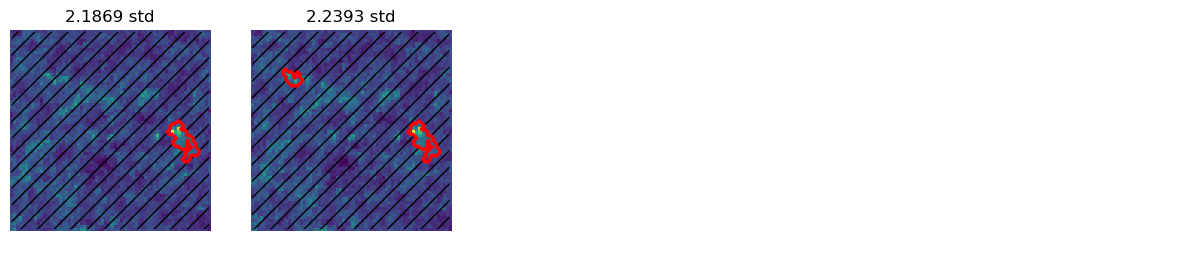

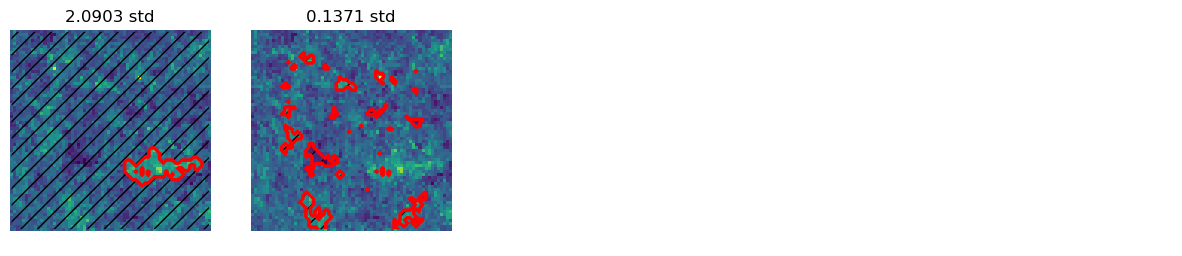

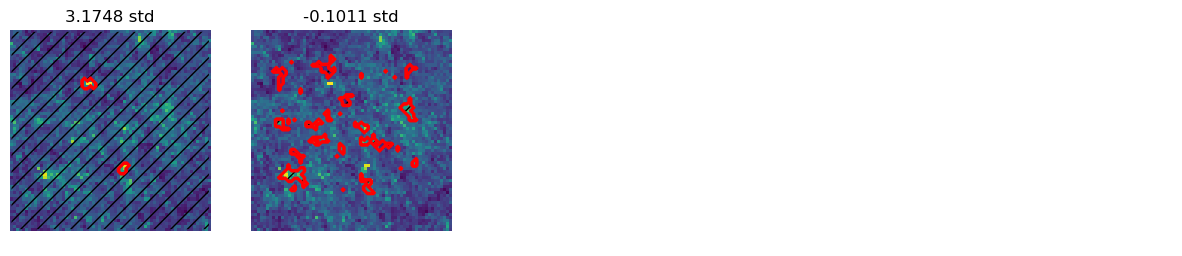

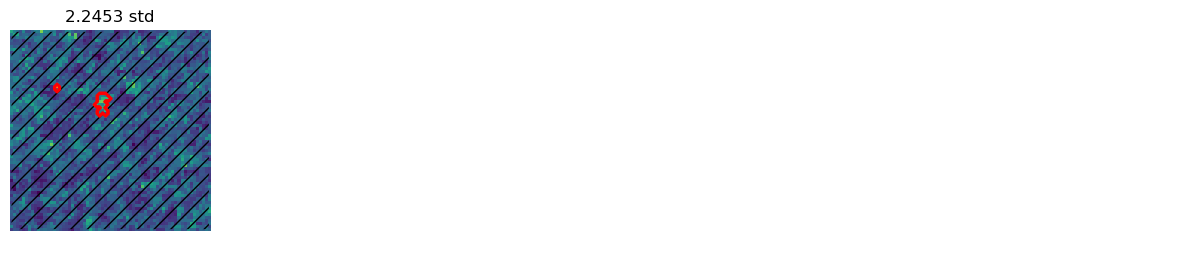

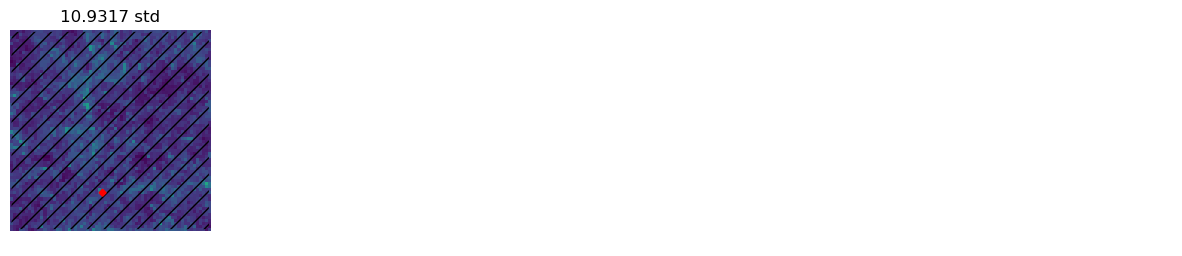

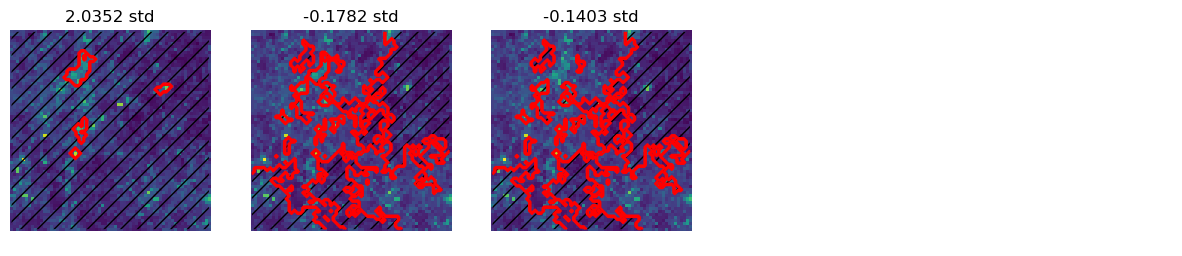

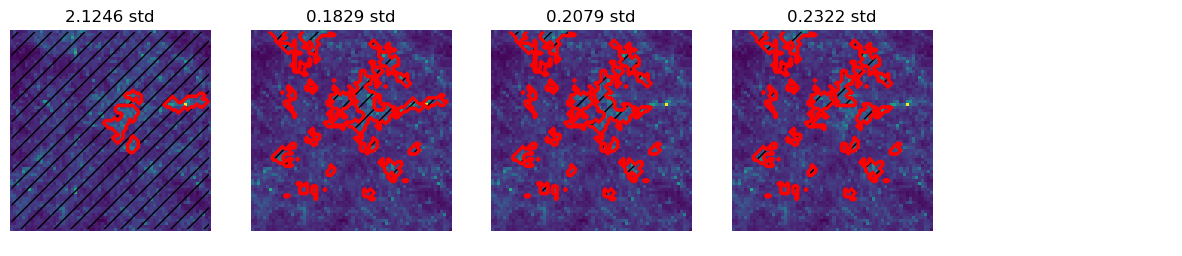

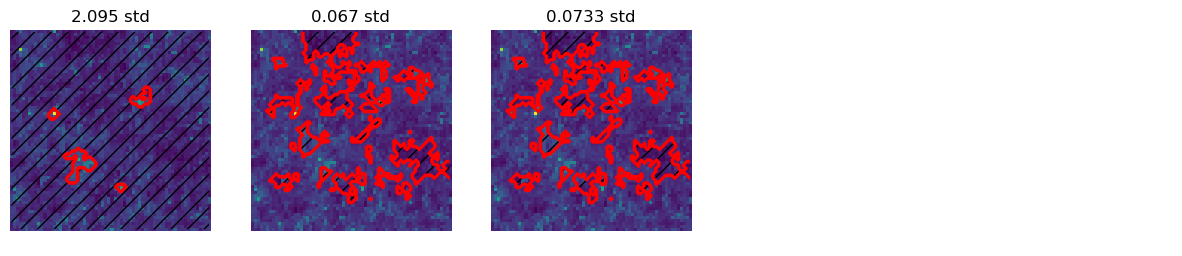

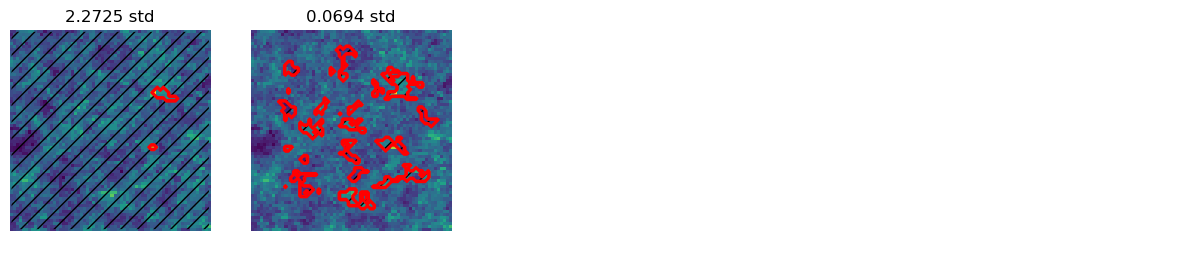

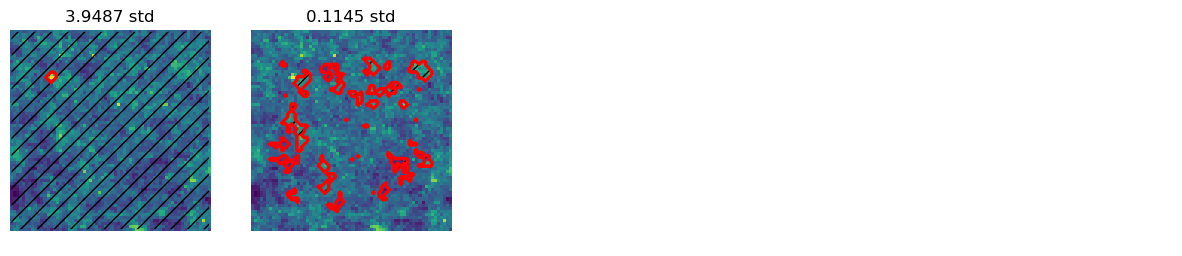

In [29]:
used = set()

for seg_list in stats_all_comb.bright_subset[:10]:
    seg_tuple = tuple(seg_list)
    if seg_tuple in used:
        continue
    used.add(seg_tuple)
    filename, i = seg_list[0]
    show_img_seg(filename, i)

In [49]:
len(stats_all_comb.dark_subset), stats_all_comb.dark_subset[:10]

(5410,
 [[('10.pt', 0), ('10.pt', 1)],
  [('1002.pt', 0)],
  [('1003.pt', 1), ('1003.pt', 6)],
  [('1005.pt', 3), ('1005.pt', 4), ('1005.pt', 5)],
  [('1006.pt', 4)],
  [('1009.pt', 0)],
  [('101.pt', 0)],
  [('1010.pt', 0)],
  [('1011.pt', 0),
   ('1011.pt', 1),
   ('1011.pt', 2),
   ('1011.pt', 3),
   ('1011.pt', 4)],
  [('1012.pt', 0), ('1012.pt', 1)]])

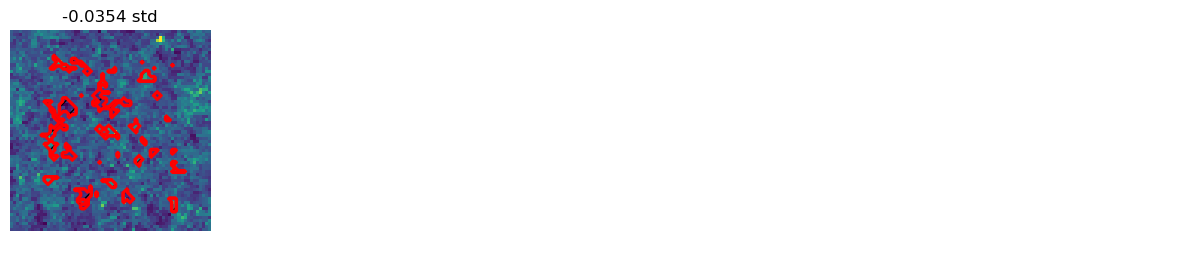

In [30]:
filename, i = stats_all_comb.dark_subset[3][0]    
show_img_seg(filename, i)

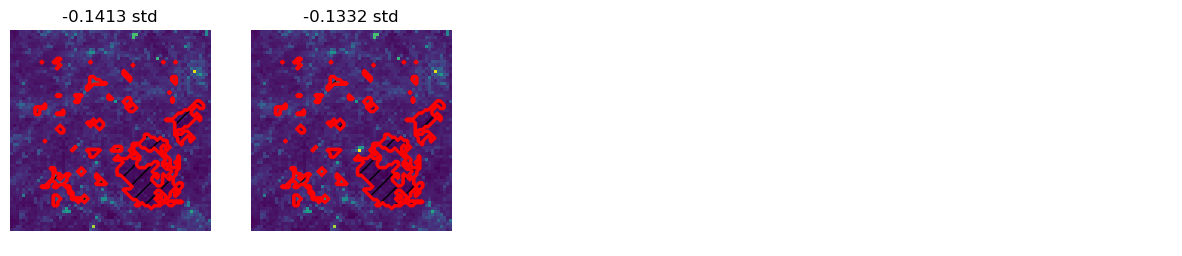

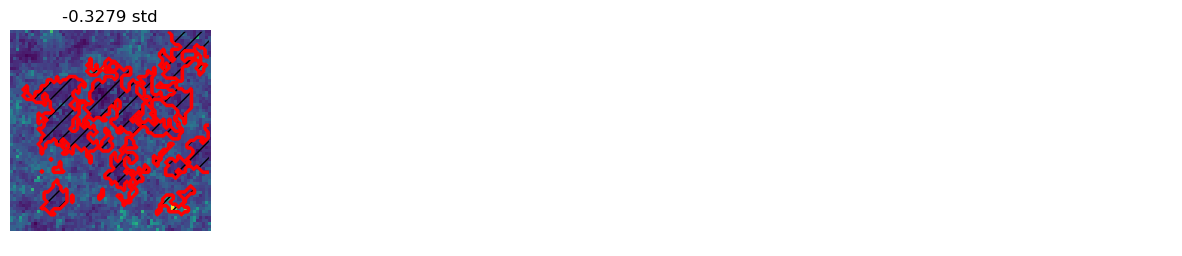

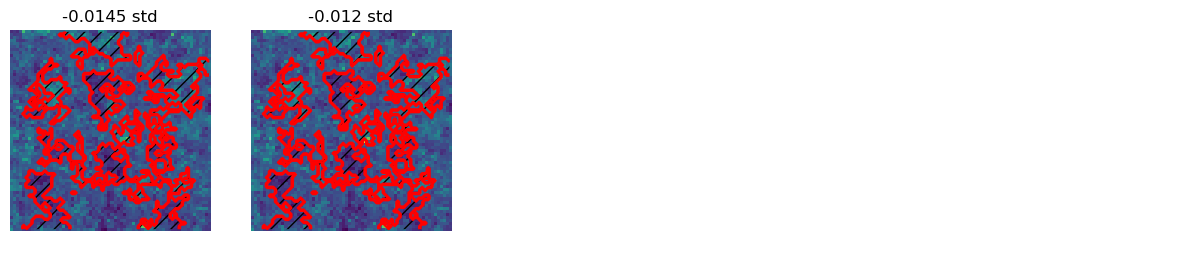

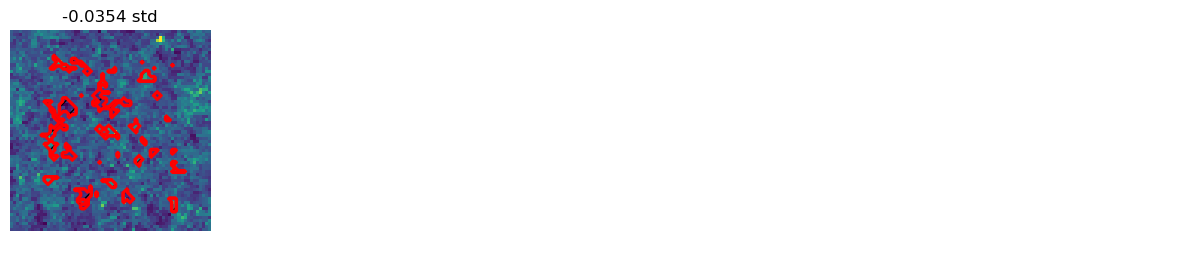

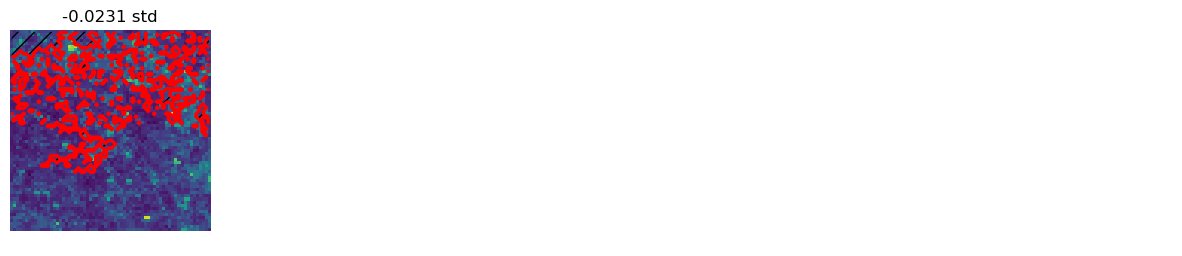

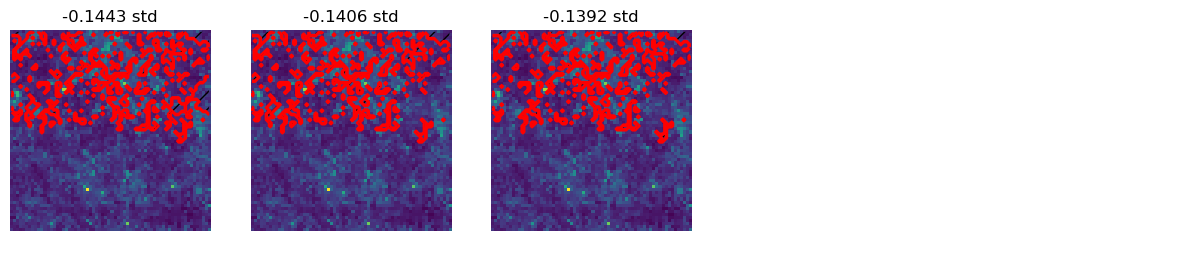

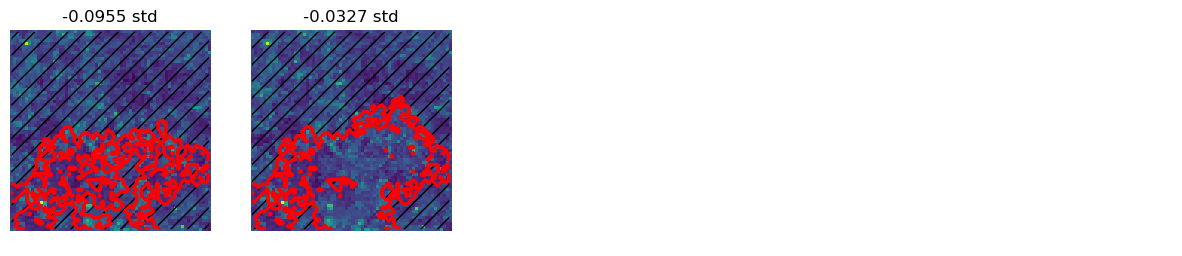

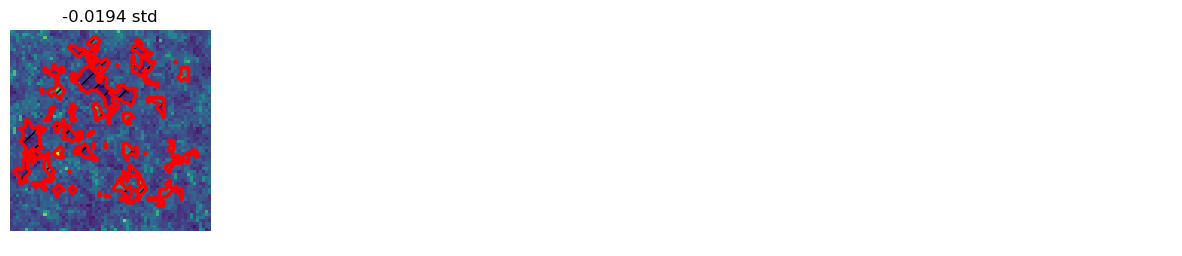

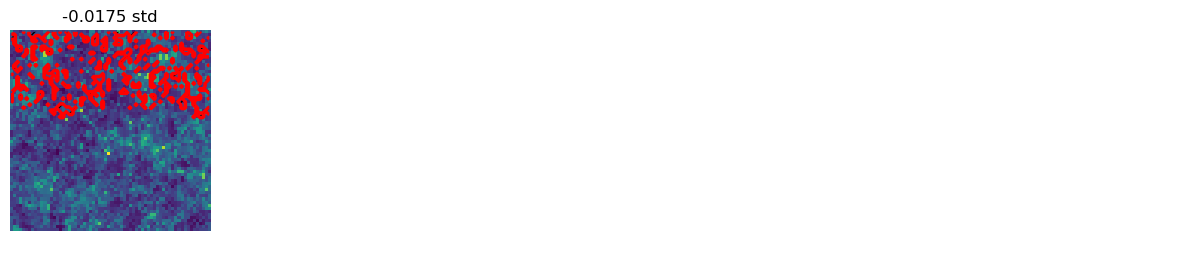

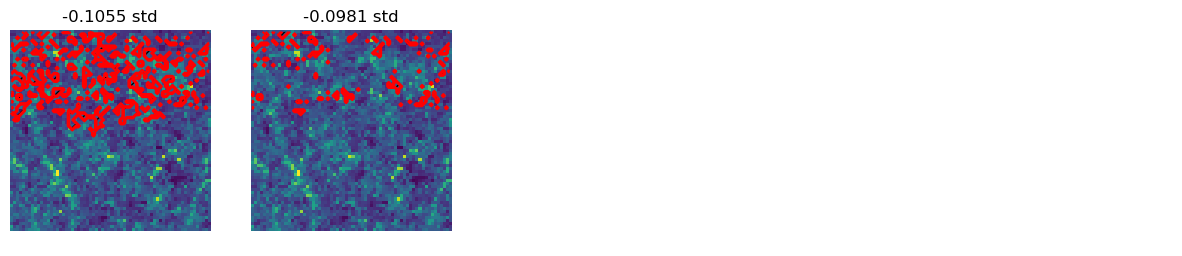

In [31]:
used = set()

for seg_list in stats_all_comb.dark_subset[:10]:
    seg_tuple = tuple(seg_list)
    if seg_tuple in used:
        continue
    used.add(seg_tuple)
    filename, i = seg_list[0]
    show_img_seg(filename, i)

In [ ]:
stats_all_comb.linearize()

## Test

In [25]:
import os
import torch
from tqdm.auto import tqdm

input_dir = '../../exps/cosmogrid_4h/best/val_results'

X = []
images = []
mask_paths = []
mask_idxs = []
preds_all = []
labels_all = []
mask_id_feat_dict = {}


count = 0
filenames = sorted(os.listdir(input_dir))
# for filename in tqdm(filenames[:1000]):
filename = filenames[100]
data = torch.load(os.path.join(input_dir, filename))


In [26]:
for k, v in data.items():
    if isinstance(v, torch.Tensor):
        print(f'{k}\t{v.shape}')
    else:
        print(f'{k}\t{v}')

image	torch.Size([1, 66, 66])
original_logits	torch.Size([2])
logits	torch.Size([2])
unique_logits_used	torch.Size([14, 2])
masks	torch.Size([800, 66, 66])
unique_masks_used	torch.Size([14, 66, 66])
unique_mask_weights_used	torch.Size([14, 2])
unique_losses_used	torch.Size([14, 2])
label	torch.Size([2])
counts	torch.Size([14])
num_labels	2


In [27]:
image = data['image']
original_logits = data['original_logits']
logits = data['logits']
unique_logits_used = data['unique_logits_used']
masks = data['masks']
unique_masks_used = data['unique_masks_used']
unique_mask_weights_used = data['unique_mask_weights_used']
unique_losses_used = data['unique_losses_used']
label = data['label']
counts = data['counts']
num_labels = data['num_labels']

In [28]:
unique_masks, summed_weights, mean_logits = sum_weights_for_unique_masks(unique_masks_used, 
                                                                        unique_mask_weights_used, 
                                                                        unique_logits_used)

In [29]:
unique_masks[0].shape, summed_weights[0].shape, mean_logits[0].shape

(torch.Size([66, 66]), torch.Size([2]), torch.Size([2]))

In [30]:
len(unique_masks), len(summed_weights), len(mean_logits)

(10, 10, 10)

In [31]:
i = 0
img, label, mask, mask_weight, pred = image, label, unique_masks[i], summed_weights[i], mean_logits[i]

In [36]:
img_pth = img
mask_pth = mask #torch.from_numpy(mask)
masked_img = img_pth*(mask_pth > 1e-4)

VERBOSE = False
outputs = []

stats_single = Stats()
DARK_THRESHOLD = 0
BRIGHT_THRESHOLD = 2

sigma = img_pth.std()
bright_pixels = (img_pth > 2*sigma).sum()
total = img_pth.numel()
#     if i == 0: 
#         print(bright_pixels, bright_pixels/total)
frac_bright_bhuv = (masked_img > 2*sigma).sum()/bright_pixels
frac_bright_wong = (masked_img > 2*sigma).sum()/((mask_pth > 1e-4).sum())

mask_intensity = (masked_img.squeeze()[(mask_pth > 1e-4)].mean())
if VERBOSE: 
    print(f'mask #{i}')
    print(f'{frac_bright_bhuv} - fraction of bright pixels in mask / bright pixels in image')
    print(f'{frac_bright_wong} - fraction of bright pixels in mask / pixels in mask')
    print(f'Omega weight: {mask_weight[0]:.2f}, Sigma_8 weight: {mask_weight[1]:.2f}')
    print(f'[{mask_intensity:.4f} > {2*sigma:.4f}] Is supercluster? {mask_intensity > 2*sigma}')
outputs.append([mask_intensity, 2*sigma])



# subset for omega
if mask_intensity > BRIGHT_THRESHOLD*sigma:
    stats_single.bright_subset.append(k)
    stats_single.mask_weight_total['bright'][0] += mask_weight[0] 
    stats_single.mask_weight_total['bright'][1] += mask_weight[1] 
    stats_single.mask_weight_list['bright'][0].append(mask_weight[0].item())
    stats_single.mask_weight_list['bright'][1].append(mask_weight[1].item())

if mask_intensity < DARK_THRESHOLD*sigma:
    stats_single.vdark_subset.append(k)
    stats_single.mask_weight_total['dark'][0] += mask_weight[0] 
    stats_single.mask_weight_total['dark'][1] += mask_weight[1] 
    stats_single.mask_weight_list['dark'][0].append(mask_weight[0].item())
    stats_single.mask_weight_list['dark'][1].append(mask_weight[1].item())


if mask_intensity < DARK_THRESHOLD*sigma and mask_weight[0] == 1:
    stats_single.darkhighweight_omega_subset.append(k)
if mask_intensity < DARK_THRESHOLD*sigma and mask_weight[1] == 1:
    stats_single.darkhighweight_sigma_subset.append(k)
if mask_intensity > BRIGHT_THRESHOLD*sigma and mask_weight[0] >= 0.3:
    stats_single.brighthighweight_omega_subset.append(k)
if mask_intensity > BRIGHT_THRESHOLD*sigma and mask_weight[1] >= 0.4:
    stats_single.brighthighweight_sigma_subset.append(k)

if mask_intensity < DARK_THRESHOLD*sigma and (pred[0] - label[0]).abs().sum() < 1e-2:
    stats_single.darkgoodloss_omega_subset.append(k)
if mask_intensity < DARK_THRESHOLD*sigma and (pred[1] - label[1]).abs().sum() < 1e-2:
    stats_single.darkgoodloss_sigma_subset.append(k)
if mask_intensity > BRIGHT_THRESHOLD*sigma and (pred[0] - label[0]).abs().sum() < 1e-2:
    stats_single.brightgoodloss_omega_subset.append(k)
if mask_intensity > BRIGHT_THRESHOLD*sigma and (pred[1] - label[1]).abs().sum() < 1e-2:
    stats_single.brightgoodloss_sigma_subset.append(k)
if mask_weight[0] == 1 and (pred - label).abs().sum() < 1e-2:
    stats_single.highweight_subset.append(k)
# subset for omega
# print(mask_weight[0].cpu(), pred, torch.Tensor(label))
if mask_weight[0] > 0.9 and (pred - label).abs().sum() < 1e-1: 
#     if mask_weight[0] > 0.1 and mask_intensity > 1*sigma: 
    stats_single.omega_subset.append(k)
if mask_weight[1] > 0.9 and (pred - label).abs().sum() < 1e-1: 
    stats_single.sigma_subset.append(k)
total += 1

sigma tensor(0.0096, device='cuda:0')
mask_intensity tensor(0.0013, device='cuda:0')


In [37]:
stats_single.__dict__

{'omega_subset': [],
 'sigma_subset': [],
 'bright_subset': ['num_labels'],
 'dark_subset': [],
 'highweight_subset': [],
 'darkhighweight_omega_subset': [],
 'darkhighweight_sigma_subset': [],
 'brighthighweight_omega_subset': [],
 'brighthighweight_sigma_subset': [],
 'darkgoodloss_omega_subset': [],
 'darkgoodloss_sigma_subset': [],
 'brightgoodloss_omega_subset': [],
 'brightgoodloss_sigma_subset': [],
 'mask_weight_total': {'dark': [0, 0],
  'bright': [tensor(0., device='cuda:0'), tensor(0.0284, device='cuda:0')]},
 'mask_weight_list': {'dark': [[], []],
  'bright': [[0.0], [0.028397947549819946]]}}

In [ ]:
# for i in range(20): 
#     v = mask_id_feat_dict[('1000.pkl',i)]

VERBOSE = False
outputs = []
omega_subset = []
sigma_subset = []
bright_subset = []
dark_subset = []
highweight_subset = []
darkhighweight_omega_subset = []
darkhighweight_sigma_subset = []
brighthighweight_omega_subset = []
brighthighweight_sigma_subset = []
darkgoodloss_omega_subset = []
darkgoodloss_sigma_subset = []
brightgoodloss_omega_subset = []
brightgoodloss_sigma_subset = []
mask_weight_total = {
    'dark': [0, 0],
    'bright': [0, 0]
}
mask_weight_list = {
    'dark': [[], []],
    'bright': [[], []]
}
DARK_THRESHOLD = 0
BRIGHT_THRESHOLD = 2

v = mask_id_feat_dict[k]
img, label, mask, mask_weight, pred = v

img_pth = torch.from_numpy(img)
mask_pth = mask.cpu() #torch.from_numpy(mask)
masked_img = img_pth*(mask_pth > 1e-4)


sigma = img_pth.std()
bright_pixels = (img_pth > 2*sigma).sum()
total = img_pth.numel()
#     if i == 0: 
#         print(bright_pixels, bright_pixels/total)
frac_bright_bhuv = (masked_img > 2*sigma).sum()/bright_pixels
frac_bright_wong = (masked_img > 2*sigma).sum()/((mask_pth > 1e-4).sum())

mask_intensity = (masked_img.squeeze()[(mask_pth > 1e-4)].mean())
if VERBOSE: 
    print(f'mask #{i}')
    print(f'{frac_bright_bhuv} - fraction of bright pixels in mask / bright pixels in image')
    print(f'{frac_bright_wong} - fraction of bright pixels in mask / pixels in mask')
    print(f'Omega weight: {mask_weight[0]:.2f}, Sigma_8 weight: {mask_weight[1]:.2f}')
    print(f'[{mask_intensity:.4f} > {2*sigma:.4f}] Is supercluster? {mask_intensity > 2*sigma}')
outputs.append([mask_intensity, 2*sigma])



# subset for omega
if mask_intensity > BRIGHT_THRESHOLD*sigma:
    bright_subset.append(k)
    mask_weight_total['bright'][0] += mask_weight[0] 
    mask_weight_total['bright'][1] += mask_weight[1] 
    mask_weight_list['bright'][0].append(mask_weight[0].cpu().item())
    mask_weight_list['bright'][1].append(mask_weight[1].cpu().item())

if mask_intensity < DARK_THRESHOLD*sigma:
    dark_subset.append(k)
    mask_weight_total['dark'][0] += mask_weight[0] 
    mask_weight_total['dark'][1] += mask_weight[1] 
    mask_weight_list['dark'][0].append(mask_weight[0].cpu().item())
    mask_weight_list['dark'][1].append(mask_weight[1].cpu().item())


if mask_intensity < DARK_THRESHOLD*sigma and mask_weight[0].cpu() == 1:
    darkhighweight_omega_subset.append(k)
if mask_intensity < DARK_THRESHOLD*sigma and mask_weight[1].cpu() == 1:
    darkhighweight_sigma_subset.append(k)
if mask_intensity > BRIGHT_THRESHOLD*sigma and mask_weight[0].cpu() >= 0.3:
    brighthighweight_omega_subset.append(k)
if mask_intensity > BRIGHT_THRESHOLD*sigma and mask_weight[1].cpu() >= 0.4:
    brighthighweight_sigma_subset.append(k)

if mask_intensity < DARK_THRESHOLD*sigma and (pred.cpu()[0] - torch.Tensor(label)[0]).abs().sum() < 1e-2:
    darkgoodloss_omega_subset.append(k)
if mask_intensity < DARK_THRESHOLD*sigma and (pred.cpu()[1] - torch.Tensor(label)[1]).abs().sum() < 1e-2:
    darkgoodloss_sigma_subset.append(k)
if mask_intensity > BRIGHT_THRESHOLD*sigma and (pred.cpu()[0] - torch.Tensor(label)[0]).abs().sum() < 1e-2:
    brightgoodloss_omega_subset.append(k)
if mask_intensity > BRIGHT_THRESHOLD*sigma and (pred.cpu()[1] - torch.Tensor(label)[1]).abs().sum() < 1e-2:
    brightgoodloss_sigma_subset.append(k)
if mask_weight[0].cpu() == 1 and (pred.cpu() - torch.Tensor(label)).abs().sum() < 1e-2:
    highweight_subset.append(k)
# subset for omega
# print(mask_weight[0].cpu(), pred, torch.Tensor(label))
if mask_weight[0].cpu() > 0.9 and (pred.cpu() - torch.Tensor(label)).abs().sum() < 1e-1: 
#     if mask_weight[0] > 0.1 and mask_intensity > 1*sigma: 
    omega_subset.append(k)
if mask_weight[1].cpu() > 0.9 and (pred.cpu() - torch.Tensor(label)).abs().sum() < 1e-1: 
    sigma_subset.append(k)
total += 1
#     plotter(masked_img)
#     plt.show()
    